In [1]:
import pandas as pd

data = pd.read_csv("datasets/amazon_reviews.csv")

In [2]:
data.head()

,class_index,review_title,review_text
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


In [3]:
data['class_index'].value_counts()

class_index
2    200000
1    200000
Name: count, dtype: int64

In [4]:
data.isnull().sum()

class_index      0
review_title    24
review_text      0
dtype: int64

In [5]:
data.fillna('', inplace=True)
data.isnull().sum()

class_index     0
review_title    0
review_text     0
dtype: int64

In [6]:
data['label'] = data['class_index'] - 1
data.head()


,class_index,review_title,review_text,label
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...,1
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,1
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,0
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,1
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,1


In [7]:
data['review'] = data['review_title'] + ' ' + data['review_text']
data.head()

,class_index,review_title,review_text,label,review
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...,1,Great CD My lovely Pat has one of the GREAT vo...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,1,One of the best game music soundtracks - for a...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,0,Batteries died within a year ... I bought this...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,1,"works fine, but Maha Energy is better Check ou..."
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,1,Great for the non-audiophile Reviewed quite a ...


In [8]:
downsized = data.sample(n=5000, random_state=42)

In [9]:
#Code to clean review text data
import re
import string
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from textblob import TextBlob
from langdetect import detect

# Download necessary NLTK data
nltk.download("stopwords")
nltk.download("wordnet")

# Initialize NLP tools
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def cleanReview(text):
    if not isinstance(text, str):
        return ""

    # 1. Convert to lowercase
    text = text.lower()

    # 2. Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # 3. Remove square brackets
    text = re.sub(r'\[.*?\]', '', text)

    # 4. Remove punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)

    # 5. Remove numbers
    text = re.sub(r'\w*\d\w*', '', text)

    # 6. Remove special quote marks & newlines
    text = re.sub(r'[‘’“”…]', '', text)
    text = text.replace("\n", " ")

    # 7. Remove stopwords
    text = " ".join([word for word in text.split() if word not in stop_words])

    # 8. Spell Correction
    text = str(TextBlob(text).correct())

    # 9. Stemming
    text = " ".join([stemmer.stem(word) for word in text.split()])

    # 10. Lemmatization
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])

    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sean.lai/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sean.lai/nltk_data...


In [10]:
downsized["text"] = downsized['review'].apply(cleanReview)
downsized.head()


,class_index,review_title,review_text,label,review,text
23218,2,This is a great book,I must preface this by saying that I am not re...,1,This is a great book I must preface this by sa...,great book must prefac say religi love book re...
20731,1,Huge Disappointment.,"As a big time, long term Trevanian fan, I was ...",0,"Huge Disappointment. As a big time, long term ...",huge disappoint big time long term trevanian f...
39555,2,Wayne is tight but cant hang with Turk.,This album is hot as it wants to be. However C...,1,Wayne is tight but cant hang with Turk. This a...,wayn tight can hang turk album hot want howev ...
147506,2,Excellent,I read this book when I was in elementary scho...,1,Excellent I read this book when I was in eleme...,excel read book elementari school probabl four...
314215,1,Not about Anusara,Although this book is touted on several Anusar...,0,Not about Anusara Although this book is touted...,anusara although book rout sever anusara web s...


In [11]:
from datasets import Dataset

dataset = Dataset.from_dict(downsized)

dataset = dataset.train_test_split(test_size=0.2)

/Users/sean.lai/XcodeProjects/sentiment-analysis/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
import torch
import optuna
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)

dataset = dataset.map(tokenize_function, batched=True)
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Model Initialization
def model_init():
    return AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)

# Hyperparameter tuning function
def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 2e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    num_train_epochs = trial.suggest_int("num_train_epochs", 2, 5)

    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_train_epochs,
        learning_rate=learning_rate,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=10,
        load_best_model_at_end=True,
    )

    trainer = Trainer(
        model_init=model_init,
        args=training_args,
        train_dataset=dataset["train"].shuffle(seed=42).select(range(2000)),
        eval_dataset=dataset["test"].select(range(500)),
    )

    trainer.train()
    eval_results = trainer.evaluate()
    return eval_results["eval_loss"]  # Minimize loss

# Run hyperparameter tuning
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

# Print best hyperparameters
print("Best hyperparameters:", study.best_params)

Map: 100%|██████████| 1000/1000 [00:00<00:00, 4682.13 examples/s]
[I 2025-03-03 11:26:08,591] A new study created in memory with name: no-name-48a342f7-07a4-4443-91ea-dddb88012084
Error while downloading from https://cdn-lfs.hf.co/bert-base-uncased/68d45e234eb4a928074dfd868cead0219ab85354cc53d20e772753c6bb9169d3?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1740974285&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0MDk3NDI4NX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9iZXJ0LWJhc2UtdW5jYXNlZC82OGQ0NWUyMzRlYjRhOTI4MDc0ZGZkODY4Y2VhZDAyMTlhYjg1MzU0Y2M1M2QyMGU3NzI3NTNjNmJiOTE2OWQzP3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiJ9XX0_&Signature=cJZwXOaMyLIru-5%7ENBAw6GWEJvJ64JVffu4zev5huyKOdiU1ktr3%7EHED54TQYNr96Wp7Jucy2oHbT35PQ418oQeEk6c3Z4fqmQpebch89hGxdNrgs4h0UcRzrIKmVX3p-MMAUsRNBqFxdiMd-EQys2PF-1NwzTxDXPnWh6eKZPEz4yC91O%7EvbWM2cV1-0gSiQMm1sz2q%7Eub6OtLAiz0WObBqqnvH

{'loss': 0.3809, 'grad_norm': nan, 'learning_rate': 2.7033185377869044e-05, 'epoch': 0.16}


 11%|█         | 20/189 [02:08<15:32,  5.52s/it]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 2.5522951557876362e-05, 'epoch': 0.32}


 16%|█▌        | 30/189 [03:03<14:57,  5.64s/it]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 2.4012717737883676e-05, 'epoch': 0.48}


 21%|██        | 40/189 [04:03<14:25,  5.81s/it]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 2.2502483917890994e-05, 'epoch': 0.63}


 26%|██▋       | 50/189 [04:59<12:54,  5.57s/it]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 2.099225009789831e-05, 'epoch': 0.79}


 32%|███▏      | 60/189 [05:55<11:52,  5.52s/it]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 1.9482016277905626e-05, 'epoch': 0.95}


                                                
 33%|███▎      | 63/189 [06:30<11:39,  5.55s/it]

{'eval_loss': nan, 'eval_runtime': 18.4795, 'eval_samples_per_second': 27.057, 'eval_steps_per_second': 0.866, 'epoch': 1.0}


 37%|███▋      | 70/189 [07:22<14:08,  7.13s/it]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 1.797178245791294e-05, 'epoch': 1.11}


 42%|████▏     | 80/189 [08:21<10:40,  5.87s/it]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 1.6461548637920258e-05, 'epoch': 1.27}


 48%|████▊     | 90/189 [09:19<09:43,  5.89s/it]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 1.4951314817927574e-05, 'epoch': 1.43}


 53%|█████▎    | 100/189 [10:18<08:43,  5.88s/it]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 1.3441080997934888e-05, 'epoch': 1.59}


 58%|█████▊    | 110/189 [11:17<07:52,  5.98s/it]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 1.1930847177942204e-05, 'epoch': 1.75}


 63%|██████▎   | 120/189 [12:15<06:53,  5.99s/it]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 1.042061335794952e-05, 'epoch': 1.9}


                                                 
 67%|██████▋   | 126/189 [13:08<05:43,  5.45s/it]

{'eval_loss': nan, 'eval_runtime': 18.2223, 'eval_samples_per_second': 27.439, 'eval_steps_per_second': 0.878, 'epoch': 2.0}


 69%|██████▉   | 130/189 [13:37<08:07,  8.26s/it]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 8.910379537956836e-06, 'epoch': 2.06}


 74%|███████▍  | 140/189 [14:36<04:57,  6.08s/it]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 7.400145717964152e-06, 'epoch': 2.22}


 79%|███████▉  | 150/189 [15:35<03:50,  5.91s/it]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 5.889911897971468e-06, 'epoch': 2.38}


 85%|████████▍ | 160/189 [16:34<02:50,  5.89s/it]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 4.379678077978784e-06, 'epoch': 2.54}


 90%|████████▉ | 170/189 [17:38<02:01,  6.38s/it]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 2.8694442579860996e-06, 'epoch': 2.7}


 95%|█████████▌| 180/189 [18:42<00:57,  6.37s/it]

{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 1.3592104379934156e-06, 'epoch': 2.86}


                                                 
100%|██████████| 189/189 [20:01<00:00,  5.72s/it]

{'eval_loss': nan, 'eval_runtime': 19.385, 'eval_samples_per_second': 25.793, 'eval_steps_per_second': 0.825, 'epoch': 3.0}


100%|██████████| 189/189 [20:08<00:00,  6.39s/it]


{'train_runtime': 1208.2131, 'train_samples_per_second': 4.966, 'train_steps_per_second': 0.156, 'train_loss': 0.020152899323317108, 'epoch': 3.0}


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]
[W 2025-03-03 11:47:05,658] Trial 0 failed with parameters: {'learning_rate': 2.854341919786173e-05, 'batch_size': 32, 'num_train_epochs': 3} because of the following error: The value nan is not acceptable.
[W 2025-03-03 11:47:05,664] Trial 0 failed with value nan.
/Users/sean.lai/XcodeProjects/sentiment-analysis/.venv/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are n

{'loss': 0.6973, 'grad_norm': 2.177579402923584, 'learning_rate': 3.0300116001164872e-05, 'epoch': 0.08}


  3%|▎         | 20/625 [01:25<38:47,  3.85s/it]

{'loss': 0.7015, 'grad_norm': 3.827732563018799, 'learning_rate': 2.9807431188137798e-05, 'epoch': 0.16}


  5%|▍         | 30/625 [02:05<39:29,  3.98s/it]

{'loss': 0.6813, 'grad_norm': 5.9454169273376465, 'learning_rate': 2.9314746375110728e-05, 'epoch': 0.24}


  6%|▋         | 40/625 [02:46<40:03,  4.11s/it]

{'loss': 0.6644, 'grad_norm': 3.0249433517456055, 'learning_rate': 2.882206156208366e-05, 'epoch': 0.32}


  8%|▊         | 50/625 [03:26<38:13,  3.99s/it]

{'loss': 0.5771, 'grad_norm': 4.6847758293151855, 'learning_rate': 2.832937674905659e-05, 'epoch': 0.4}


 10%|▉         | 60/625 [04:07<38:37,  4.10s/it]

{'loss': 0.5857, 'grad_norm': 5.5127434730529785, 'learning_rate': 2.7836691936029516e-05, 'epoch': 0.48}


 11%|█         | 70/625 [04:47<35:35,  3.85s/it]

{'loss': 0.5594, 'grad_norm': 14.629024505615234, 'learning_rate': 2.7344007123002445e-05, 'epoch': 0.56}


 13%|█▎        | 80/625 [05:28<36:39,  4.04s/it]

{'loss': 0.4771, 'grad_norm': 15.879276275634766, 'learning_rate': 2.6851322309975375e-05, 'epoch': 0.64}


 14%|█▍        | 90/625 [06:06<34:32,  3.87s/it]

{'loss': 0.5521, 'grad_norm': 12.179543495178223, 'learning_rate': 2.63586374969483e-05, 'epoch': 0.72}


 16%|█▌        | 100/625 [06:44<35:16,  4.03s/it]

{'loss': 0.4731, 'grad_norm': 4.331700801849365, 'learning_rate': 2.586595268392123e-05, 'epoch': 0.8}


 18%|█▊        | 110/625 [07:28<36:33,  4.26s/it]

{'loss': 0.4936, 'grad_norm': 10.38479995727539, 'learning_rate': 2.537326787089416e-05, 'epoch': 0.88}


 19%|█▉        | 120/625 [08:08<34:29,  4.10s/it]

{'loss': 0.4221, 'grad_norm': 5.4100565910339355, 'learning_rate': 2.4880583057867092e-05, 'epoch': 0.96}


 20%|██        | 125/625 [09:38<33:43,  4.05s/it]

{'eval_loss': 0.5287556052207947, 'eval_runtime': 70.1559, 'eval_samples_per_second': 7.127, 'eval_steps_per_second': 0.456, 'epoch': 1.0}


 21%|██        | 130/625 [10:06<1:19:36,  9.65s/it]

{'loss': 0.3593, 'grad_norm': 8.659557342529297, 'learning_rate': 2.438789824484002e-05, 'epoch': 1.04}


 22%|██▏       | 140/625 [10:44<30:59,  3.83s/it]  

{'loss': 0.385, 'grad_norm': 14.020920753479004, 'learning_rate': 2.3895213431812948e-05, 'epoch': 1.12}


 24%|██▍       | 150/625 [11:19<27:39,  3.49s/it]

{'loss': 0.3365, 'grad_norm': 4.116636276245117, 'learning_rate': 2.3402528618785877e-05, 'epoch': 1.2}


 26%|██▌       | 160/625 [11:59<30:47,  3.97s/it]

{'loss': 0.3316, 'grad_norm': 7.330038547515869, 'learning_rate': 2.2909843805758807e-05, 'epoch': 1.28}


 27%|██▋       | 170/625 [12:36<27:44,  3.66s/it]

{'loss': 0.3987, 'grad_norm': 10.458172798156738, 'learning_rate': 2.2417158992731733e-05, 'epoch': 1.36}


 29%|██▉       | 180/625 [13:14<27:21,  3.69s/it]

{'loss': 0.3667, 'grad_norm': 12.287632942199707, 'learning_rate': 2.1924474179704662e-05, 'epoch': 1.44}


 30%|███       | 190/625 [13:55<30:15,  4.17s/it]

{'loss': 0.2492, 'grad_norm': 11.294530868530273, 'learning_rate': 2.1431789366677592e-05, 'epoch': 1.52}


 32%|███▏      | 200/625 [14:35<30:31,  4.31s/it]

{'loss': 0.2576, 'grad_norm': 19.357519149780273, 'learning_rate': 2.093910455365052e-05, 'epoch': 1.6}


 34%|███▎      | 210/625 [15:18<29:06,  4.21s/it]

{'loss': 0.3036, 'grad_norm': 23.25629997253418, 'learning_rate': 2.044641974062345e-05, 'epoch': 1.68}


 35%|███▌      | 220/625 [15:59<28:22,  4.20s/it]

{'loss': 0.4204, 'grad_norm': 2.0949554443359375, 'learning_rate': 1.995373492759638e-05, 'epoch': 1.76}


 37%|███▋      | 230/625 [16:39<27:18,  4.15s/it]

{'loss': 0.4722, 'grad_norm': 1.6520819664001465, 'learning_rate': 1.946105011456931e-05, 'epoch': 1.84}


 38%|███▊      | 240/625 [17:20<24:29,  3.82s/it]

{'loss': 0.4115, 'grad_norm': 5.982905387878418, 'learning_rate': 1.8968365301542236e-05, 'epoch': 1.92}


 40%|████      | 250/625 [17:58<24:54,  3.99s/it]

{'loss': 0.3178, 'grad_norm': 11.260162353515625, 'learning_rate': 1.8475680488515165e-05, 'epoch': 2.0}



 40%|████      | 250/625 [19:07<24:54,  3.99s/it]

{'eval_loss': 0.4914066195487976, 'eval_runtime': 68.5303, 'eval_samples_per_second': 7.296, 'eval_steps_per_second': 0.467, 'epoch': 2.0}


 42%|████▏     | 260/625 [19:57<31:50,  5.23s/it]  

{'loss': 0.1827, 'grad_norm': 4.505900859832764, 'learning_rate': 1.7982995675488094e-05, 'epoch': 2.08}


 43%|████▎     | 270/625 [20:36<23:13,  3.92s/it]

{'loss': 0.1971, 'grad_norm': 1.1827473640441895, 'learning_rate': 1.749031086246102e-05, 'epoch': 2.16}


 45%|████▍     | 280/625 [21:18<21:50,  3.80s/it]

{'loss': 0.1973, 'grad_norm': 56.224021911621094, 'learning_rate': 1.6997626049433953e-05, 'epoch': 2.24}


 46%|████▋     | 290/625 [21:56<23:01,  4.12s/it]

{'loss': 0.1582, 'grad_norm': 7.936458110809326, 'learning_rate': 1.6504941236406883e-05, 'epoch': 2.32}


 48%|████▊     | 300/625 [22:34<20:50,  3.85s/it]

{'loss': 0.2273, 'grad_norm': 32.05764389038086, 'learning_rate': 1.6012256423379812e-05, 'epoch': 2.4}


 50%|████▉     | 310/625 [23:14<21:13,  4.04s/it]

{'loss': 0.2903, 'grad_norm': 8.996469497680664, 'learning_rate': 1.5519571610352738e-05, 'epoch': 2.48}


 51%|█████     | 320/625 [23:55<21:14,  4.18s/it]

{'loss': 0.1521, 'grad_norm': 6.387007236480713, 'learning_rate': 1.5026886797325668e-05, 'epoch': 2.56}


 53%|█████▎    | 330/625 [24:33<18:50,  3.83s/it]

{'loss': 0.2194, 'grad_norm': 3.494480609893799, 'learning_rate': 1.4534201984298597e-05, 'epoch': 2.64}


 54%|█████▍    | 340/625 [25:10<16:40,  3.51s/it]

{'loss': 0.3294, 'grad_norm': 26.66451072692871, 'learning_rate': 1.4041517171271526e-05, 'epoch': 2.72}


 56%|█████▌    | 350/625 [25:45<16:42,  3.65s/it]

{'loss': 0.1605, 'grad_norm': 12.729655265808105, 'learning_rate': 1.3548832358244454e-05, 'epoch': 2.8}


 58%|█████▊    | 360/625 [26:27<17:53,  4.05s/it]

{'loss': 0.2234, 'grad_norm': 23.14263153076172, 'learning_rate': 1.3056147545217384e-05, 'epoch': 2.88}


 59%|█████▉    | 370/625 [27:07<16:05,  3.79s/it]

{'loss': 0.3327, 'grad_norm': 16.2318058013916, 'learning_rate': 1.2563462732190311e-05, 'epoch': 2.96}


 60%|██████    | 375/625 [28:31<15:49,  3.80s/it]

{'eval_loss': 0.5268502831459045, 'eval_runtime': 66.4716, 'eval_samples_per_second': 7.522, 'eval_steps_per_second': 0.481, 'epoch': 3.0}


 61%|██████    | 380/625 [28:56<35:32,  8.70s/it]  

{'loss': 0.2323, 'grad_norm': 1.0753884315490723, 'learning_rate': 1.2070777919163242e-05, 'epoch': 3.04}


 62%|██████▏   | 390/625 [29:27<12:55,  3.30s/it]

{'loss': 0.1529, 'grad_norm': 5.321948051452637, 'learning_rate': 1.157809310613617e-05, 'epoch': 3.12}


 64%|██████▍   | 400/625 [29:59<12:19,  3.28s/it]

{'loss': 0.1194, 'grad_norm': 1.2351632118225098, 'learning_rate': 1.10854082931091e-05, 'epoch': 3.2}


 66%|██████▌   | 410/625 [30:37<13:26,  3.75s/it]

{'loss': 0.1173, 'grad_norm': 0.3920519948005676, 'learning_rate': 1.0592723480082027e-05, 'epoch': 3.28}


 67%|██████▋   | 420/625 [31:15<13:05,  3.83s/it]

{'loss': 0.1154, 'grad_norm': 0.2479272037744522, 'learning_rate': 1.0100038667054957e-05, 'epoch': 3.36}


 69%|██████▉   | 430/625 [31:53<12:48,  3.94s/it]

{'loss': 0.2376, 'grad_norm': 0.520021915435791, 'learning_rate': 9.607353854027886e-06, 'epoch': 3.44}


 70%|███████   | 440/625 [32:33<11:47,  3.82s/it]

{'loss': 0.207, 'grad_norm': 14.593929290771484, 'learning_rate': 9.114669041000814e-06, 'epoch': 3.52}


 72%|███████▏  | 450/625 [33:10<11:07,  3.81s/it]

{'loss': 0.165, 'grad_norm': 2.377044439315796, 'learning_rate': 8.621984227973745e-06, 'epoch': 3.6}


 74%|███████▎  | 460/625 [33:47<09:42,  3.53s/it]

{'loss': 0.0716, 'grad_norm': 0.5685275793075562, 'learning_rate': 8.129299414946673e-06, 'epoch': 3.68}


 75%|███████▌  | 470/625 [34:27<10:22,  4.02s/it]

{'loss': 0.1787, 'grad_norm': 2.748751640319824, 'learning_rate': 7.636614601919602e-06, 'epoch': 3.76}


 77%|███████▋  | 480/625 [35:09<09:58,  4.12s/it]

{'loss': 0.0412, 'grad_norm': 0.41091832518577576, 'learning_rate': 7.143929788892531e-06, 'epoch': 3.84}


 78%|███████▊  | 490/625 [35:50<09:12,  4.09s/it]

{'loss': 0.1014, 'grad_norm': 7.730737209320068, 'learning_rate': 6.6512449758654594e-06, 'epoch': 3.92}


 80%|████████  | 500/625 [36:30<08:37,  4.14s/it]

{'loss': 0.0658, 'grad_norm': 1.9825196266174316, 'learning_rate': 6.158560162838389e-06, 'epoch': 4.0}



 80%|████████  | 500/625 [37:38<08:37,  4.14s/it]

{'eval_loss': 0.7019887566566467, 'eval_runtime': 67.7481, 'eval_samples_per_second': 7.38, 'eval_steps_per_second': 0.472, 'epoch': 4.0}


 82%|████████▏ | 510/625 [38:28<10:15,  5.36s/it]

{'loss': 0.1364, 'grad_norm': 2.0978705883026123, 'learning_rate': 5.6658753498113175e-06, 'epoch': 4.08}


 83%|████████▎ | 520/625 [39:06<05:56,  3.40s/it]

{'loss': 0.0802, 'grad_norm': 8.785253524780273, 'learning_rate': 5.173190536784247e-06, 'epoch': 4.16}


 85%|████████▍ | 530/625 [39:42<05:48,  3.67s/it]

{'loss': 0.0661, 'grad_norm': 0.31291574239730835, 'learning_rate': 4.6805057237571755e-06, 'epoch': 4.24}


 86%|████████▋ | 540/625 [40:24<05:48,  4.10s/it]

{'loss': 0.045, 'grad_norm': 0.17917154729366302, 'learning_rate': 4.187820910730105e-06, 'epoch': 4.32}


 88%|████████▊ | 550/625 [41:06<05:39,  4.53s/it]

{'loss': 0.133, 'grad_norm': 4.087258815765381, 'learning_rate': 3.695136097703033e-06, 'epoch': 4.4}


 90%|████████▉ | 560/625 [41:49<04:50,  4.46s/it]

{'loss': 0.1041, 'grad_norm': 0.23745842278003693, 'learning_rate': 3.202451284675962e-06, 'epoch': 4.48}


 91%|█████████ | 570/625 [42:32<04:02,  4.41s/it]

{'loss': 0.0777, 'grad_norm': 0.3580128252506256, 'learning_rate': 2.7097664716488907e-06, 'epoch': 4.56}


 93%|█████████▎| 580/625 [43:12<02:51,  3.81s/it]

{'loss': 0.1391, 'grad_norm': 0.20721636712551117, 'learning_rate': 2.2170816586218197e-06, 'epoch': 4.64}


 94%|█████████▍| 590/625 [43:49<02:07,  3.64s/it]

{'loss': 0.0675, 'grad_norm': 4.870337963104248, 'learning_rate': 1.724396845594749e-06, 'epoch': 4.72}


 96%|█████████▌| 600/625 [44:28<01:36,  3.86s/it]

{'loss': 0.0891, 'grad_norm': 0.3294084668159485, 'learning_rate': 1.2317120325676777e-06, 'epoch': 4.8}


 98%|█████████▊| 610/625 [45:06<00:55,  3.71s/it]

{'loss': 0.0232, 'grad_norm': 34.85877990722656, 'learning_rate': 7.390272195406066e-07, 'epoch': 4.88}


 99%|█████████▉| 620/625 [45:44<00:18,  3.80s/it]

{'loss': 0.1395, 'grad_norm': 82.9812240600586, 'learning_rate': 2.4634240651353555e-07, 'epoch': 4.96}


100%|██████████| 625/625 [47:17<00:00,  3.91s/it]

{'eval_loss': 0.7011902928352356, 'eval_runtime': 66.2667, 'eval_samples_per_second': 7.545, 'eval_steps_per_second': 0.483, 'epoch': 5.0}


100%|██████████| 625/625 [47:25<00:00,  4.55s/it]


{'train_runtime': 2845.4448, 'train_samples_per_second': 3.514, 'train_steps_per_second': 0.22, 'train_loss': 0.274252054643631, 'epoch': 5.0}


100%|██████████| 32/32 [01:08<00:00,  2.13s/it]
[I 2025-03-03 12:35:45,918] Trial 1 finished with value: 0.4914066195487976 and parameters: {'learning_rate': 3.079280081419194e-05, 'batch_size': 16, 'num_train_epochs': 5}. Best is trial 1 with value: 0.4914066195487976.
/Users/sean.lai/XcodeProjects/sentiment-analysis/.venv/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'clas

{'loss': 0.6957, 'grad_norm': 2.3147804737091064, 'learning_rate': 3.3498173886020685e-05, 'epoch': 0.08}


  3%|▎         | 20/625 [00:42<21:13,  2.11s/it]

{'loss': 0.7005, 'grad_norm': 3.5949602127075195, 'learning_rate': 3.295348813177645e-05, 'epoch': 0.16}


  5%|▍         | 30/625 [01:03<20:48,  2.10s/it]

{'loss': 0.6883, 'grad_norm': 7.082995414733887, 'learning_rate': 3.2408802377532206e-05, 'epoch': 0.24}


  6%|▋         | 40/625 [01:24<20:33,  2.11s/it]

{'loss': 0.6607, 'grad_norm': 2.442272663116455, 'learning_rate': 3.186411662328798e-05, 'epoch': 0.32}


  8%|▊         | 50/625 [01:45<20:18,  2.12s/it]

{'loss': 0.5837, 'grad_norm': 3.5502634048461914, 'learning_rate': 3.1319430869043734e-05, 'epoch': 0.4}


 10%|▉         | 60/625 [02:06<19:46,  2.10s/it]

{'loss': 0.5478, 'grad_norm': 7.8920793533325195, 'learning_rate': 3.077474511479949e-05, 'epoch': 0.48}


 11%|█         | 70/625 [02:27<19:26,  2.10s/it]

{'loss': 0.4663, 'grad_norm': 9.530400276184082, 'learning_rate': 3.0230059360555256e-05, 'epoch': 0.56}


 13%|█▎        | 80/625 [02:48<19:13,  2.12s/it]

{'loss': 0.4585, 'grad_norm': 20.041486740112305, 'learning_rate': 2.9685373606311017e-05, 'epoch': 0.64}


 14%|█▍        | 90/625 [03:09<18:48,  2.11s/it]

{'loss': 0.5654, 'grad_norm': 5.759293556213379, 'learning_rate': 2.9140687852066777e-05, 'epoch': 0.72}


 16%|█▌        | 100/625 [03:30<18:25,  2.11s/it]

{'loss': 0.4303, 'grad_norm': 5.90916109085083, 'learning_rate': 2.8596002097822538e-05, 'epoch': 0.8}


 18%|█▊        | 110/625 [03:52<18:16,  2.13s/it]

{'loss': 0.5256, 'grad_norm': 6.14048957824707, 'learning_rate': 2.80513163435783e-05, 'epoch': 0.88}


 19%|█▉        | 120/625 [04:12<17:19,  2.06s/it]

{'loss': 0.4735, 'grad_norm': 4.414389610290527, 'learning_rate': 2.7506630589334063e-05, 'epoch': 0.96}


 20%|██        | 125/625 [04:41<17:08,  2.06s/it]

{'eval_loss': 0.43583643436431885, 'eval_runtime': 18.5314, 'eval_samples_per_second': 26.981, 'eval_steps_per_second': 1.727, 'epoch': 1.0}


 21%|██        | 130/625 [04:53<29:04,  3.52s/it]  

{'loss': 0.3435, 'grad_norm': 6.682172775268555, 'learning_rate': 2.6961944835089824e-05, 'epoch': 1.04}


 22%|██▏       | 140/625 [05:14<16:48,  2.08s/it]

{'loss': 0.3812, 'grad_norm': 11.094635009765625, 'learning_rate': 2.6417259080845585e-05, 'epoch': 1.12}


 24%|██▍       | 150/625 [05:34<16:11,  2.04s/it]

{'loss': 0.3227, 'grad_norm': 5.129249572753906, 'learning_rate': 2.5872573326601345e-05, 'epoch': 1.2}


 26%|██▌       | 160/625 [05:55<16:15,  2.10s/it]

{'loss': 0.3647, 'grad_norm': 4.992698669433594, 'learning_rate': 2.5327887572357106e-05, 'epoch': 1.28}


 27%|██▋       | 170/625 [06:15<15:29,  2.04s/it]

{'loss': 0.3252, 'grad_norm': 11.13817024230957, 'learning_rate': 2.4783201818112867e-05, 'epoch': 1.36}


 29%|██▉       | 180/625 [06:36<15:13,  2.05s/it]

{'loss': 0.2867, 'grad_norm': 18.186887741088867, 'learning_rate': 2.4238516063868628e-05, 'epoch': 1.44}


 30%|███       | 190/625 [06:56<14:50,  2.05s/it]

{'loss': 0.3099, 'grad_norm': 14.60633373260498, 'learning_rate': 2.369383030962439e-05, 'epoch': 1.52}


 32%|███▏      | 200/625 [07:17<14:29,  2.05s/it]

{'loss': 0.2298, 'grad_norm': 21.076284408569336, 'learning_rate': 2.3149144555380153e-05, 'epoch': 1.6}


 34%|███▎      | 210/625 [07:38<14:08,  2.04s/it]

{'loss': 0.2652, 'grad_norm': 19.57278060913086, 'learning_rate': 2.2604458801135913e-05, 'epoch': 1.68}


 35%|███▌      | 220/625 [07:58<13:48,  2.05s/it]

{'loss': 0.3613, 'grad_norm': 7.0610857009887695, 'learning_rate': 2.2059773046891674e-05, 'epoch': 1.76}


 37%|███▋      | 230/625 [08:18<13:27,  2.04s/it]

{'loss': 0.3495, 'grad_norm': 1.855961799621582, 'learning_rate': 2.1515087292647435e-05, 'epoch': 1.84}


 38%|███▊      | 240/625 [08:39<13:06,  2.04s/it]

{'loss': 0.3304, 'grad_norm': 2.4439024925231934, 'learning_rate': 2.0970401538403196e-05, 'epoch': 1.92}


 40%|████      | 250/625 [08:59<12:45,  2.04s/it]

{'loss': 0.2179, 'grad_norm': 5.918585777282715, 'learning_rate': 2.0425715784158956e-05, 'epoch': 2.0}



 40%|████      | 250/625 [09:18<12:45,  2.04s/it]

{'eval_loss': 0.4764273762702942, 'eval_runtime': 18.4345, 'eval_samples_per_second': 27.123, 'eval_steps_per_second': 1.736, 'epoch': 2.0}


 42%|████▏     | 260/625 [09:40<13:57,  2.29s/it]

{'loss': 0.1558, 'grad_norm': 8.393143653869629, 'learning_rate': 1.9881030029914717e-05, 'epoch': 2.08}


 43%|████▎     | 270/625 [10:01<12:15,  2.07s/it]

{'loss': 0.2046, 'grad_norm': 1.9518790245056152, 'learning_rate': 1.9336344275670478e-05, 'epoch': 2.16}


 45%|████▍     | 280/625 [10:21<11:49,  2.06s/it]

{'loss': 0.205, 'grad_norm': 5.950895309448242, 'learning_rate': 1.8791658521426242e-05, 'epoch': 2.24}


 46%|████▋     | 290/625 [10:42<11:26,  2.05s/it]

{'loss': 0.1063, 'grad_norm': 5.40037727355957, 'learning_rate': 1.8246972767182003e-05, 'epoch': 2.32}


 48%|████▊     | 300/625 [11:02<11:06,  2.05s/it]

{'loss': 0.2014, 'grad_norm': 21.200315475463867, 'learning_rate': 1.7702287012937764e-05, 'epoch': 2.4}


 50%|████▉     | 310/625 [11:23<10:46,  2.05s/it]

{'loss': 0.224, 'grad_norm': 23.369171142578125, 'learning_rate': 1.7157601258693524e-05, 'epoch': 2.48}


 51%|█████     | 320/625 [11:43<10:24,  2.05s/it]

{'loss': 0.1605, 'grad_norm': 33.766963958740234, 'learning_rate': 1.6612915504449285e-05, 'epoch': 2.56}


 53%|█████▎    | 330/625 [12:04<10:04,  2.05s/it]

{'loss': 0.1041, 'grad_norm': 0.341776579618454, 'learning_rate': 1.6068229750205046e-05, 'epoch': 2.64}


 54%|█████▍    | 340/625 [12:25<09:50,  2.07s/it]

{'loss': 0.3094, 'grad_norm': 8.982471466064453, 'learning_rate': 1.5523543995960807e-05, 'epoch': 2.72}


 56%|█████▌    | 350/625 [12:45<09:16,  2.02s/it]

{'loss': 0.15, 'grad_norm': 1.4125404357910156, 'learning_rate': 1.4978858241716567e-05, 'epoch': 2.8}


 58%|█████▊    | 360/625 [13:05<09:05,  2.06s/it]

{'loss': 0.2447, 'grad_norm': 3.6671743392944336, 'learning_rate': 1.4434172487472328e-05, 'epoch': 2.88}


 59%|█████▉    | 370/625 [13:26<08:41,  2.04s/it]

{'loss': 0.2893, 'grad_norm': 48.70630645751953, 'learning_rate': 1.3889486733228089e-05, 'epoch': 2.96}


 60%|██████    | 375/625 [13:54<08:30,  2.04s/it]

{'eval_loss': 0.5408241152763367, 'eval_runtime': 18.3245, 'eval_samples_per_second': 27.286, 'eval_steps_per_second': 1.746, 'epoch': 3.0}


 61%|██████    | 380/625 [14:07<14:17,  3.50s/it]

{'loss': 0.1881, 'grad_norm': 16.132495880126953, 'learning_rate': 1.3344800978983851e-05, 'epoch': 3.04}


 62%|██████▏   | 390/625 [14:27<08:11,  2.09s/it]

{'loss': 0.1175, 'grad_norm': 5.052978515625, 'learning_rate': 1.2800115224739612e-05, 'epoch': 3.12}


 64%|██████▍   | 400/625 [14:47<07:40,  2.04s/it]

{'loss': 0.0402, 'grad_norm': 0.3752712905406952, 'learning_rate': 1.2255429470495373e-05, 'epoch': 3.2}


 66%|██████▌   | 410/625 [15:08<07:19,  2.04s/it]

{'loss': 0.1555, 'grad_norm': 0.1653287559747696, 'learning_rate': 1.1710743716251134e-05, 'epoch': 3.28}


 67%|██████▋   | 420/625 [15:28<06:58,  2.04s/it]

{'loss': 0.127, 'grad_norm': 0.5097086429595947, 'learning_rate': 1.1166057962006896e-05, 'epoch': 3.36}


 69%|██████▉   | 430/625 [15:49<06:37,  2.04s/it]

{'loss': 0.1706, 'grad_norm': 0.43278661370277405, 'learning_rate': 1.0621372207762657e-05, 'epoch': 3.44}


 70%|███████   | 440/625 [16:09<06:15,  2.03s/it]

{'loss': 0.1697, 'grad_norm': 35.42466735839844, 'learning_rate': 1.0076686453518418e-05, 'epoch': 3.52}


 72%|███████▏  | 450/625 [16:30<06:01,  2.07s/it]

{'loss': 0.1185, 'grad_norm': 7.7811360359191895, 'learning_rate': 9.53200069927418e-06, 'epoch': 3.6}


 74%|███████▎  | 460/625 [16:50<05:38,  2.05s/it]

{'loss': 0.0878, 'grad_norm': 0.2023901641368866, 'learning_rate': 8.98731494502994e-06, 'epoch': 3.68}


 75%|███████▌  | 470/625 [17:11<05:17,  2.05s/it]

{'loss': 0.2121, 'grad_norm': 2.3804235458374023, 'learning_rate': 8.442629190785701e-06, 'epoch': 3.76}


 77%|███████▋  | 480/625 [17:31<04:57,  2.05s/it]

{'loss': 0.0359, 'grad_norm': 0.19287818670272827, 'learning_rate': 7.897943436541464e-06, 'epoch': 3.84}


 78%|███████▊  | 490/625 [17:52<04:37,  2.05s/it]

{'loss': 0.0432, 'grad_norm': 2.987278461456299, 'learning_rate': 7.353257682297224e-06, 'epoch': 3.92}


 80%|████████  | 500/625 [18:12<04:16,  2.05s/it]

{'loss': 0.0813, 'grad_norm': 11.889196395874023, 'learning_rate': 6.8085719280529855e-06, 'epoch': 4.0}



 80%|████████  | 500/625 [18:31<04:16,  2.05s/it]

{'eval_loss': 0.6412196159362793, 'eval_runtime': 18.4085, 'eval_samples_per_second': 27.161, 'eval_steps_per_second': 1.738, 'epoch': 4.0}


 82%|████████▏ | 510/625 [18:53<04:21,  2.28s/it]

{'loss': 0.0712, 'grad_norm': 36.32083511352539, 'learning_rate': 6.263886173808746e-06, 'epoch': 4.08}


 83%|████████▎ | 520/625 [19:14<03:36,  2.06s/it]

{'loss': 0.0385, 'grad_norm': 0.1547989398241043, 'learning_rate': 5.719200419564508e-06, 'epoch': 4.16}


 85%|████████▍ | 530/625 [19:34<03:13,  2.04s/it]

{'loss': 0.0727, 'grad_norm': 0.5178635120391846, 'learning_rate': 5.1745146653202686e-06, 'epoch': 4.24}


 86%|████████▋ | 540/625 [19:55<02:53,  2.04s/it]

{'loss': 0.0053, 'grad_norm': 0.09250062704086304, 'learning_rate': 4.62982891107603e-06, 'epoch': 4.32}


 88%|████████▊ | 550/625 [20:15<02:33,  2.04s/it]

{'loss': 0.1792, 'grad_norm': 60.210933685302734, 'learning_rate': 4.085143156831791e-06, 'epoch': 4.4}


 90%|████████▉ | 560/625 [20:35<02:12,  2.04s/it]

{'loss': 0.0802, 'grad_norm': 0.1112065464258194, 'learning_rate': 3.540457402587552e-06, 'epoch': 4.48}


 91%|█████████ | 570/625 [20:56<01:52,  2.05s/it]

{'loss': 0.0506, 'grad_norm': 4.549961090087891, 'learning_rate': 2.9957716483433133e-06, 'epoch': 4.56}


 93%|█████████▎| 580/625 [21:16<01:31,  2.03s/it]

{'loss': 0.0802, 'grad_norm': 17.88343048095703, 'learning_rate': 2.4510858940990745e-06, 'epoch': 4.64}


 94%|█████████▍| 590/625 [21:36<01:10,  2.03s/it]

{'loss': 0.1347, 'grad_norm': 3.438107490539551, 'learning_rate': 1.9064001398548359e-06, 'epoch': 4.72}


 96%|█████████▌| 600/625 [21:57<00:50,  2.04s/it]

{'loss': 0.0784, 'grad_norm': 0.10648614913225174, 'learning_rate': 1.361714385610597e-06, 'epoch': 4.8}


 98%|█████████▊| 610/625 [22:17<00:30,  2.04s/it]

{'loss': 0.0124, 'grad_norm': 8.463042259216309, 'learning_rate': 8.170286313663582e-07, 'epoch': 4.88}


 99%|█████████▉| 620/625 [22:38<00:10,  2.03s/it]

{'loss': 0.068, 'grad_norm': 0.13353443145751953, 'learning_rate': 2.723428771221194e-07, 'epoch': 4.96}


100%|██████████| 625/625 [23:08<00:00,  2.03s/it]

{'eval_loss': 0.6630702614784241, 'eval_runtime': 18.4543, 'eval_samples_per_second': 27.094, 'eval_steps_per_second': 1.734, 'epoch': 5.0}


100%|██████████| 625/625 [23:11<00:00,  2.23s/it]


{'train_runtime': 1391.0824, 'train_samples_per_second': 7.189, 'train_steps_per_second': 0.449, 'train_loss': 0.2516673452973366, 'epoch': 5.0}


100%|██████████| 32/32 [00:18<00:00,  1.76it/s]
[I 2025-03-03 12:59:19,496] Trial 2 finished with value: 0.43583643436431885 and parameters: {'learning_rate': 3.404285964026493e-05, 'batch_size': 16, 'num_train_epochs': 5}. Best is trial 2 with value: 0.43583643436431885.
/Users/sean.lai/XcodeProjects/sentiment-analysis/.venv/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'cl

{'loss': 0.7013, 'grad_norm': 2.0066168308258057, 'learning_rate': 3.6227204318065116e-05, 'epoch': 0.04}


  2%|▏         | 20/1000 [00:23<18:14,  1.12s/it]

{'loss': 0.6885, 'grad_norm': 5.041726112365723, 'learning_rate': 3.586127296131698e-05, 'epoch': 0.08}


  3%|▎         | 30/1000 [00:35<17:57,  1.11s/it]

{'loss': 0.6726, 'grad_norm': 3.2730512619018555, 'learning_rate': 3.549534160456885e-05, 'epoch': 0.12}


  4%|▍         | 40/1000 [00:46<17:47,  1.11s/it]

{'loss': 0.642, 'grad_norm': 18.317302703857422, 'learning_rate': 3.5129410247820716e-05, 'epoch': 0.16}


  5%|▌         | 50/1000 [00:57<17:35,  1.11s/it]

{'loss': 0.7743, 'grad_norm': 2.774346351623535, 'learning_rate': 3.476347889107258e-05, 'epoch': 0.2}


  6%|▌         | 60/1000 [01:08<17:24,  1.11s/it]

{'loss': 0.7197, 'grad_norm': 9.71536636352539, 'learning_rate': 3.439754753432445e-05, 'epoch': 0.24}


  7%|▋         | 70/1000 [01:19<17:11,  1.11s/it]

{'loss': 0.6891, 'grad_norm': 10.103291511535645, 'learning_rate': 3.403161617757632e-05, 'epoch': 0.28}


  8%|▊         | 80/1000 [01:30<16:59,  1.11s/it]

{'loss': 0.6649, 'grad_norm': 6.647310733795166, 'learning_rate': 3.366568482082819e-05, 'epoch': 0.32}


  9%|▉         | 90/1000 [01:41<16:46,  1.11s/it]

{'loss': 0.5561, 'grad_norm': 5.683849334716797, 'learning_rate': 3.3299753464080055e-05, 'epoch': 0.36}


 10%|█         | 100/1000 [01:52<16:37,  1.11s/it]

{'loss': 0.5829, 'grad_norm': 14.049379348754883, 'learning_rate': 3.293382210733192e-05, 'epoch': 0.4}


 11%|█         | 110/1000 [02:03<16:28,  1.11s/it]

{'loss': 0.6221, 'grad_norm': 10.906779289245605, 'learning_rate': 3.2567890750583795e-05, 'epoch': 0.44}


 12%|█▏        | 120/1000 [02:14<16:13,  1.11s/it]

{'loss': 0.5822, 'grad_norm': 7.27431583404541, 'learning_rate': 3.220195939383566e-05, 'epoch': 0.48}


 13%|█▎        | 130/1000 [02:25<16:05,  1.11s/it]

{'loss': 0.516, 'grad_norm': 21.294933319091797, 'learning_rate': 3.183602803708753e-05, 'epoch': 0.52}


 14%|█▍        | 140/1000 [02:37<16:01,  1.12s/it]

{'loss': 0.5922, 'grad_norm': 9.770356178283691, 'learning_rate': 3.1470096680339395e-05, 'epoch': 0.56}


 15%|█▌        | 150/1000 [02:48<15:52,  1.12s/it]

{'loss': 0.4076, 'grad_norm': 5.407799243927002, 'learning_rate': 3.110416532359126e-05, 'epoch': 0.6}


 16%|█▌        | 160/1000 [02:59<15:33,  1.11s/it]

{'loss': 0.4433, 'grad_norm': 8.219033241271973, 'learning_rate': 3.073823396684313e-05, 'epoch': 0.64}


 17%|█▋        | 170/1000 [03:10<15:24,  1.11s/it]

{'loss': 0.604, 'grad_norm': 12.324087142944336, 'learning_rate': 3.0372302610094995e-05, 'epoch': 0.68}


 18%|█▊        | 180/1000 [03:21<15:14,  1.11s/it]

{'loss': 0.5332, 'grad_norm': 9.053661346435547, 'learning_rate': 3.0006371253346862e-05, 'epoch': 0.72}


 19%|█▉        | 190/1000 [03:32<15:03,  1.12s/it]

{'loss': 0.4558, 'grad_norm': 16.79636001586914, 'learning_rate': 2.9640439896598735e-05, 'epoch': 0.76}


 20%|██        | 200/1000 [03:43<14:45,  1.11s/it]

{'loss': 0.4608, 'grad_norm': 8.696170806884766, 'learning_rate': 2.9274508539850602e-05, 'epoch': 0.8}


 21%|██        | 210/1000 [03:54<14:42,  1.12s/it]

{'loss': 0.6303, 'grad_norm': 21.665264129638672, 'learning_rate': 2.890857718310247e-05, 'epoch': 0.84}


 22%|██▏       | 220/1000 [04:06<14:23,  1.11s/it]

{'loss': 0.5094, 'grad_norm': 8.25726318359375, 'learning_rate': 2.8542645826354335e-05, 'epoch': 0.88}


 23%|██▎       | 230/1000 [04:17<14:09,  1.10s/it]

{'loss': 0.4416, 'grad_norm': 11.343467712402344, 'learning_rate': 2.8176714469606202e-05, 'epoch': 0.92}


 24%|██▍       | 240/1000 [04:28<14:04,  1.11s/it]

{'loss': 0.4647, 'grad_norm': 6.0344038009643555, 'learning_rate': 2.781078311285807e-05, 'epoch': 0.96}


 25%|██▌       | 250/1000 [04:39<13:56,  1.12s/it]

{'loss': 0.3136, 'grad_norm': 5.37700080871582, 'learning_rate': 2.7444851756109935e-05, 'epoch': 1.0}



 25%|██▌       | 250/1000 [04:57<13:56,  1.12s/it]

{'eval_loss': 0.45322269201278687, 'eval_runtime': 18.5251, 'eval_samples_per_second': 26.99, 'eval_steps_per_second': 3.401, 'epoch': 1.0}


 26%|██▌       | 260/1000 [05:10<16:47,  1.36s/it]  

{'loss': 0.4037, 'grad_norm': 11.53989028930664, 'learning_rate': 2.7078920399361805e-05, 'epoch': 1.04}


 27%|██▋       | 270/1000 [05:22<13:40,  1.12s/it]

{'loss': 0.2796, 'grad_norm': 19.71645164489746, 'learning_rate': 2.6712989042613672e-05, 'epoch': 1.08}


 28%|██▊       | 280/1000 [05:33<13:23,  1.12s/it]

{'loss': 0.6477, 'grad_norm': 21.211198806762695, 'learning_rate': 2.634705768586554e-05, 'epoch': 1.12}


 29%|██▉       | 290/1000 [05:44<13:11,  1.11s/it]

{'loss': 0.3416, 'grad_norm': 4.238802433013916, 'learning_rate': 2.5981126329117405e-05, 'epoch': 1.16}


 30%|███       | 300/1000 [05:55<13:02,  1.12s/it]

{'loss': 0.3316, 'grad_norm': 4.236039638519287, 'learning_rate': 2.561519497236927e-05, 'epoch': 1.2}


 31%|███       | 310/1000 [06:06<12:42,  1.11s/it]

{'loss': 0.4835, 'grad_norm': 14.136893272399902, 'learning_rate': 2.5249263615621138e-05, 'epoch': 1.24}


 32%|███▏      | 320/1000 [06:17<12:27,  1.10s/it]

{'loss': 0.3144, 'grad_norm': 3.628328323364258, 'learning_rate': 2.488333225887301e-05, 'epoch': 1.28}


 33%|███▎      | 330/1000 [06:28<12:19,  1.10s/it]

{'loss': 0.3264, 'grad_norm': 12.348790168762207, 'learning_rate': 2.4517400902124878e-05, 'epoch': 1.32}


 34%|███▍      | 340/1000 [06:40<12:17,  1.12s/it]

{'loss': 0.3377, 'grad_norm': 17.209373474121094, 'learning_rate': 2.4151469545376745e-05, 'epoch': 1.36}


 35%|███▌      | 350/1000 [06:51<11:52,  1.10s/it]

{'loss': 0.2736, 'grad_norm': 40.0521125793457, 'learning_rate': 2.378553818862861e-05, 'epoch': 1.4}


 36%|███▌      | 360/1000 [07:02<12:07,  1.14s/it]

{'loss': 0.3357, 'grad_norm': 24.299421310424805, 'learning_rate': 2.341960683188048e-05, 'epoch': 1.44}


 37%|███▋      | 370/1000 [07:13<11:45,  1.12s/it]

{'loss': 0.3408, 'grad_norm': 3.976414680480957, 'learning_rate': 2.3053675475132348e-05, 'epoch': 1.48}


 38%|███▊      | 380/1000 [07:24<11:31,  1.11s/it]

{'loss': 0.2918, 'grad_norm': 49.454524993896484, 'learning_rate': 2.2687744118384215e-05, 'epoch': 1.52}


 39%|███▉      | 390/1000 [07:35<11:21,  1.12s/it]

{'loss': 0.3132, 'grad_norm': 10.502205848693848, 'learning_rate': 2.232181276163608e-05, 'epoch': 1.56}


 40%|████      | 400/1000 [07:47<11:02,  1.10s/it]

{'loss': 0.3622, 'grad_norm': 10.406620979309082, 'learning_rate': 2.1955881404887948e-05, 'epoch': 1.6}


 41%|████      | 410/1000 [07:58<11:00,  1.12s/it]

{'loss': 0.3175, 'grad_norm': 30.861942291259766, 'learning_rate': 2.1589950048139815e-05, 'epoch': 1.64}


 42%|████▏     | 420/1000 [08:09<10:43,  1.11s/it]

{'loss': 0.2237, 'grad_norm': 40.68486785888672, 'learning_rate': 2.122401869139168e-05, 'epoch': 1.68}


 43%|████▎     | 430/1000 [08:20<10:29,  1.10s/it]

{'loss': 0.4765, 'grad_norm': 13.901939392089844, 'learning_rate': 2.085808733464355e-05, 'epoch': 1.72}


 44%|████▍     | 440/1000 [08:31<10:20,  1.11s/it]

{'loss': 0.5405, 'grad_norm': 23.584257125854492, 'learning_rate': 2.049215597789542e-05, 'epoch': 1.76}


 45%|████▌     | 450/1000 [08:42<10:08,  1.11s/it]

{'loss': 0.403, 'grad_norm': 17.4057559967041, 'learning_rate': 2.0126224621147288e-05, 'epoch': 1.8}


 46%|████▌     | 460/1000 [08:53<10:05,  1.12s/it]

{'loss': 0.3346, 'grad_norm': 11.058008193969727, 'learning_rate': 1.9760293264399155e-05, 'epoch': 1.84}


 47%|████▋     | 470/1000 [09:04<09:53,  1.12s/it]

{'loss': 0.4011, 'grad_norm': 5.388235092163086, 'learning_rate': 1.9394361907651025e-05, 'epoch': 1.88}


 48%|████▊     | 480/1000 [09:16<09:41,  1.12s/it]

{'loss': 0.2786, 'grad_norm': 1.6998133659362793, 'learning_rate': 1.902843055090289e-05, 'epoch': 1.92}


 49%|████▉     | 490/1000 [09:27<09:30,  1.12s/it]

{'loss': 0.3518, 'grad_norm': 1.6286247968673706, 'learning_rate': 1.8662499194154758e-05, 'epoch': 1.96}


 50%|█████     | 500/1000 [09:38<09:14,  1.11s/it]

{'loss': 0.2421, 'grad_norm': 46.936866760253906, 'learning_rate': 1.8296567837406625e-05, 'epoch': 2.0}



 50%|█████     | 500/1000 [09:56<09:14,  1.11s/it]

{'eval_loss': 0.5604975819587708, 'eval_runtime': 18.5034, 'eval_samples_per_second': 27.022, 'eval_steps_per_second': 3.405, 'epoch': 2.0}


 51%|█████     | 510/1000 [10:10<11:07,  1.36s/it]  

{'loss': 0.2001, 'grad_norm': 0.36580777168273926, 'learning_rate': 1.793063648065849e-05, 'epoch': 2.04}


 52%|█████▏    | 520/1000 [10:21<08:54,  1.11s/it]

{'loss': 0.1897, 'grad_norm': 0.2362634390592575, 'learning_rate': 1.7564705123910358e-05, 'epoch': 2.08}


 53%|█████▎    | 530/1000 [10:32<08:40,  1.11s/it]

{'loss': 0.151, 'grad_norm': 65.85076141357422, 'learning_rate': 1.7198773767162224e-05, 'epoch': 2.12}


 54%|█████▍    | 540/1000 [10:43<08:29,  1.11s/it]

{'loss': 0.141, 'grad_norm': 0.13060593605041504, 'learning_rate': 1.6832842410414094e-05, 'epoch': 2.16}


 55%|█████▌    | 550/1000 [10:54<08:18,  1.11s/it]

{'loss': 0.4287, 'grad_norm': 0.16097070276737213, 'learning_rate': 1.646691105366596e-05, 'epoch': 2.2}


 56%|█████▌    | 560/1000 [11:05<08:05,  1.10s/it]

{'loss': 0.1339, 'grad_norm': 0.13574445247650146, 'learning_rate': 1.610097969691783e-05, 'epoch': 2.24}


 57%|█████▋    | 570/1000 [11:16<07:55,  1.11s/it]

{'loss': 0.1398, 'grad_norm': 58.85997772216797, 'learning_rate': 1.5735048340169698e-05, 'epoch': 2.28}


 58%|█████▊    | 580/1000 [11:27<07:47,  1.11s/it]

{'loss': 0.2161, 'grad_norm': 0.8134174942970276, 'learning_rate': 1.5369116983421564e-05, 'epoch': 2.32}


 59%|█████▉    | 590/1000 [11:38<07:35,  1.11s/it]

{'loss': 0.307, 'grad_norm': 1.8389642238616943, 'learning_rate': 1.5003185626673431e-05, 'epoch': 2.36}


 60%|██████    | 600/1000 [11:49<07:23,  1.11s/it]

{'loss': 0.1137, 'grad_norm': 0.31696438789367676, 'learning_rate': 1.4637254269925301e-05, 'epoch': 2.4}


 61%|██████    | 610/1000 [12:00<07:11,  1.11s/it]

{'loss': 0.1817, 'grad_norm': 0.09856732934713364, 'learning_rate': 1.4271322913177168e-05, 'epoch': 2.44}


 62%|██████▏   | 620/1000 [12:12<07:00,  1.11s/it]

{'loss': 0.0736, 'grad_norm': 0.11792377382516861, 'learning_rate': 1.3905391556429034e-05, 'epoch': 2.48}


 63%|██████▎   | 630/1000 [12:23<06:47,  1.10s/it]

{'loss': 0.2557, 'grad_norm': 103.39278411865234, 'learning_rate': 1.3539460199680903e-05, 'epoch': 2.52}


 64%|██████▍   | 640/1000 [12:34<06:39,  1.11s/it]

{'loss': 0.1375, 'grad_norm': 0.14084769785404205, 'learning_rate': 1.317352884293277e-05, 'epoch': 2.56}


 65%|██████▌   | 650/1000 [12:45<06:27,  1.11s/it]

{'loss': 0.0778, 'grad_norm': 38.419620513916016, 'learning_rate': 1.2807597486184636e-05, 'epoch': 2.6}


 66%|██████▌   | 660/1000 [12:56<06:16,  1.11s/it]

{'loss': 0.4041, 'grad_norm': 0.0817505270242691, 'learning_rate': 1.2441666129436506e-05, 'epoch': 2.64}


 67%|██████▋   | 670/1000 [13:07<06:03,  1.10s/it]

{'loss': 0.3455, 'grad_norm': 4.602300643920898, 'learning_rate': 1.2075734772688372e-05, 'epoch': 2.68}


 68%|██████▊   | 680/1000 [13:18<05:54,  1.11s/it]

{'loss': 0.3414, 'grad_norm': 11.757789611816406, 'learning_rate': 1.170980341594024e-05, 'epoch': 2.72}


 69%|██████▉   | 690/1000 [13:29<05:43,  1.11s/it]

{'loss': 0.0479, 'grad_norm': 16.22797203063965, 'learning_rate': 1.1343872059192107e-05, 'epoch': 2.76}


 70%|███████   | 700/1000 [13:40<05:33,  1.11s/it]

{'loss': 0.1612, 'grad_norm': 0.31901299953460693, 'learning_rate': 1.0977940702443974e-05, 'epoch': 2.8}


 71%|███████   | 710/1000 [13:51<05:20,  1.10s/it]

{'loss': 0.2241, 'grad_norm': 16.77286720275879, 'learning_rate': 1.061200934569584e-05, 'epoch': 2.84}


 72%|███████▏  | 720/1000 [14:02<05:09,  1.11s/it]

{'loss': 0.2053, 'grad_norm': 0.15402263402938843, 'learning_rate': 1.024607798894771e-05, 'epoch': 2.88}


 73%|███████▎  | 730/1000 [14:13<04:59,  1.11s/it]

{'loss': 0.2322, 'grad_norm': 0.1811710000038147, 'learning_rate': 9.880146632199577e-06, 'epoch': 2.92}


 74%|███████▍  | 740/1000 [14:24<04:46,  1.10s/it]

{'loss': 0.3287, 'grad_norm': 30.776268005371094, 'learning_rate': 9.514215275451446e-06, 'epoch': 2.96}


 75%|███████▌  | 750/1000 [14:35<04:36,  1.10s/it]

{'loss': 0.305, 'grad_norm': 11.531190872192383, 'learning_rate': 9.148283918703312e-06, 'epoch': 3.0}



 75%|███████▌  | 750/1000 [14:54<04:36,  1.10s/it]

{'eval_loss': 0.64646315574646, 'eval_runtime': 18.4199, 'eval_samples_per_second': 27.144, 'eval_steps_per_second': 3.42, 'epoch': 3.0}


 76%|███████▌  | 760/1000 [15:07<05:25,  1.35s/it]

{'loss': 0.1663, 'grad_norm': 0.2352730631828308, 'learning_rate': 8.782352561955179e-06, 'epoch': 3.04}


 77%|███████▋  | 770/1000 [15:18<04:15,  1.11s/it]

{'loss': 0.0319, 'grad_norm': 3.8267414569854736, 'learning_rate': 8.416421205207047e-06, 'epoch': 3.08}


 78%|███████▊  | 780/1000 [15:29<04:04,  1.11s/it]

{'loss': 0.059, 'grad_norm': 0.2988351881504059, 'learning_rate': 8.050489848458916e-06, 'epoch': 3.12}


 79%|███████▉  | 790/1000 [15:40<03:51,  1.10s/it]

{'loss': 0.1187, 'grad_norm': 91.84544372558594, 'learning_rate': 7.684558491710782e-06, 'epoch': 3.16}


 80%|████████  | 800/1000 [15:51<03:41,  1.11s/it]

{'loss': 0.05, 'grad_norm': 55.06666946411133, 'learning_rate': 7.3186271349626505e-06, 'epoch': 3.2}


 81%|████████  | 810/1000 [16:02<03:30,  1.11s/it]

{'loss': 0.1442, 'grad_norm': 0.05267813429236412, 'learning_rate': 6.952695778214517e-06, 'epoch': 3.24}


 82%|████████▏ | 820/1000 [16:13<03:18,  1.10s/it]

{'loss': 0.0711, 'grad_norm': 12.386218070983887, 'learning_rate': 6.586764421466385e-06, 'epoch': 3.28}


 83%|████████▎ | 830/1000 [16:24<03:08,  1.11s/it]

{'loss': 0.2141, 'grad_norm': 182.98382568359375, 'learning_rate': 6.220833064718253e-06, 'epoch': 3.32}


 84%|████████▍ | 840/1000 [16:36<02:56,  1.11s/it]

{'loss': 0.0666, 'grad_norm': 0.12955009937286377, 'learning_rate': 5.85490170797012e-06, 'epoch': 3.36}


 85%|████████▌ | 850/1000 [16:47<02:46,  1.11s/it]

{'loss': 0.213, 'grad_norm': 66.82538604736328, 'learning_rate': 5.488970351221987e-06, 'epoch': 3.4}


 86%|████████▌ | 860/1000 [16:58<02:35,  1.11s/it]

{'loss': 0.0562, 'grad_norm': 0.021145302802324295, 'learning_rate': 5.123038994473855e-06, 'epoch': 3.44}


 87%|████████▋ | 870/1000 [17:09<02:23,  1.10s/it]

{'loss': 0.1502, 'grad_norm': 0.06330235302448273, 'learning_rate': 4.757107637725723e-06, 'epoch': 3.48}


 88%|████████▊ | 880/1000 [17:20<02:12,  1.11s/it]

{'loss': 0.0761, 'grad_norm': 2.718234062194824, 'learning_rate': 4.3911762809775894e-06, 'epoch': 3.52}


 89%|████████▉ | 890/1000 [17:31<02:01,  1.11s/it]

{'loss': 0.0473, 'grad_norm': 0.025569457560777664, 'learning_rate': 4.025244924229458e-06, 'epoch': 3.56}


 90%|█████████ | 900/1000 [17:42<01:50,  1.10s/it]

{'loss': 0.1229, 'grad_norm': 2.8825087547302246, 'learning_rate': 3.6593135674813252e-06, 'epoch': 3.6}


 91%|█████████ | 910/1000 [17:53<01:39,  1.10s/it]

{'loss': 0.0171, 'grad_norm': 0.054068416357040405, 'learning_rate': 3.2933822107331923e-06, 'epoch': 3.64}


 92%|█████████▏| 920/1000 [18:04<01:28,  1.10s/it]

{'loss': 0.1758, 'grad_norm': 21.57038688659668, 'learning_rate': 2.92745085398506e-06, 'epoch': 3.68}


 93%|█████████▎| 930/1000 [18:15<01:17,  1.11s/it]

{'loss': 0.2488, 'grad_norm': 8.356468200683594, 'learning_rate': 2.5615194972369277e-06, 'epoch': 3.72}


 94%|█████████▍| 940/1000 [18:26<01:06,  1.10s/it]

{'loss': 0.1584, 'grad_norm': 78.77924346923828, 'learning_rate': 2.1955881404887947e-06, 'epoch': 3.76}


 95%|█████████▌| 950/1000 [18:37<00:55,  1.12s/it]

{'loss': 0.1513, 'grad_norm': 17.614652633666992, 'learning_rate': 1.8296567837406626e-06, 'epoch': 3.8}


 96%|█████████▌| 960/1000 [18:48<00:44,  1.11s/it]

{'loss': 0.0399, 'grad_norm': 0.07384581863880157, 'learning_rate': 1.46372542699253e-06, 'epoch': 3.84}


 97%|█████████▋| 970/1000 [18:59<00:33,  1.10s/it]

{'loss': 0.0621, 'grad_norm': 0.08025793731212616, 'learning_rate': 1.0977940702443974e-06, 'epoch': 3.88}


 98%|█████████▊| 980/1000 [19:10<00:22,  1.10s/it]

{'loss': 0.1933, 'grad_norm': 0.040124084800481796, 'learning_rate': 7.31862713496265e-07, 'epoch': 3.92}


 99%|█████████▉| 990/1000 [19:21<00:11,  1.10s/it]

{'loss': 0.137, 'grad_norm': 0.03171783313155174, 'learning_rate': 3.659313567481325e-07, 'epoch': 3.96}


100%|██████████| 1000/1000 [19:32<00:00,  1.10s/it]

{'loss': 0.0046, 'grad_norm': 0.5241039991378784, 'learning_rate': 0.0, 'epoch': 4.0}



100%|██████████| 1000/1000 [19:53<00:00,  1.10s/it]

{'eval_loss': 0.7789064645767212, 'eval_runtime': 18.4685, 'eval_samples_per_second': 27.073, 'eval_steps_per_second': 3.411, 'epoch': 4.0}


100%|██████████| 1000/1000 [19:55<00:00,  1.20s/it]


{'train_runtime': 1195.8007, 'train_samples_per_second': 6.69, 'train_steps_per_second': 0.836, 'train_loss': 0.3133964256867766, 'epoch': 4.0}


100%|██████████| 63/63 [00:18<00:00,  3.43it/s]
[I 2025-03-03 13:19:36,410] Trial 3 finished with value: 0.45322269201278687 and parameters: {'learning_rate': 3.659313567481325e-05, 'batch_size': 8, 'num_train_epochs': 4}. Best is trial 2 with value: 0.43583643436431885.
/Users/sean.lai/XcodeProjects/sentiment-analysis/.venv/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'cla

{'loss': 0.6997, 'grad_norm': 2.09405255317688, 'learning_rate': 4.125127041605882e-05, 'epoch': 0.04}


  2%|▏         | 20/1250 [00:22<22:46,  1.11s/it]

{'loss': 0.6897, 'grad_norm': 5.224554061889648, 'learning_rate': 4.0918598880445435e-05, 'epoch': 0.08}


  2%|▏         | 30/1250 [00:33<22:30,  1.11s/it]

{'loss': 0.6691, 'grad_norm': 3.3540024757385254, 'learning_rate': 4.058592734483206e-05, 'epoch': 0.12}


  3%|▎         | 40/1250 [00:44<22:25,  1.11s/it]

{'loss': 0.6592, 'grad_norm': 30.67961883544922, 'learning_rate': 4.025325580921868e-05, 'epoch': 0.16}


  4%|▍         | 50/1250 [00:55<22:09,  1.11s/it]

{'loss': 0.7109, 'grad_norm': 8.73692512512207, 'learning_rate': 3.9920584273605304e-05, 'epoch': 0.2}


  5%|▍         | 60/1250 [01:06<22:03,  1.11s/it]

{'loss': 0.6185, 'grad_norm': 7.943761825561523, 'learning_rate': 3.958791273799192e-05, 'epoch': 0.24}


  6%|▌         | 70/1250 [01:17<21:49,  1.11s/it]

{'loss': 0.6978, 'grad_norm': 7.3211541175842285, 'learning_rate': 3.925524120237855e-05, 'epoch': 0.28}


  6%|▋         | 80/1250 [01:28<21:36,  1.11s/it]

{'loss': 0.6712, 'grad_norm': 4.079017639160156, 'learning_rate': 3.8922569666765174e-05, 'epoch': 0.32}


  7%|▋         | 90/1250 [01:39<21:22,  1.11s/it]

{'loss': 0.572, 'grad_norm': 18.067781448364258, 'learning_rate': 3.858989813115179e-05, 'epoch': 0.36}


  8%|▊         | 100/1250 [01:50<21:10,  1.10s/it]

{'loss': 0.6059, 'grad_norm': 7.596670627593994, 'learning_rate': 3.825722659553842e-05, 'epoch': 0.4}


  9%|▉         | 110/1250 [02:01<21:02,  1.11s/it]

{'loss': 0.6602, 'grad_norm': 19.38605308532715, 'learning_rate': 3.792455505992504e-05, 'epoch': 0.44}


 10%|▉         | 120/1250 [02:13<20:49,  1.11s/it]

{'loss': 0.6462, 'grad_norm': 7.277599334716797, 'learning_rate': 3.759188352431166e-05, 'epoch': 0.48}


 10%|█         | 130/1250 [02:24<20:42,  1.11s/it]

{'loss': 0.5492, 'grad_norm': 42.0916748046875, 'learning_rate': 3.725921198869829e-05, 'epoch': 0.52}


 11%|█         | 140/1250 [02:35<20:34,  1.11s/it]

{'loss': 0.6583, 'grad_norm': 11.38691234588623, 'learning_rate': 3.6926540453084905e-05, 'epoch': 0.56}


 12%|█▏        | 150/1250 [02:46<20:18,  1.11s/it]

{'loss': 0.5386, 'grad_norm': 28.79903221130371, 'learning_rate': 3.659386891747153e-05, 'epoch': 0.6}


 13%|█▎        | 160/1250 [02:57<20:06,  1.11s/it]

{'loss': 0.5043, 'grad_norm': 8.088010787963867, 'learning_rate': 3.626119738185815e-05, 'epoch': 0.64}


 14%|█▎        | 170/1250 [03:08<19:54,  1.11s/it]

{'loss': 0.7178, 'grad_norm': 10.670685768127441, 'learning_rate': 3.5928525846244775e-05, 'epoch': 0.68}


 14%|█▍        | 180/1250 [03:19<19:47,  1.11s/it]

{'loss': 0.5785, 'grad_norm': 6.474612712860107, 'learning_rate': 3.559585431063139e-05, 'epoch': 0.72}


 15%|█▌        | 190/1250 [03:30<19:34,  1.11s/it]

{'loss': 0.5432, 'grad_norm': 44.24924087524414, 'learning_rate': 3.526318277501802e-05, 'epoch': 0.76}


 16%|█▌        | 200/1250 [03:41<19:21,  1.11s/it]

{'loss': 0.4552, 'grad_norm': 13.286844253540039, 'learning_rate': 3.493051123940464e-05, 'epoch': 0.8}


 17%|█▋        | 210/1250 [03:52<19:12,  1.11s/it]

{'loss': 0.6644, 'grad_norm': 25.090421676635742, 'learning_rate': 3.459783970379126e-05, 'epoch': 0.84}


 18%|█▊        | 220/1250 [04:03<19:09,  1.12s/it]

{'loss': 0.5274, 'grad_norm': 9.998087882995605, 'learning_rate': 3.426516816817788e-05, 'epoch': 0.88}


 18%|█▊        | 230/1250 [04:14<18:49,  1.11s/it]

{'loss': 0.5283, 'grad_norm': 4.805980682373047, 'learning_rate': 3.3932496632564506e-05, 'epoch': 0.92}


 19%|█▉        | 240/1250 [04:26<18:42,  1.11s/it]

{'loss': 0.5496, 'grad_norm': 14.968279838562012, 'learning_rate': 3.359982509695113e-05, 'epoch': 0.96}


 20%|██        | 250/1250 [04:37<18:27,  1.11s/it]

{'loss': 0.4677, 'grad_norm': 13.099203109741211, 'learning_rate': 3.326715356133776e-05, 'epoch': 1.0}



 20%|██        | 250/1250 [04:55<18:27,  1.11s/it]

{'eval_loss': 0.5412294268608093, 'eval_runtime': 18.3995, 'eval_samples_per_second': 27.175, 'eval_steps_per_second': 3.424, 'epoch': 1.0}


 21%|██        | 260/1250 [05:08<22:14,  1.35s/it]  

{'loss': 0.5188, 'grad_norm': 3.7025413513183594, 'learning_rate': 3.2934482025724376e-05, 'epoch': 1.04}


 22%|██▏       | 270/1250 [05:19<18:10,  1.11s/it]

{'loss': 0.4275, 'grad_norm': 5.641740322113037, 'learning_rate': 3.2601810490111e-05, 'epoch': 1.08}


 22%|██▏       | 280/1250 [05:30<17:47,  1.10s/it]

{'loss': 0.6249, 'grad_norm': 29.03589630126953, 'learning_rate': 3.226913895449762e-05, 'epoch': 1.12}


 23%|██▎       | 290/1250 [05:41<17:40,  1.10s/it]

{'loss': 0.4344, 'grad_norm': 2.266770601272583, 'learning_rate': 3.1936467418884245e-05, 'epoch': 1.16}


 24%|██▍       | 300/1250 [05:52<17:31,  1.11s/it]

{'loss': 0.4037, 'grad_norm': 33.88657760620117, 'learning_rate': 3.1603795883270863e-05, 'epoch': 1.2}


 25%|██▍       | 310/1250 [06:03<17:18,  1.11s/it]

{'loss': 0.4534, 'grad_norm': 6.028981685638428, 'learning_rate': 3.127112434765749e-05, 'epoch': 1.24}


 26%|██▌       | 320/1250 [06:14<17:10,  1.11s/it]

{'loss': 0.5204, 'grad_norm': 6.744595050811768, 'learning_rate': 3.093845281204411e-05, 'epoch': 1.28}


 26%|██▋       | 330/1250 [06:25<16:59,  1.11s/it]

{'loss': 0.3475, 'grad_norm': 13.292301177978516, 'learning_rate': 3.060578127643073e-05, 'epoch': 1.32}


 27%|██▋       | 340/1250 [06:36<16:48,  1.11s/it]

{'loss': 0.395, 'grad_norm': 4.487144947052002, 'learning_rate': 3.0273109740817355e-05, 'epoch': 1.36}


 28%|██▊       | 350/1250 [06:47<16:35,  1.11s/it]

{'loss': 0.3333, 'grad_norm': 28.388391494750977, 'learning_rate': 2.9940438205203977e-05, 'epoch': 1.4}


 29%|██▉       | 360/1250 [06:58<16:28,  1.11s/it]

{'loss': 0.5146, 'grad_norm': 5.209212779998779, 'learning_rate': 2.96077666695906e-05, 'epoch': 1.44}


 30%|██▉       | 370/1250 [07:10<16:11,  1.10s/it]

{'loss': 0.3496, 'grad_norm': 8.929753303527832, 'learning_rate': 2.927509513397722e-05, 'epoch': 1.48}


 30%|███       | 380/1250 [07:21<16:10,  1.12s/it]

{'loss': 0.3922, 'grad_norm': 11.48466682434082, 'learning_rate': 2.8942423598363842e-05, 'epoch': 1.52}


 31%|███       | 390/1250 [07:32<15:51,  1.11s/it]

{'loss': 0.3037, 'grad_norm': 4.016249179840088, 'learning_rate': 2.8609752062750464e-05, 'epoch': 1.56}


 32%|███▏      | 400/1250 [07:43<15:38,  1.10s/it]

{'loss': 0.3711, 'grad_norm': 2.2477691173553467, 'learning_rate': 2.8277080527137093e-05, 'epoch': 1.6}


 33%|███▎      | 410/1250 [07:54<15:32,  1.11s/it]

{'loss': 0.3013, 'grad_norm': 3.137341260910034, 'learning_rate': 2.7944408991523715e-05, 'epoch': 1.64}


 34%|███▎      | 420/1250 [08:05<15:18,  1.11s/it]

{'loss': 0.3863, 'grad_norm': 45.97075653076172, 'learning_rate': 2.7611737455910337e-05, 'epoch': 1.68}


 34%|███▍      | 430/1250 [08:16<15:05,  1.10s/it]

{'loss': 0.4414, 'grad_norm': 20.74332618713379, 'learning_rate': 2.727906592029696e-05, 'epoch': 1.72}


 35%|███▌      | 440/1250 [08:27<14:57,  1.11s/it]

{'loss': 0.5347, 'grad_norm': 10.655407905578613, 'learning_rate': 2.694639438468358e-05, 'epoch': 1.76}


 36%|███▌      | 450/1250 [08:38<14:42,  1.10s/it]

{'loss': 0.3008, 'grad_norm': 12.854178428649902, 'learning_rate': 2.6613722849070203e-05, 'epoch': 1.8}


 37%|███▋      | 460/1250 [08:49<14:35,  1.11s/it]

{'loss': 0.4362, 'grad_norm': 18.06874656677246, 'learning_rate': 2.6281051313456825e-05, 'epoch': 1.84}


 38%|███▊      | 470/1250 [09:00<14:23,  1.11s/it]

{'loss': 0.6431, 'grad_norm': 16.769201278686523, 'learning_rate': 2.5948379777843447e-05, 'epoch': 1.88}


 38%|███▊      | 480/1250 [09:11<14:14,  1.11s/it]

{'loss': 0.4114, 'grad_norm': 16.324552536010742, 'learning_rate': 2.561570824223007e-05, 'epoch': 1.92}


 39%|███▉      | 490/1250 [09:23<14:02,  1.11s/it]

{'loss': 0.2952, 'grad_norm': 5.386062145233154, 'learning_rate': 2.528303670661669e-05, 'epoch': 1.96}


 40%|████      | 500/1250 [09:34<13:51,  1.11s/it]

{'loss': 0.3118, 'grad_norm': 33.60664749145508, 'learning_rate': 2.4950365171003313e-05, 'epoch': 2.0}



 40%|████      | 500/1250 [09:52<13:51,  1.11s/it]

{'eval_loss': 0.4993132948875427, 'eval_runtime': 18.3965, 'eval_samples_per_second': 27.179, 'eval_steps_per_second': 3.425, 'epoch': 2.0}


 41%|████      | 510/1250 [10:05<16:39,  1.35s/it]  

{'loss': 0.2385, 'grad_norm': 1.6547257900238037, 'learning_rate': 2.4617693635389935e-05, 'epoch': 2.04}


 42%|████▏     | 520/1250 [10:16<13:32,  1.11s/it]

{'loss': 0.3591, 'grad_norm': 0.6254159808158875, 'learning_rate': 2.4285022099776557e-05, 'epoch': 2.08}


 42%|████▏     | 530/1250 [10:27<13:20,  1.11s/it]

{'loss': 0.2167, 'grad_norm': 21.627403259277344, 'learning_rate': 2.3952350564163182e-05, 'epoch': 2.12}


 43%|████▎     | 540/1250 [10:38<13:06,  1.11s/it]

{'loss': 0.5099, 'grad_norm': 3.631765604019165, 'learning_rate': 2.3619679028549804e-05, 'epoch': 2.16}


 44%|████▍     | 550/1250 [10:49<12:55,  1.11s/it]

{'loss': 0.2642, 'grad_norm': 9.060577392578125, 'learning_rate': 2.328700749293643e-05, 'epoch': 2.2}


 45%|████▍     | 560/1250 [11:00<12:45,  1.11s/it]

{'loss': 0.1905, 'grad_norm': 0.5235734581947327, 'learning_rate': 2.295433595732305e-05, 'epoch': 2.24}


 46%|████▌     | 570/1250 [11:11<12:30,  1.10s/it]

{'loss': 0.2347, 'grad_norm': 66.51010131835938, 'learning_rate': 2.2621664421709673e-05, 'epoch': 2.28}


 46%|████▋     | 580/1250 [11:22<12:21,  1.11s/it]

{'loss': 0.177, 'grad_norm': 0.42090463638305664, 'learning_rate': 2.2288992886096295e-05, 'epoch': 2.32}


 47%|████▋     | 590/1250 [11:33<12:11,  1.11s/it]

{'loss': 0.2364, 'grad_norm': 0.5591095089912415, 'learning_rate': 2.1956321350482917e-05, 'epoch': 2.36}


 48%|████▊     | 600/1250 [11:44<12:02,  1.11s/it]

{'loss': 0.2149, 'grad_norm': 288.6984558105469, 'learning_rate': 2.162364981486954e-05, 'epoch': 2.4}


 49%|████▉     | 610/1250 [11:56<11:51,  1.11s/it]

{'loss': 0.1754, 'grad_norm': 0.23034389317035675, 'learning_rate': 2.129097827925616e-05, 'epoch': 2.44}


 50%|████▉     | 620/1250 [12:07<11:37,  1.11s/it]

{'loss': 0.1476, 'grad_norm': 0.30486875772476196, 'learning_rate': 2.0958306743642783e-05, 'epoch': 2.48}


 50%|█████     | 630/1250 [12:18<11:26,  1.11s/it]

{'loss': 0.496, 'grad_norm': 80.53531646728516, 'learning_rate': 2.062563520802941e-05, 'epoch': 2.52}


 51%|█████     | 640/1250 [12:29<11:16,  1.11s/it]

{'loss': 0.2245, 'grad_norm': 4.315420150756836, 'learning_rate': 2.029296367241603e-05, 'epoch': 2.56}


 52%|█████▏    | 650/1250 [12:40<11:05,  1.11s/it]

{'loss': 0.0165, 'grad_norm': 46.270137786865234, 'learning_rate': 1.9960292136802652e-05, 'epoch': 2.6}


 53%|█████▎    | 660/1250 [12:51<10:52,  1.11s/it]

{'loss': 0.3107, 'grad_norm': 0.16515673696994781, 'learning_rate': 1.9627620601189274e-05, 'epoch': 2.64}


 54%|█████▎    | 670/1250 [13:02<10:39,  1.10s/it]

{'loss': 0.3102, 'grad_norm': 3.8801095485687256, 'learning_rate': 1.9294949065575896e-05, 'epoch': 2.68}


 54%|█████▍    | 680/1250 [13:13<10:30,  1.11s/it]

{'loss': 0.4387, 'grad_norm': 35.83706283569336, 'learning_rate': 1.896227752996252e-05, 'epoch': 2.72}


 55%|█████▌    | 690/1250 [13:24<10:19,  1.11s/it]

{'loss': 0.0721, 'grad_norm': 5.214029788970947, 'learning_rate': 1.8629605994349143e-05, 'epoch': 2.76}


 56%|█████▌    | 700/1250 [13:35<10:08,  1.11s/it]

{'loss': 0.2994, 'grad_norm': 0.45197874307632446, 'learning_rate': 1.8296934458735765e-05, 'epoch': 2.8}


 57%|█████▋    | 710/1250 [13:46<09:57,  1.11s/it]

{'loss': 0.3293, 'grad_norm': 198.61862182617188, 'learning_rate': 1.7964262923122387e-05, 'epoch': 2.84}


 58%|█████▊    | 720/1250 [13:57<09:46,  1.11s/it]

{'loss': 0.4088, 'grad_norm': 10.41852855682373, 'learning_rate': 1.763159138750901e-05, 'epoch': 2.88}


 58%|█████▊    | 730/1250 [14:08<09:37,  1.11s/it]

{'loss': 0.3473, 'grad_norm': 42.6479606628418, 'learning_rate': 1.729891985189563e-05, 'epoch': 2.92}


 59%|█████▉    | 740/1250 [14:20<09:26,  1.11s/it]

{'loss': 0.3048, 'grad_norm': 6.524984359741211, 'learning_rate': 1.6966248316282253e-05, 'epoch': 2.96}


 60%|██████    | 750/1250 [14:31<09:13,  1.11s/it]

{'loss': 0.3075, 'grad_norm': 51.31968307495117, 'learning_rate': 1.663357678066888e-05, 'epoch': 3.0}



 60%|██████    | 750/1250 [14:49<09:13,  1.11s/it]

{'eval_loss': 0.7041519284248352, 'eval_runtime': 18.3963, 'eval_samples_per_second': 27.179, 'eval_steps_per_second': 3.425, 'epoch': 3.0}


 61%|██████    | 760/1250 [15:02<11:01,  1.35s/it]

{'loss': 0.175, 'grad_norm': 1.3825691938400269, 'learning_rate': 1.63009052450555e-05, 'epoch': 3.04}


 62%|██████▏   | 770/1250 [15:13<08:52,  1.11s/it]

{'loss': 0.0943, 'grad_norm': 3.7372217178344727, 'learning_rate': 1.5968233709442122e-05, 'epoch': 3.08}


 62%|██████▏   | 780/1250 [15:24<08:43,  1.11s/it]

{'loss': 0.2203, 'grad_norm': 15.630675315856934, 'learning_rate': 1.5635562173828744e-05, 'epoch': 3.12}


 63%|██████▎   | 790/1250 [15:35<08:29,  1.11s/it]

{'loss': 0.1183, 'grad_norm': 0.7067100405693054, 'learning_rate': 1.5302890638215366e-05, 'epoch': 3.16}


 64%|██████▍   | 800/1250 [15:46<08:19,  1.11s/it]

{'loss': 0.0113, 'grad_norm': 54.67604446411133, 'learning_rate': 1.4970219102601988e-05, 'epoch': 3.2}


 65%|██████▍   | 810/1250 [15:57<08:08,  1.11s/it]

{'loss': 0.0805, 'grad_norm': 0.18939195573329926, 'learning_rate': 1.463754756698861e-05, 'epoch': 3.24}


 66%|██████▌   | 820/1250 [16:08<07:53,  1.10s/it]

{'loss': 0.0766, 'grad_norm': 0.2374296337366104, 'learning_rate': 1.4304876031375232e-05, 'epoch': 3.28}


 66%|██████▋   | 830/1250 [16:19<07:44,  1.11s/it]

{'loss': 0.1697, 'grad_norm': 54.61137390136719, 'learning_rate': 1.3972204495761858e-05, 'epoch': 3.32}


 67%|██████▋   | 840/1250 [16:30<07:34,  1.11s/it]

{'loss': 0.0061, 'grad_norm': 2.0710127353668213, 'learning_rate': 1.363953296014848e-05, 'epoch': 3.36}


 68%|██████▊   | 850/1250 [16:41<07:23,  1.11s/it]

{'loss': 0.2732, 'grad_norm': 41.617156982421875, 'learning_rate': 1.3306861424535101e-05, 'epoch': 3.4}


 69%|██████▉   | 860/1250 [16:53<07:13,  1.11s/it]

{'loss': 0.061, 'grad_norm': 0.0693267434835434, 'learning_rate': 1.2974189888921723e-05, 'epoch': 3.44}


 70%|██████▉   | 870/1250 [17:04<07:00,  1.11s/it]

{'loss': 0.5115, 'grad_norm': 0.09235414862632751, 'learning_rate': 1.2641518353308345e-05, 'epoch': 3.48}


 70%|███████   | 880/1250 [17:15<06:48,  1.10s/it]

{'loss': 0.1413, 'grad_norm': 0.14070993661880493, 'learning_rate': 1.2308846817694967e-05, 'epoch': 3.52}


 71%|███████   | 890/1250 [17:26<06:38,  1.11s/it]

{'loss': 0.198, 'grad_norm': 90.04329681396484, 'learning_rate': 1.1976175282081591e-05, 'epoch': 3.56}


 72%|███████▏  | 900/1250 [17:37<06:27,  1.11s/it]

{'loss': 0.3087, 'grad_norm': 0.1855272501707077, 'learning_rate': 1.1643503746468215e-05, 'epoch': 3.6}


 73%|███████▎  | 910/1250 [17:48<06:15,  1.11s/it]

{'loss': 0.1513, 'grad_norm': 11.829559326171875, 'learning_rate': 1.1310832210854837e-05, 'epoch': 3.64}


 74%|███████▎  | 920/1250 [17:59<06:04,  1.10s/it]

{'loss': 0.1984, 'grad_norm': 28.59551429748535, 'learning_rate': 1.0978160675241459e-05, 'epoch': 3.68}


 74%|███████▍  | 930/1250 [18:10<05:54,  1.11s/it]

{'loss': 0.2029, 'grad_norm': 0.24256743490695953, 'learning_rate': 1.064548913962808e-05, 'epoch': 3.72}


 75%|███████▌  | 940/1250 [18:21<05:42,  1.10s/it]

{'loss': 0.1857, 'grad_norm': 3.983569860458374, 'learning_rate': 1.0312817604014704e-05, 'epoch': 3.76}


 76%|███████▌  | 950/1250 [18:32<05:31,  1.11s/it]

{'loss': 0.0755, 'grad_norm': 0.21647672355175018, 'learning_rate': 9.980146068401326e-06, 'epoch': 3.8}


 77%|███████▋  | 960/1250 [18:43<05:20,  1.10s/it]

{'loss': 0.0499, 'grad_norm': 0.1859285682439804, 'learning_rate': 9.647474532787948e-06, 'epoch': 3.84}


 78%|███████▊  | 970/1250 [18:54<05:09,  1.11s/it]

{'loss': 0.1259, 'grad_norm': 0.13594092428684235, 'learning_rate': 9.314802997174572e-06, 'epoch': 3.88}


 78%|███████▊  | 980/1250 [19:05<05:02,  1.12s/it]

{'loss': 0.3183, 'grad_norm': 49.015811920166016, 'learning_rate': 8.982131461561194e-06, 'epoch': 3.92}


 79%|███████▉  | 990/1250 [19:16<04:49,  1.11s/it]

{'loss': 0.196, 'grad_norm': 6.0721821784973145, 'learning_rate': 8.649459925947816e-06, 'epoch': 3.96}


 80%|████████  | 1000/1250 [19:28<04:38,  1.12s/it]

{'loss': 0.0098, 'grad_norm': 0.37096065282821655, 'learning_rate': 8.31678839033444e-06, 'epoch': 4.0}



 80%|████████  | 1000/1250 [19:46<04:38,  1.12s/it]

{'eval_loss': 0.7614162564277649, 'eval_runtime': 18.5884, 'eval_samples_per_second': 26.898, 'eval_steps_per_second': 3.389, 'epoch': 4.0}


 81%|████████  | 1010/1250 [19:59<05:28,  1.37s/it]

{'loss': 0.079, 'grad_norm': 2.8354172706604004, 'learning_rate': 7.984116854721061e-06, 'epoch': 4.04}


 82%|████████▏ | 1020/1250 [20:10<04:17,  1.12s/it]

{'loss': 0.0764, 'grad_norm': 0.08947630971670151, 'learning_rate': 7.651445319107683e-06, 'epoch': 4.08}


 82%|████████▏ | 1030/1250 [20:22<04:04,  1.11s/it]

{'loss': 0.1218, 'grad_norm': 0.10799313336610794, 'learning_rate': 7.318773783494305e-06, 'epoch': 4.12}


 83%|████████▎ | 1040/1250 [20:33<03:54,  1.12s/it]

{'loss': 0.0516, 'grad_norm': 82.59260559082031, 'learning_rate': 6.986102247880929e-06, 'epoch': 4.16}


 84%|████████▍ | 1050/1250 [20:44<03:44,  1.12s/it]

{'loss': 0.0625, 'grad_norm': 0.08920541405677795, 'learning_rate': 6.653430712267551e-06, 'epoch': 4.2}


 85%|████████▍ | 1060/1250 [20:55<03:34,  1.13s/it]

{'loss': 0.1912, 'grad_norm': 0.11589182168245316, 'learning_rate': 6.320759176654173e-06, 'epoch': 4.24}


 86%|████████▌ | 1070/1250 [21:06<03:19,  1.11s/it]

{'loss': 0.0035, 'grad_norm': 0.11230673640966415, 'learning_rate': 5.9880876410407955e-06, 'epoch': 4.28}


 86%|████████▋ | 1080/1250 [21:17<03:08,  1.11s/it]

{'loss': 0.0628, 'grad_norm': 159.60081481933594, 'learning_rate': 5.655416105427418e-06, 'epoch': 4.32}


 87%|████████▋ | 1090/1250 [21:29<02:57,  1.11s/it]

{'loss': 0.0027, 'grad_norm': 0.31713902950286865, 'learning_rate': 5.32274456981404e-06, 'epoch': 4.36}


 88%|████████▊ | 1100/1250 [21:40<02:50,  1.13s/it]

{'loss': 0.3045, 'grad_norm': 0.07716138660907745, 'learning_rate': 4.990073034200663e-06, 'epoch': 4.4}


 89%|████████▉ | 1110/1250 [21:51<02:37,  1.13s/it]

{'loss': 0.1382, 'grad_norm': 0.13138547539710999, 'learning_rate': 4.657401498587286e-06, 'epoch': 4.44}


 90%|████████▉ | 1120/1250 [22:02<02:27,  1.14s/it]

{'loss': 0.2076, 'grad_norm': 0.09398302435874939, 'learning_rate': 4.324729962973908e-06, 'epoch': 4.48}


 90%|█████████ | 1130/1250 [22:14<02:17,  1.15s/it]

{'loss': 0.0815, 'grad_norm': 0.09993334859609604, 'learning_rate': 3.992058427360531e-06, 'epoch': 4.52}


 91%|█████████ | 1140/1250 [22:25<02:03,  1.12s/it]

{'loss': 0.1203, 'grad_norm': 127.7939224243164, 'learning_rate': 3.6593868917471526e-06, 'epoch': 4.56}


 92%|█████████▏| 1150/1250 [22:36<01:55,  1.15s/it]

{'loss': 0.0749, 'grad_norm': 0.08984804898500443, 'learning_rate': 3.3267153561337754e-06, 'epoch': 4.6}


 93%|█████████▎| 1160/1250 [22:48<01:41,  1.12s/it]

{'loss': 0.0771, 'grad_norm': 0.11344791203737259, 'learning_rate': 2.9940438205203977e-06, 'epoch': 4.64}


 94%|█████████▎| 1170/1250 [22:59<01:31,  1.14s/it]

{'loss': 0.2422, 'grad_norm': 0.09589076042175293, 'learning_rate': 2.66137228490702e-06, 'epoch': 4.68}


 94%|█████████▍| 1180/1250 [23:10<01:18,  1.13s/it]

{'loss': 0.1424, 'grad_norm': 3.9750306606292725, 'learning_rate': 2.328700749293643e-06, 'epoch': 4.72}


 95%|█████████▌| 1190/1250 [23:21<01:07,  1.13s/it]

{'loss': 0.0686, 'grad_norm': 0.119158074259758, 'learning_rate': 1.9960292136802653e-06, 'epoch': 4.76}


 96%|█████████▌| 1200/1250 [23:33<00:55,  1.11s/it]

{'loss': 0.0483, 'grad_norm': 0.10748716443777084, 'learning_rate': 1.6633576780668877e-06, 'epoch': 4.8}


 97%|█████████▋| 1210/1250 [23:44<00:44,  1.10s/it]

{'loss': 0.0216, 'grad_norm': 0.12754373252391815, 'learning_rate': 1.33068614245351e-06, 'epoch': 4.84}


 98%|█████████▊| 1220/1250 [23:55<00:33,  1.12s/it]

{'loss': 0.0048, 'grad_norm': 9.99634075164795, 'learning_rate': 9.980146068401327e-07, 'epoch': 4.88}


 98%|█████████▊| 1230/1250 [24:06<00:22,  1.12s/it]

{'loss': 0.0035, 'grad_norm': 0.14110107719898224, 'learning_rate': 6.65343071226755e-07, 'epoch': 4.92}


 99%|█████████▉| 1240/1250 [24:17<00:11,  1.14s/it]

{'loss': 0.1039, 'grad_norm': 4.734903812408447, 'learning_rate': 3.326715356133775e-07, 'epoch': 4.96}


100%|██████████| 1250/1250 [24:29<00:00,  1.12s/it]

{'loss': 0.1244, 'grad_norm': 0.42127111554145813, 'learning_rate': 0.0, 'epoch': 5.0}



100%|██████████| 1250/1250 [24:50<00:00,  1.12s/it]

{'eval_loss': 0.7924734950065613, 'eval_runtime': 18.762, 'eval_samples_per_second': 26.65, 'eval_steps_per_second': 3.358, 'epoch': 5.0}


100%|██████████| 1250/1250 [24:52<00:00,  1.19s/it]


{'train_runtime': 1492.6033, 'train_samples_per_second': 6.7, 'train_steps_per_second': 0.837, 'train_loss': 0.3107274654954672, 'epoch': 5.0}


100%|██████████| 63/63 [00:18<00:00,  3.38it/s]
[I 2025-03-03 13:44:50,161] Trial 4 finished with value: 0.4993132948875427 and parameters: {'learning_rate': 4.158394195167219e-05, 'batch_size': 8, 'num_train_epochs': 5}. Best is trial 2 with value: 0.43583643436431885.
/Users/sean.lai/XcodeProjects/sentiment-analysis/.venv/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'clas

{'loss': 0.8051, 'grad_norm': nan, 'learning_rate': 3.666539163745532e-05, 'epoch': 0.16}


 11%|█         | 20/189 [02:13<17:12,  6.11s/it]

{'loss': 0.8174, 'grad_norm': nan, 'learning_rate': 3.46170457359215e-05, 'epoch': 0.32}


 16%|█▌        | 30/189 [03:14<16:08,  6.09s/it]

{'loss': 0.8187, 'grad_norm': nan, 'learning_rate': 3.256869983438768e-05, 'epoch': 0.48}


 21%|██        | 40/189 [04:15<15:13,  6.13s/it]

{'loss': 0.8095, 'grad_norm': nan, 'learning_rate': 3.052035393285386e-05, 'epoch': 0.63}


 26%|██▋       | 50/189 [05:23<16:17,  7.03s/it]

{'loss': 0.7969, 'grad_norm': nan, 'learning_rate': 2.847200803132005e-05, 'epoch': 0.79}


 32%|███▏      | 60/189 [06:33<15:16,  7.11s/it]

{'loss': 0.8012, 'grad_norm': nan, 'learning_rate': 2.6423662129786232e-05, 'epoch': 0.95}


 33%|███▎      | 63/189 [07:13<14:44,  7.02s/it]

{'eval_loss': 0.7902866005897522, 'eval_runtime': 18.6476, 'eval_samples_per_second': 26.813, 'eval_steps_per_second': 0.858, 'epoch': 1.0}


 37%|███▋      | 70/189 [08:08<15:10,  7.65s/it]

{'loss': 0.8073, 'grad_norm': nan, 'learning_rate': 2.4375316228252415e-05, 'epoch': 1.11}


 42%|████▏     | 80/189 [09:17<12:42,  7.00s/it]

{'loss': 0.7634, 'grad_norm': nan, 'learning_rate': 2.23269703267186e-05, 'epoch': 1.27}


 48%|████▊     | 90/189 [10:29<11:49,  7.17s/it]

{'loss': 0.7917, 'grad_norm': nan, 'learning_rate': 2.0278624425184785e-05, 'epoch': 1.43}


 53%|█████▎    | 100/189 [11:41<10:35,  7.15s/it]

{'loss': 0.781, 'grad_norm': nan, 'learning_rate': 1.8230278523650964e-05, 'epoch': 1.59}


 58%|█████▊    | 110/189 [12:50<09:02,  6.86s/it]

{'loss': 0.8225, 'grad_norm': nan, 'learning_rate': 1.618193262211715e-05, 'epoch': 1.75}


 63%|██████▎   | 120/189 [14:01<08:20,  7.25s/it]

{'loss': 0.7871, 'grad_norm': nan, 'learning_rate': 1.4133586720583332e-05, 'epoch': 1.9}


 67%|██████▋   | 126/189 [15:01<06:48,  6.49s/it]

{'eval_loss': 0.7687726020812988, 'eval_runtime': 18.4547, 'eval_samples_per_second': 27.093, 'eval_steps_per_second': 0.867, 'epoch': 2.0}


 69%|██████▉   | 130/189 [15:38<09:40,  9.83s/it]

{'loss': 0.7873, 'grad_norm': nan, 'learning_rate': 1.2085240819049517e-05, 'epoch': 2.06}


 74%|███████▍  | 140/189 [16:50<05:58,  7.31s/it]

{'loss': 0.78, 'grad_norm': nan, 'learning_rate': 1.00368949175157e-05, 'epoch': 2.22}


 79%|███████▉  | 150/189 [18:05<04:49,  7.43s/it]

{'loss': 0.7724, 'grad_norm': nan, 'learning_rate': 7.988549015981884e-06, 'epoch': 2.38}


 85%|████████▍ | 160/189 [19:21<03:41,  7.64s/it]

{'loss': 0.7669, 'grad_norm': nan, 'learning_rate': 5.940203114448067e-06, 'epoch': 2.54}


 90%|████████▉ | 170/189 [20:36<02:15,  7.15s/it]

{'loss': 0.7611, 'grad_norm': nan, 'learning_rate': 3.891857212914251e-06, 'epoch': 2.7}


 95%|█████████▌| 180/189 [21:45<01:02,  6.97s/it]

{'loss': 0.7887, 'grad_norm': nan, 'learning_rate': 1.8435113113804347e-06, 'epoch': 2.86}


100%|██████████| 189/189 [23:11<00:00,  6.29s/it]

{'eval_loss': 0.7609086036682129, 'eval_runtime': 18.8807, 'eval_samples_per_second': 26.482, 'eval_steps_per_second': 0.847, 'epoch': 3.0}


100%|██████████| 189/189 [23:16<00:00,  7.39s/it]


{'train_runtime': 1396.2291, 'train_samples_per_second': 4.297, 'train_steps_per_second': 0.135, 'train_loss': 0.790972457360969, 'epoch': 3.0}


100%|██████████| 16/16 [00:17<00:00,  1.09s/it]
[I 2025-03-03 14:08:27,497] Trial 5 finished with value: 0.7609086036682129 and parameters: {'learning_rate': 3.871373753898913e-05, 'batch_size': 32, 'num_train_epochs': 3}. Best is trial 2 with value: 0.43583643436431885.
/Users/sean.lai/XcodeProjects/sentiment-analysis/.venv/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'cla

{'loss': 0.6958, 'grad_norm': 2.91367506980896, 'learning_rate': 3.007586000829971e-05, 'epoch': 0.04}


  2%|▏         | 20/1250 [02:38<2:46:05,  8.10s/it]

{'loss': 0.6839, 'grad_norm': 3.7602436542510986, 'learning_rate': 2.9833312750168262e-05, 'epoch': 0.08}


  2%|▏         | 30/1250 [04:00<2:57:43,  8.74s/it]

{'loss': 0.6585, 'grad_norm': 2.9950881004333496, 'learning_rate': 2.9590765492036813e-05, 'epoch': 0.12}


  3%|▎         | 40/1250 [05:26<2:48:31,  8.36s/it]

{'loss': 0.639, 'grad_norm': 12.580793380737305, 'learning_rate': 2.9348218233905364e-05, 'epoch': 0.16}


  4%|▍         | 50/1250 [06:49<2:54:54,  8.75s/it]

{'loss': 0.6879, 'grad_norm': 8.641458511352539, 'learning_rate': 2.9105670975773915e-05, 'epoch': 0.2}


  5%|▍         | 60/1250 [08:16<2:49:40,  8.56s/it]

{'loss': 0.5785, 'grad_norm': 8.81789493560791, 'learning_rate': 2.8863123717642465e-05, 'epoch': 0.24}


  6%|▌         | 70/1250 [09:42<2:47:40,  8.53s/it]

{'loss': 0.7122, 'grad_norm': 39.86298370361328, 'learning_rate': 2.8620576459511013e-05, 'epoch': 0.28}


  6%|▋         | 80/1250 [11:01<2:34:59,  7.95s/it]

{'loss': 0.5302, 'grad_norm': 9.887036323547363, 'learning_rate': 2.8378029201379567e-05, 'epoch': 0.32}


  7%|▋         | 90/1250 [12:23<2:42:41,  8.41s/it]

{'loss': 0.5067, 'grad_norm': 4.112514019012451, 'learning_rate': 2.8135481943248118e-05, 'epoch': 0.36}


  8%|▊         | 100/1250 [13:49<2:41:59,  8.45s/it]

{'loss': 0.5506, 'grad_norm': 6.868499279022217, 'learning_rate': 2.789293468511667e-05, 'epoch': 0.4}


  9%|▉         | 110/1250 [15:09<2:35:05,  8.16s/it]

{'loss': 0.5557, 'grad_norm': 16.18524932861328, 'learning_rate': 2.765038742698522e-05, 'epoch': 0.44}


 10%|▉         | 120/1250 [16:32<2:38:27,  8.41s/it]

{'loss': 0.5868, 'grad_norm': 8.892780303955078, 'learning_rate': 2.740784016885377e-05, 'epoch': 0.48}


 10%|█         | 130/1250 [17:53<2:30:54,  8.08s/it]

{'loss': 0.3646, 'grad_norm': 19.80107879638672, 'learning_rate': 2.716529291072232e-05, 'epoch': 0.52}


 11%|█         | 140/1250 [19:20<2:41:04,  8.71s/it]

{'loss': 0.5978, 'grad_norm': 21.482362747192383, 'learning_rate': 2.692274565259087e-05, 'epoch': 0.56}


 12%|█▏        | 150/1250 [20:43<2:32:10,  8.30s/it]

{'loss': 0.4882, 'grad_norm': 28.333816528320312, 'learning_rate': 2.6680198394459422e-05, 'epoch': 0.6}


 13%|█▎        | 160/1250 [22:10<2:44:30,  9.06s/it]

{'loss': 0.5126, 'grad_norm': 30.579914093017578, 'learning_rate': 2.6437651136327973e-05, 'epoch': 0.64}


 14%|█▎        | 170/1250 [23:32<2:17:17,  7.63s/it]

{'loss': 0.5801, 'grad_norm': 4.933345317840576, 'learning_rate': 2.6195103878196524e-05, 'epoch': 0.68}


 14%|█▍        | 180/1250 [24:51<2:17:37,  7.72s/it]

{'loss': 0.54, 'grad_norm': 10.020936012268066, 'learning_rate': 2.5952556620065074e-05, 'epoch': 0.72}


 15%|█▌        | 190/1250 [26:01<2:01:25,  6.87s/it]

{'loss': 0.5166, 'grad_norm': 12.772356033325195, 'learning_rate': 2.5710009361933625e-05, 'epoch': 0.76}


 16%|█▌        | 200/1250 [27:09<1:57:41,  6.73s/it]

{'loss': 0.4477, 'grad_norm': 8.538345336914062, 'learning_rate': 2.5467462103802176e-05, 'epoch': 0.8}


 17%|█▋        | 210/1250 [28:32<2:27:31,  8.51s/it]

{'loss': 0.5428, 'grad_norm': 14.541373252868652, 'learning_rate': 2.5224914845670723e-05, 'epoch': 0.84}


 18%|█▊        | 220/1250 [29:46<2:01:40,  7.09s/it]

{'loss': 0.4403, 'grad_norm': 10.828266143798828, 'learning_rate': 2.4982367587539274e-05, 'epoch': 0.88}


 18%|█▊        | 230/1250 [31:02<2:10:35,  7.68s/it]

{'loss': 0.3845, 'grad_norm': 29.69925880432129, 'learning_rate': 2.4739820329407825e-05, 'epoch': 0.92}


 19%|█▉        | 240/1250 [32:32<2:35:05,  9.21s/it]

{'loss': 0.4238, 'grad_norm': 16.428794860839844, 'learning_rate': 2.449727307127638e-05, 'epoch': 0.96}


 20%|██        | 250/1250 [33:55<2:16:57,  8.22s/it]

{'loss': 0.2803, 'grad_norm': 2.0351548194885254, 'learning_rate': 2.425472581314493e-05, 'epoch': 1.0}



 20%|██        | 250/1250 [34:14<2:16:57,  8.22s/it]

{'eval_loss': 0.5408853888511658, 'eval_runtime': 19.1462, 'eval_samples_per_second': 26.115, 'eval_steps_per_second': 3.29, 'epoch': 1.0}


 21%|██        | 260/1250 [35:43<2:32:04,  9.22s/it]

{'loss': 0.3801, 'grad_norm': 18.610824584960938, 'learning_rate': 2.401217855501348e-05, 'epoch': 1.04}


 22%|██▏       | 270/1250 [37:08<2:09:59,  7.96s/it]

{'loss': 0.256, 'grad_norm': 19.661062240600586, 'learning_rate': 2.376963129688203e-05, 'epoch': 1.08}


 22%|██▏       | 280/1250 [38:26<2:07:24,  7.88s/it]

{'loss': 0.5758, 'grad_norm': 10.820367813110352, 'learning_rate': 2.352708403875058e-05, 'epoch': 1.12}


 23%|██▎       | 290/1250 [39:43<1:57:30,  7.34s/it]

{'loss': 0.308, 'grad_norm': 5.76466703414917, 'learning_rate': 2.3284536780619132e-05, 'epoch': 1.16}


 24%|██▍       | 300/1250 [41:00<1:57:26,  7.42s/it]

{'loss': 0.325, 'grad_norm': 8.483402252197266, 'learning_rate': 2.3041989522487683e-05, 'epoch': 1.2}


 25%|██▍       | 310/1250 [42:21<2:06:39,  8.08s/it]

{'loss': 0.4017, 'grad_norm': 7.089025020599365, 'learning_rate': 2.2799442264356234e-05, 'epoch': 1.24}


 26%|██▌       | 320/1250 [43:35<1:56:13,  7.50s/it]

{'loss': 0.3489, 'grad_norm': 21.935041427612305, 'learning_rate': 2.2556895006224785e-05, 'epoch': 1.28}


 26%|██▋       | 330/1250 [44:53<1:59:04,  7.77s/it]

{'loss': 0.3547, 'grad_norm': 3.9932754039764404, 'learning_rate': 2.2314347748093335e-05, 'epoch': 1.32}


 27%|██▋       | 340/1250 [46:17<2:06:15,  8.32s/it]

{'loss': 0.4001, 'grad_norm': 18.73337173461914, 'learning_rate': 2.2071800489961886e-05, 'epoch': 1.36}


 28%|██▊       | 350/1250 [47:38<1:57:41,  7.85s/it]

{'loss': 0.3087, 'grad_norm': 24.518056869506836, 'learning_rate': 2.1829253231830433e-05, 'epoch': 1.4}


 29%|██▉       | 360/1250 [48:55<1:50:54,  7.48s/it]

{'loss': 0.3549, 'grad_norm': 17.30498504638672, 'learning_rate': 2.1586705973698984e-05, 'epoch': 1.44}


 30%|██▉       | 370/1250 [50:17<2:02:28,  8.35s/it]

{'loss': 0.2551, 'grad_norm': 4.4561638832092285, 'learning_rate': 2.1344158715567535e-05, 'epoch': 1.48}


 30%|███       | 380/1250 [51:47<2:07:46,  8.81s/it]

{'loss': 0.3168, 'grad_norm': 9.866615295410156, 'learning_rate': 2.1101611457436086e-05, 'epoch': 1.52}


 31%|███       | 390/1250 [53:17<2:06:12,  8.80s/it]

{'loss': 0.2228, 'grad_norm': 18.83798599243164, 'learning_rate': 2.0859064199304636e-05, 'epoch': 1.56}


 32%|███▏      | 400/1250 [54:44<2:01:04,  8.55s/it]

{'loss': 0.3465, 'grad_norm': 5.186187267303467, 'learning_rate': 2.061651694117319e-05, 'epoch': 1.6}


 33%|███▎      | 410/1250 [56:05<1:52:04,  8.01s/it]

{'loss': 0.4041, 'grad_norm': 28.947181701660156, 'learning_rate': 2.037396968304174e-05, 'epoch': 1.64}


 34%|███▎      | 420/1250 [57:32<2:00:20,  8.70s/it]

{'loss': 0.2892, 'grad_norm': 36.91118240356445, 'learning_rate': 2.0131422424910292e-05, 'epoch': 1.68}


 34%|███▍      | 430/1250 [58:50<1:43:40,  7.59s/it]

{'loss': 0.3249, 'grad_norm': 2.4452223777770996, 'learning_rate': 1.9888875166778843e-05, 'epoch': 1.72}


 35%|███▌      | 440/1250 [59:49<1:24:12,  6.24s/it]

{'loss': 0.6598, 'grad_norm': 25.334917068481445, 'learning_rate': 1.9646327908647393e-05, 'epoch': 1.76}


 36%|███▌      | 450/1250 [1:00:56<1:27:58,  6.60s/it]

{'loss': 0.5265, 'grad_norm': 6.538125991821289, 'learning_rate': 1.9403780650515944e-05, 'epoch': 1.8}


 37%|███▋      | 460/1250 [1:02:14<1:44:37,  7.95s/it]

{'loss': 0.3277, 'grad_norm': 3.8195834159851074, 'learning_rate': 1.9161233392384495e-05, 'epoch': 1.84}


 38%|███▊      | 470/1250 [1:03:32<1:41:52,  7.84s/it]

{'loss': 0.4269, 'grad_norm': 30.525920867919922, 'learning_rate': 1.8918686134253046e-05, 'epoch': 1.88}


 38%|███▊      | 480/1250 [1:04:54<1:54:41,  8.94s/it]

{'loss': 0.3064, 'grad_norm': 0.6501131653785706, 'learning_rate': 1.8676138876121596e-05, 'epoch': 1.92}


 39%|███▉      | 490/1250 [1:06:29<2:00:05,  9.48s/it]

{'loss': 0.4451, 'grad_norm': 36.09428024291992, 'learning_rate': 1.8433591617990144e-05, 'epoch': 1.96}


 40%|████      | 500/1250 [1:07:45<1:33:38,  7.49s/it]

{'loss': 0.2553, 'grad_norm': 32.01764678955078, 'learning_rate': 1.8191044359858695e-05, 'epoch': 2.0}



 40%|████      | 500/1250 [1:08:04<1:33:38,  7.49s/it]

{'eval_loss': 0.6015217900276184, 'eval_runtime': 19.2332, 'eval_samples_per_second': 25.997, 'eval_steps_per_second': 3.276, 'epoch': 2.0}


 41%|████      | 510/1250 [1:09:17<1:27:38,  7.11s/it]

{'loss': 0.0546, 'grad_norm': 0.3438030183315277, 'learning_rate': 1.7948497101727245e-05, 'epoch': 2.04}


 42%|████▏     | 520/1250 [1:10:37<1:34:26,  7.76s/it]

{'loss': 0.288, 'grad_norm': 0.387770414352417, 'learning_rate': 1.7705949843595796e-05, 'epoch': 2.08}


 42%|████▏     | 530/1250 [1:11:55<1:33:50,  7.82s/it]

{'loss': 0.1026, 'grad_norm': 126.73726654052734, 'learning_rate': 1.7463402585464347e-05, 'epoch': 2.12}


 43%|████▎     | 540/1250 [1:13:10<1:24:58,  7.18s/it]

{'loss': 0.2503, 'grad_norm': 1.0271823406219482, 'learning_rate': 1.7220855327332897e-05, 'epoch': 2.16}


 44%|████▍     | 550/1250 [1:14:29<1:34:30,  8.10s/it]

{'loss': 0.4133, 'grad_norm': 0.13424374163150787, 'learning_rate': 1.697830806920145e-05, 'epoch': 2.2}


 45%|████▍     | 560/1250 [1:15:41<1:23:53,  7.29s/it]

{'loss': 0.2115, 'grad_norm': 0.37001585960388184, 'learning_rate': 1.6735760811070002e-05, 'epoch': 2.24}


 46%|████▌     | 570/1250 [1:16:54<1:17:23,  6.83s/it]

{'loss': 0.1568, 'grad_norm': 0.1369636356830597, 'learning_rate': 1.6493213552938553e-05, 'epoch': 2.28}


 46%|████▋     | 580/1250 [1:18:05<1:19:15,  7.10s/it]

{'loss': 0.1367, 'grad_norm': 0.9287353754043579, 'learning_rate': 1.6250666294807104e-05, 'epoch': 2.32}


 47%|████▋     | 590/1250 [1:19:16<1:16:47,  6.98s/it]

{'loss': 0.3894, 'grad_norm': 1.107497215270996, 'learning_rate': 1.6008119036675655e-05, 'epoch': 2.36}


 48%|████▊     | 600/1250 [1:20:22<1:11:02,  6.56s/it]

{'loss': 0.0881, 'grad_norm': 9.704791069030762, 'learning_rate': 1.5765571778544205e-05, 'epoch': 2.4}


 49%|████▉     | 610/1250 [1:21:43<1:36:30,  9.05s/it]

{'loss': 0.1639, 'grad_norm': 0.11635120213031769, 'learning_rate': 1.5523024520412756e-05, 'epoch': 2.44}


 50%|████▉     | 620/1250 [1:23:10<1:29:46,  8.55s/it]

{'loss': 0.1279, 'grad_norm': 0.2420329600572586, 'learning_rate': 1.5280477262281307e-05, 'epoch': 2.48}


 50%|█████     | 630/1250 [1:24:34<1:25:54,  8.31s/it]

{'loss': 0.2449, 'grad_norm': 15.823408126831055, 'learning_rate': 1.5037930004149856e-05, 'epoch': 2.52}


 51%|█████     | 640/1250 [1:25:58<1:22:30,  8.12s/it]

{'loss': 0.3007, 'grad_norm': 12.22510814666748, 'learning_rate': 1.4795382746018407e-05, 'epoch': 2.56}


 52%|█████▏    | 650/1250 [1:27:19<1:23:01,  8.30s/it]

{'loss': 0.2161, 'grad_norm': 5.98828125, 'learning_rate': 1.4552835487886957e-05, 'epoch': 2.6}


 53%|█████▎    | 660/1250 [1:28:42<1:21:52,  8.33s/it]

{'loss': 0.269, 'grad_norm': 0.19090087711811066, 'learning_rate': 1.4310288229755506e-05, 'epoch': 2.64}


 54%|█████▎    | 670/1250 [1:30:13<1:32:51,  9.61s/it]

{'loss': 0.2897, 'grad_norm': 5.6728410720825195, 'learning_rate': 1.4067740971624059e-05, 'epoch': 2.68}


 54%|█████▍    | 680/1250 [1:31:37<1:21:01,  8.53s/it]

{'loss': 0.3689, 'grad_norm': 4.61442232131958, 'learning_rate': 1.382519371349261e-05, 'epoch': 2.72}


 55%|█████▌    | 690/1250 [1:33:03<1:16:40,  8.22s/it]

{'loss': 0.0472, 'grad_norm': 1.9271867275238037, 'learning_rate': 1.358264645536116e-05, 'epoch': 2.76}


 56%|█████▌    | 700/1250 [1:34:35<1:25:00,  9.27s/it]

{'loss': 0.0976, 'grad_norm': 0.25500208139419556, 'learning_rate': 1.3340099197229711e-05, 'epoch': 2.8}


 57%|█████▋    | 710/1250 [1:35:58<1:12:54,  8.10s/it]

{'loss': 0.138, 'grad_norm': 0.11815498024225235, 'learning_rate': 1.3097551939098262e-05, 'epoch': 2.84}


 58%|█████▊    | 720/1250 [1:37:24<1:14:20,  8.42s/it]

{'loss': 0.139, 'grad_norm': 0.10580448061227798, 'learning_rate': 1.2855004680966813e-05, 'epoch': 2.88}


 58%|█████▊    | 730/1250 [1:38:39<1:03:50,  7.37s/it]

{'loss': 0.4443, 'grad_norm': 0.2792032063007355, 'learning_rate': 1.2612457422835362e-05, 'epoch': 2.92}


 59%|█████▉    | 740/1250 [1:39:51<57:21,  6.75s/it]  

{'loss': 0.2034, 'grad_norm': 1.9547384977340698, 'learning_rate': 1.2369910164703912e-05, 'epoch': 2.96}


 60%|██████    | 750/1250 [1:40:58<56:02,  6.72s/it]

{'loss': 0.2855, 'grad_norm': 1.9170032739639282, 'learning_rate': 1.2127362906572465e-05, 'epoch': 3.0}



 60%|██████    | 750/1250 [1:41:17<56:02,  6.72s/it]

{'eval_loss': 0.6167116165161133, 'eval_runtime': 18.9953, 'eval_samples_per_second': 26.322, 'eval_steps_per_second': 3.317, 'epoch': 3.0}


 61%|██████    | 760/1250 [1:42:27<56:24,  6.91s/it]  

{'loss': 0.1714, 'grad_norm': 0.12938813865184784, 'learning_rate': 1.1884815648441015e-05, 'epoch': 3.04}


 62%|██████▏   | 770/1250 [1:43:41<55:41,  6.96s/it]  

{'loss': 0.1742, 'grad_norm': 14.846715927124023, 'learning_rate': 1.1642268390309566e-05, 'epoch': 3.08}


 62%|██████▏   | 780/1250 [1:44:54<57:48,  7.38s/it]

{'loss': 0.0877, 'grad_norm': 54.37383270263672, 'learning_rate': 1.1399721132178117e-05, 'epoch': 3.12}


 63%|██████▎   | 790/1250 [1:46:07<53:38,  7.00s/it]

{'loss': 0.1503, 'grad_norm': 1.675967812538147, 'learning_rate': 1.1157173874046668e-05, 'epoch': 3.16}


 64%|██████▍   | 800/1250 [1:47:22<54:45,  7.30s/it]

{'loss': 0.0378, 'grad_norm': 23.42189598083496, 'learning_rate': 1.0914626615915217e-05, 'epoch': 3.2}


 65%|██████▍   | 810/1250 [1:48:39<56:54,  7.76s/it]

{'loss': 0.1154, 'grad_norm': 11.229270935058594, 'learning_rate': 1.0672079357783767e-05, 'epoch': 3.24}


 66%|██████▌   | 820/1250 [1:49:51<51:27,  7.18s/it]

{'loss': 0.0881, 'grad_norm': 0.12650035321712494, 'learning_rate': 1.0429532099652318e-05, 'epoch': 3.28}


 66%|██████▋   | 830/1250 [1:51:01<47:10,  6.74s/it]

{'loss': 0.0815, 'grad_norm': 109.93608856201172, 'learning_rate': 1.018698484152087e-05, 'epoch': 3.32}


 67%|██████▋   | 840/1250 [1:52:17<53:37,  7.85s/it]

{'loss': 0.0332, 'grad_norm': 1.2279863357543945, 'learning_rate': 9.944437583389421e-06, 'epoch': 3.36}


 68%|██████▊   | 850/1250 [1:53:32<51:48,  7.77s/it]

{'loss': 0.1824, 'grad_norm': 52.173095703125, 'learning_rate': 9.701890325257972e-06, 'epoch': 3.4}


 69%|██████▉   | 860/1250 [1:54:51<52:34,  8.09s/it]

{'loss': 0.042, 'grad_norm': 0.05434388667345047, 'learning_rate': 9.459343067126523e-06, 'epoch': 3.44}


 70%|██████▉   | 870/1250 [1:56:17<54:53,  8.67s/it]

{'loss': 0.0025, 'grad_norm': 0.05620226263999939, 'learning_rate': 9.216795808995072e-06, 'epoch': 3.48}


 70%|███████   | 880/1250 [1:57:39<50:50,  8.25s/it]

{'loss': 0.078, 'grad_norm': 0.04962100088596344, 'learning_rate': 8.974248550863623e-06, 'epoch': 3.52}


 71%|███████   | 890/1250 [1:59:05<51:30,  8.58s/it]

{'loss': 0.0429, 'grad_norm': 0.04247982054948807, 'learning_rate': 8.731701292732173e-06, 'epoch': 3.56}


 72%|███████▏  | 900/1250 [2:00:26<46:44,  8.01s/it]

{'loss': 0.2157, 'grad_norm': 4.343757629394531, 'learning_rate': 8.489154034600726e-06, 'epoch': 3.6}


 73%|███████▎  | 910/1250 [2:01:44<45:24,  8.01s/it]

{'loss': 0.0785, 'grad_norm': 37.693626403808594, 'learning_rate': 8.246606776469277e-06, 'epoch': 3.64}


 74%|███████▎  | 920/1250 [2:02:59<41:10,  7.49s/it]

{'loss': 0.1216, 'grad_norm': 0.08936605602502823, 'learning_rate': 8.004059518337827e-06, 'epoch': 3.68}


 74%|███████▍  | 930/1250 [2:04:16<40:35,  7.61s/it]

{'loss': 0.1907, 'grad_norm': 0.056515488773584366, 'learning_rate': 7.761512260206378e-06, 'epoch': 3.72}


 75%|███████▌  | 940/1250 [2:05:43<44:49,  8.68s/it]

{'loss': 0.0846, 'grad_norm': 0.0526224747300148, 'learning_rate': 7.518965002074928e-06, 'epoch': 3.76}


 76%|███████▌  | 950/1250 [2:07:09<45:20,  9.07s/it]

{'loss': 0.0542, 'grad_norm': 77.78255462646484, 'learning_rate': 7.276417743943479e-06, 'epoch': 3.8}


 77%|███████▋  | 960/1250 [2:08:32<32:57,  6.82s/it]

{'loss': 0.0022, 'grad_norm': 0.8619213700294495, 'learning_rate': 7.033870485812029e-06, 'epoch': 3.84}


 78%|███████▊  | 970/1250 [2:09:50<45:28,  9.75s/it]

{'loss': 0.0603, 'grad_norm': 0.05226098373532295, 'learning_rate': 6.79132322768058e-06, 'epoch': 3.88}


 78%|███████▊  | 980/1250 [2:11:25<41:23,  9.20s/it]

{'loss': 0.0507, 'grad_norm': 0.030875084921717644, 'learning_rate': 6.548775969549131e-06, 'epoch': 3.92}


 79%|███████▉  | 990/1250 [2:13:25<47:56, 11.06s/it]

{'loss': 0.211, 'grad_norm': 0.049801912158727646, 'learning_rate': 6.306228711417681e-06, 'epoch': 3.96}


 80%|████████  | 1000/1250 [2:16:19<1:23:33, 20.05s/it]

{'loss': 0.0697, 'grad_norm': 0.07455909997224808, 'learning_rate': 6.063681453286232e-06, 'epoch': 4.0}



 80%|████████  | 1000/1250 [2:16:55<1:23:33, 20.05s/it]

{'eval_loss': 0.8052206039428711, 'eval_runtime': 35.448, 'eval_samples_per_second': 14.105, 'eval_steps_per_second': 1.777, 'epoch': 4.0}


 81%|████████  | 1010/1250 [2:19:28<1:00:55, 15.23s/it]

{'loss': 0.0703, 'grad_norm': 0.07490868121385574, 'learning_rate': 5.821134195154783e-06, 'epoch': 4.04}


 82%|████████▏ | 1020/1250 [2:22:04<1:07:24, 17.59s/it]

{'loss': 0.0054, 'grad_norm': 0.05331532657146454, 'learning_rate': 5.578586937023334e-06, 'epoch': 4.08}


 82%|████████▏ | 1030/1250 [2:25:44<1:13:48, 20.13s/it]

{'loss': 0.1465, 'grad_norm': 0.3130876123905182, 'learning_rate': 5.336039678891884e-06, 'epoch': 4.12}


 83%|████████▎ | 1040/1250 [2:28:18<52:10, 14.91s/it]  

{'loss': 0.0243, 'grad_norm': 0.2639172673225403, 'learning_rate': 5.093492420760435e-06, 'epoch': 4.16}


 84%|████████▍ | 1050/1250 [2:30:51<54:50, 16.45s/it]

{'loss': 0.0037, 'grad_norm': 0.04101480916142464, 'learning_rate': 4.850945162628986e-06, 'epoch': 4.2}


 85%|████████▍ | 1060/1250 [2:32:46<31:46, 10.03s/it]

{'loss': 0.1045, 'grad_norm': 0.212258443236351, 'learning_rate': 4.608397904497536e-06, 'epoch': 4.24}


 86%|████████▌ | 1070/1250 [2:34:30<31:03, 10.35s/it]

{'loss': 0.0015, 'grad_norm': 0.027377568185329437, 'learning_rate': 4.365850646366087e-06, 'epoch': 4.28}


 86%|████████▋ | 1080/1250 [2:36:51<36:44, 12.97s/it]

{'loss': 0.0039, 'grad_norm': 5.550233364105225, 'learning_rate': 4.123303388234638e-06, 'epoch': 4.32}


 87%|████████▋ | 1090/1250 [2:38:28<25:22,  9.52s/it]

{'loss': 0.0014, 'grad_norm': 0.048232562839984894, 'learning_rate': 3.880756130103189e-06, 'epoch': 4.36}


 88%|████████▊ | 1100/1250 [2:39:50<20:13,  8.09s/it]

{'loss': 0.0893, 'grad_norm': 0.034351691603660583, 'learning_rate': 3.6382088719717393e-06, 'epoch': 4.4}


 89%|████████▉ | 1110/1250 [2:41:14<20:22,  8.73s/it]

{'loss': 0.0742, 'grad_norm': 0.17911943793296814, 'learning_rate': 3.39566161384029e-06, 'epoch': 4.44}


 90%|████████▉ | 1120/1250 [2:42:38<18:21,  8.48s/it]

{'loss': 0.1275, 'grad_norm': 0.029411207884550095, 'learning_rate': 3.1531143557088404e-06, 'epoch': 4.48}


 90%|█████████ | 1130/1250 [2:44:00<16:00,  8.00s/it]

{'loss': 0.0022, 'grad_norm': 0.12800467014312744, 'learning_rate': 2.9105670975773915e-06, 'epoch': 4.52}


 91%|█████████ | 1140/1250 [2:45:26<15:58,  8.72s/it]

{'loss': 0.0864, 'grad_norm': 0.03426821529865265, 'learning_rate': 2.668019839445942e-06, 'epoch': 4.56}


 92%|█████████▏| 1150/1250 [2:46:46<13:21,  8.01s/it]

{'loss': 0.0074, 'grad_norm': 0.026417555287480354, 'learning_rate': 2.425472581314493e-06, 'epoch': 4.6}


 93%|█████████▎| 1160/1250 [2:48:08<11:55,  7.95s/it]

{'loss': 0.0015, 'grad_norm': 0.04044351354241371, 'learning_rate': 2.1829253231830433e-06, 'epoch': 4.64}


 94%|█████████▎| 1170/1250 [2:49:34<11:13,  8.42s/it]

{'loss': 0.0014, 'grad_norm': 0.03950702026486397, 'learning_rate': 1.9403780650515945e-06, 'epoch': 4.68}


 94%|█████████▍| 1180/1250 [2:51:04<11:11,  9.59s/it]

{'loss': 0.0271, 'grad_norm': 27.482154846191406, 'learning_rate': 1.697830806920145e-06, 'epoch': 4.72}


 95%|█████████▌| 1190/1250 [2:52:36<08:58,  8.97s/it]

{'loss': 0.0432, 'grad_norm': 0.04972010478377342, 'learning_rate': 1.4552835487886958e-06, 'epoch': 4.76}


 96%|█████████▌| 1200/1250 [2:54:01<06:56,  8.34s/it]

{'loss': 0.0019, 'grad_norm': 0.029443945735692978, 'learning_rate': 1.2127362906572465e-06, 'epoch': 4.8}


 97%|█████████▋| 1210/1250 [2:55:27<05:48,  8.72s/it]

{'loss': 0.0013, 'grad_norm': 0.03067385032773018, 'learning_rate': 9.701890325257973e-07, 'epoch': 4.84}


 98%|█████████▊| 1220/1250 [2:57:00<04:25,  8.84s/it]

{'loss': 0.0012, 'grad_norm': 0.05440356582403183, 'learning_rate': 7.276417743943479e-07, 'epoch': 4.88}


 98%|█████████▊| 1230/1250 [2:58:40<03:27, 10.36s/it]

{'loss': 0.0451, 'grad_norm': 0.044571612030267715, 'learning_rate': 4.850945162628986e-07, 'epoch': 4.92}


 99%|█████████▉| 1240/1250 [3:00:11<01:28,  8.90s/it]

{'loss': 0.0013, 'grad_norm': 0.16684266924858093, 'learning_rate': 2.425472581314493e-07, 'epoch': 4.96}


100%|██████████| 1250/1250 [3:01:47<00:00,  9.37s/it]

{'loss': 0.0558, 'grad_norm': 0.12036453932523727, 'learning_rate': 0.0, 'epoch': 5.0}



100%|██████████| 1250/1250 [3:02:15<00:00,  9.37s/it]

{'eval_loss': 0.8834356665611267, 'eval_runtime': 19.9933, 'eval_samples_per_second': 25.008, 'eval_steps_per_second': 3.151, 'epoch': 5.0}


100%|██████████| 1250/1250 [3:02:18<00:00,  8.75s/it]


{'train_runtime': 10938.7293, 'train_samples_per_second': 0.914, 'train_steps_per_second': 0.114, 'train_loss': 0.2512660008870065, 'epoch': 5.0}


100%|██████████| 63/63 [00:19<00:00,  3.28it/s]
[I 2025-03-03 17:11:10,892] Trial 6 finished with value: 0.5408853888511658 and parameters: {'learning_rate': 3.031840726643116e-05, 'batch_size': 8, 'num_train_epochs': 5}. Best is trial 2 with value: 0.43583643436431885.
/Users/sean.lai/XcodeProjects/sentiment-analysis/.venv/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'clas

{'loss': 0.6888, 'grad_norm': 4.453470230102539, 'learning_rate': 1.847302143274477e-05, 'epoch': 0.16}


 16%|█▌        | 20/126 [07:19<37:05, 21.00s/it]

{'loss': 0.6752, 'grad_norm': 2.2874937057495117, 'learning_rate': 1.688051958509436e-05, 'epoch': 0.32}


 24%|██▍       | 30/126 [10:54<37:25, 23.39s/it]

{'loss': 0.6375, 'grad_norm': 5.041858673095703, 'learning_rate': 1.5288017737443946e-05, 'epoch': 0.48}


 32%|███▏      | 40/126 [14:30<30:58, 21.61s/it]

{'loss': 0.5934, 'grad_norm': 7.530093193054199, 'learning_rate': 1.3695515889793538e-05, 'epoch': 0.63}


 40%|███▉      | 50/126 [18:48<32:01, 25.28s/it]

{'loss': 0.5436, 'grad_norm': 4.787322521209717, 'learning_rate': 1.2103014042143126e-05, 'epoch': 0.79}


 48%|████▊     | 60/126 [22:33<24:04, 21.89s/it]

{'loss': 0.5282, 'grad_norm': 4.249091625213623, 'learning_rate': 1.0510512194492715e-05, 'epoch': 0.95}


 50%|█████     | 63/126 [23:54<21:59, 20.95s/it]

{'eval_loss': 0.49709632992744446, 'eval_runtime': 20.8839, 'eval_samples_per_second': 23.942, 'eval_steps_per_second': 0.766, 'epoch': 1.0}


 56%|█████▌    | 70/126 [25:24<11:14, 12.04s/it]

{'loss': 0.4466, 'grad_norm': 6.1970672607421875, 'learning_rate': 8.918010346842303e-06, 'epoch': 1.11}


 63%|██████▎   | 80/126 [27:06<07:51, 10.26s/it]

{'loss': 0.4224, 'grad_norm': 6.492651462554932, 'learning_rate': 7.325508499191892e-06, 'epoch': 1.27}


 71%|███████▏  | 90/126 [28:51<06:52, 11.46s/it]

{'loss': 0.405, 'grad_norm': 8.463295936584473, 'learning_rate': 5.733006651541481e-06, 'epoch': 1.43}


 79%|███████▉  | 100/126 [30:32<04:16,  9.88s/it]

{'loss': 0.3623, 'grad_norm': 12.965531349182129, 'learning_rate': 4.1405048038910695e-06, 'epoch': 1.59}


 87%|████████▋ | 110/126 [32:34<02:45, 10.32s/it]

{'loss': 0.3947, 'grad_norm': 8.490184783935547, 'learning_rate': 2.548002956240658e-06, 'epoch': 1.75}


 95%|█████████▌| 120/126 [34:26<01:04, 10.68s/it]

{'loss': 0.3899, 'grad_norm': 5.543279647827148, 'learning_rate': 9.555011085902466e-07, 'epoch': 1.9}


100%|██████████| 126/126 [35:40<00:00,  7.56s/it]

{'eval_loss': 0.4577828347682953, 'eval_runtime': 18.5562, 'eval_samples_per_second': 26.945, 'eval_steps_per_second': 0.862, 'epoch': 2.0}


100%|██████████| 126/126 [35:45<00:00, 17.03s/it]


{'train_runtime': 2145.7749, 'train_samples_per_second': 1.864, 'train_steps_per_second': 0.059, 'train_loss': 0.5013065640888517, 'epoch': 2.0}


100%|██████████| 16/16 [00:20<00:00,  1.27s/it]
[I 2025-03-03 17:47:26,532] Trial 7 finished with value: 0.4577828347682953 and parameters: {'learning_rate': 2.0065523280395183e-05, 'batch_size': 32, 'num_train_epochs': 2}. Best is trial 2 with value: 0.43583643436431885.
/Users/sean.lai/XcodeProjects/sentiment-analysis/.venv/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'cl

{'loss': 0.6973, 'grad_norm': 2.435300350189209, 'learning_rate': 2.72981453455967e-05, 'epoch': 0.04}


  2%|▏         | 20/1250 [00:22<22:41,  1.11s/it]

{'loss': 0.7084, 'grad_norm': 5.2595720291137695, 'learning_rate': 2.7077999012164465e-05, 'epoch': 0.08}


  2%|▏         | 30/1250 [00:33<22:32,  1.11s/it]

{'loss': 0.6881, 'grad_norm': 2.2355380058288574, 'learning_rate': 2.6857852678732235e-05, 'epoch': 0.12}


  3%|▎         | 40/1250 [00:44<22:26,  1.11s/it]

{'loss': 0.6784, 'grad_norm': 11.797768592834473, 'learning_rate': 2.66377063453e-05, 'epoch': 0.16}


  4%|▍         | 50/1250 [00:55<22:04,  1.10s/it]

{'loss': 0.698, 'grad_norm': 2.469869613647461, 'learning_rate': 2.6417560011867772e-05, 'epoch': 0.2}


  5%|▍         | 60/1250 [01:06<21:56,  1.11s/it]

{'loss': 0.6295, 'grad_norm': 4.504998207092285, 'learning_rate': 2.619741367843554e-05, 'epoch': 0.24}


  6%|▌         | 70/1250 [01:17<21:43,  1.10s/it]

{'loss': 0.7156, 'grad_norm': 8.507740020751953, 'learning_rate': 2.597726734500331e-05, 'epoch': 0.28}


  6%|▋         | 80/1250 [01:28<21:25,  1.10s/it]

{'loss': 0.5957, 'grad_norm': 6.103450775146484, 'learning_rate': 2.575712101157108e-05, 'epoch': 0.32}


  7%|▋         | 90/1250 [01:40<21:17,  1.10s/it]

{'loss': 0.4998, 'grad_norm': 6.8754401206970215, 'learning_rate': 2.5536974678138845e-05, 'epoch': 0.36}


  8%|▊         | 100/1250 [01:51<21:13,  1.11s/it]

{'loss': 0.5393, 'grad_norm': 9.391956329345703, 'learning_rate': 2.5316828344706615e-05, 'epoch': 0.4}


  9%|▉         | 110/1250 [02:02<20:58,  1.10s/it]

{'loss': 0.4998, 'grad_norm': 32.3065071105957, 'learning_rate': 2.5096682011274385e-05, 'epoch': 0.44}


 10%|▉         | 120/1250 [02:13<20:46,  1.10s/it]

{'loss': 0.5538, 'grad_norm': 12.35423755645752, 'learning_rate': 2.4876535677842152e-05, 'epoch': 0.48}


 10%|█         | 130/1250 [02:24<20:38,  1.11s/it]

{'loss': 0.4527, 'grad_norm': 22.82670021057129, 'learning_rate': 2.4656389344409922e-05, 'epoch': 0.52}


 11%|█         | 140/1250 [02:35<20:21,  1.10s/it]

{'loss': 0.5432, 'grad_norm': 37.891082763671875, 'learning_rate': 2.443624301097769e-05, 'epoch': 0.56}


 12%|█▏        | 150/1250 [02:46<20:13,  1.10s/it]

{'loss': 0.4635, 'grad_norm': 2.394782543182373, 'learning_rate': 2.421609667754546e-05, 'epoch': 0.6}


 13%|█▎        | 160/1250 [02:57<19:59,  1.10s/it]

{'loss': 0.5014, 'grad_norm': 10.289347648620605, 'learning_rate': 2.3995950344113225e-05, 'epoch': 0.64}


 14%|█▎        | 170/1250 [03:08<19:49,  1.10s/it]

{'loss': 0.6646, 'grad_norm': 9.74940013885498, 'learning_rate': 2.3775804010680995e-05, 'epoch': 0.68}


 14%|█▍        | 180/1250 [03:19<19:39,  1.10s/it]

{'loss': 0.488, 'grad_norm': 8.722928047180176, 'learning_rate': 2.3555657677248762e-05, 'epoch': 0.72}


 15%|█▌        | 190/1250 [03:30<19:33,  1.11s/it]

{'loss': 0.4622, 'grad_norm': 24.641983032226562, 'learning_rate': 2.3335511343816532e-05, 'epoch': 0.76}


 16%|█▌        | 200/1250 [03:41<19:54,  1.14s/it]

{'loss': 0.4298, 'grad_norm': 23.408044815063477, 'learning_rate': 2.31153650103843e-05, 'epoch': 0.8}


 17%|█▋        | 210/1250 [03:53<19:42,  1.14s/it]

{'loss': 0.5479, 'grad_norm': 11.969220161437988, 'learning_rate': 2.289521867695207e-05, 'epoch': 0.84}


 18%|█▊        | 220/1250 [04:04<19:28,  1.13s/it]

{'loss': 0.4379, 'grad_norm': 11.486743927001953, 'learning_rate': 2.2675072343519835e-05, 'epoch': 0.88}


 18%|█▊        | 230/1250 [04:15<19:14,  1.13s/it]

{'loss': 0.4209, 'grad_norm': 11.016105651855469, 'learning_rate': 2.2454926010087605e-05, 'epoch': 0.92}


 19%|█▉        | 240/1250 [04:27<18:58,  1.13s/it]

{'loss': 0.4637, 'grad_norm': 10.486679077148438, 'learning_rate': 2.2234779676655375e-05, 'epoch': 0.96}


 20%|██        | 250/1250 [04:38<19:03,  1.14s/it]

{'loss': 0.283, 'grad_norm': 13.53367805480957, 'learning_rate': 2.2014633343223145e-05, 'epoch': 1.0}



 20%|██        | 250/1250 [04:57<19:03,  1.14s/it]

{'eval_loss': 0.5063812732696533, 'eval_runtime': 18.8487, 'eval_samples_per_second': 26.527, 'eval_steps_per_second': 3.342, 'epoch': 1.0}


 21%|██        | 260/1250 [05:10<22:36,  1.37s/it]  

{'loss': 0.3633, 'grad_norm': 6.788408279418945, 'learning_rate': 2.1794487009790912e-05, 'epoch': 1.04}


 22%|██▏       | 270/1250 [05:21<18:13,  1.12s/it]

{'loss': 0.1791, 'grad_norm': 21.997278213500977, 'learning_rate': 2.1574340676358682e-05, 'epoch': 1.08}


 22%|██▏       | 280/1250 [05:33<18:15,  1.13s/it]

{'loss': 0.5826, 'grad_norm': 25.900999069213867, 'learning_rate': 2.135419434292645e-05, 'epoch': 1.12}


 23%|██▎       | 290/1250 [05:44<18:14,  1.14s/it]

{'loss': 0.2845, 'grad_norm': 4.921789646148682, 'learning_rate': 2.113404800949422e-05, 'epoch': 1.16}


 24%|██▍       | 300/1250 [05:56<19:31,  1.23s/it]

{'loss': 0.3423, 'grad_norm': 15.2120361328125, 'learning_rate': 2.0913901676061985e-05, 'epoch': 1.2}


 25%|██▍       | 310/1250 [06:08<18:03,  1.15s/it]

{'loss': 0.3387, 'grad_norm': 0.46961236000061035, 'learning_rate': 2.0693755342629755e-05, 'epoch': 1.24}


 26%|██▌       | 320/1250 [06:20<18:24,  1.19s/it]

{'loss': 0.4199, 'grad_norm': 0.8260663151741028, 'learning_rate': 2.0473609009197522e-05, 'epoch': 1.28}


 26%|██▋       | 330/1250 [06:32<18:34,  1.21s/it]

{'loss': 0.4006, 'grad_norm': 17.812068939208984, 'learning_rate': 2.0253462675765292e-05, 'epoch': 1.32}


 27%|██▋       | 340/1250 [06:44<18:18,  1.21s/it]

{'loss': 0.4108, 'grad_norm': 16.079191207885742, 'learning_rate': 2.003331634233306e-05, 'epoch': 1.36}


 28%|██▊       | 350/1250 [06:56<17:13,  1.15s/it]

{'loss': 0.2613, 'grad_norm': 31.821823120117188, 'learning_rate': 1.981317000890083e-05, 'epoch': 1.4}


 29%|██▉       | 360/1250 [07:07<16:37,  1.12s/it]

{'loss': 0.3138, 'grad_norm': 27.61012840270996, 'learning_rate': 1.9593023675468595e-05, 'epoch': 1.44}


 30%|██▉       | 370/1250 [07:18<16:50,  1.15s/it]

{'loss': 0.3409, 'grad_norm': 3.7399003505706787, 'learning_rate': 1.9372877342036365e-05, 'epoch': 1.48}


 30%|███       | 380/1250 [07:29<15:59,  1.10s/it]

{'loss': 0.455, 'grad_norm': 20.606355667114258, 'learning_rate': 1.9152731008604132e-05, 'epoch': 1.52}


 31%|███       | 390/1250 [07:40<16:09,  1.13s/it]

{'loss': 0.2261, 'grad_norm': 1.3489025831222534, 'learning_rate': 1.8932584675171902e-05, 'epoch': 1.56}


 32%|███▏      | 400/1250 [07:52<15:57,  1.13s/it]

{'loss': 0.2769, 'grad_norm': 3.646763801574707, 'learning_rate': 1.8712438341739672e-05, 'epoch': 1.6}


 33%|███▎      | 410/1250 [08:03<15:56,  1.14s/it]

{'loss': 0.2928, 'grad_norm': 15.24671459197998, 'learning_rate': 1.8492292008307442e-05, 'epoch': 1.64}


 34%|███▎      | 420/1250 [08:14<15:31,  1.12s/it]

{'loss': 0.2653, 'grad_norm': 3.993863105773926, 'learning_rate': 1.827214567487521e-05, 'epoch': 1.68}


 34%|███▍      | 430/1250 [08:26<15:18,  1.12s/it]

{'loss': 0.5194, 'grad_norm': 2.873425245285034, 'learning_rate': 1.805199934144298e-05, 'epoch': 1.72}


 35%|███▌      | 440/1250 [08:37<15:07,  1.12s/it]

{'loss': 0.8639, 'grad_norm': 37.179317474365234, 'learning_rate': 1.7831853008010746e-05, 'epoch': 1.76}


 36%|███▌      | 450/1250 [08:48<14:58,  1.12s/it]

{'loss': 0.4942, 'grad_norm': 18.18857192993164, 'learning_rate': 1.7611706674578516e-05, 'epoch': 1.8}


 37%|███▋      | 460/1250 [08:59<15:05,  1.15s/it]

{'loss': 0.2849, 'grad_norm': 41.12160873413086, 'learning_rate': 1.7391560341146282e-05, 'epoch': 1.84}


 38%|███▊      | 470/1250 [09:11<14:34,  1.12s/it]

{'loss': 0.3819, 'grad_norm': 33.16521072387695, 'learning_rate': 1.7171414007714052e-05, 'epoch': 1.88}


 38%|███▊      | 480/1250 [09:22<14:39,  1.14s/it]

{'loss': 0.1594, 'grad_norm': 4.795307636260986, 'learning_rate': 1.695126767428182e-05, 'epoch': 1.92}


 39%|███▉      | 490/1250 [09:33<14:31,  1.15s/it]

{'loss': 0.2343, 'grad_norm': 3.0741283893585205, 'learning_rate': 1.673112134084959e-05, 'epoch': 1.96}


 40%|████      | 500/1250 [09:45<14:37,  1.17s/it]

{'loss': 0.196, 'grad_norm': 41.630332946777344, 'learning_rate': 1.6510975007417356e-05, 'epoch': 2.0}



 40%|████      | 500/1250 [10:04<14:37,  1.17s/it]

{'eval_loss': 0.7714402675628662, 'eval_runtime': 18.9027, 'eval_samples_per_second': 26.451, 'eval_steps_per_second': 3.333, 'epoch': 2.0}


 41%|████      | 510/1250 [10:18<17:12,  1.40s/it]  

{'loss': 0.1405, 'grad_norm': 77.62384796142578, 'learning_rate': 1.6290828673985126e-05, 'epoch': 2.04}


 42%|████▏     | 520/1250 [10:29<13:43,  1.13s/it]

{'loss': 0.271, 'grad_norm': 0.12638483941555023, 'learning_rate': 1.6070682340552892e-05, 'epoch': 2.08}


 42%|████▏     | 530/1250 [10:40<13:45,  1.15s/it]

{'loss': 0.1845, 'grad_norm': 14.445959091186523, 'learning_rate': 1.5850536007120662e-05, 'epoch': 2.12}


 43%|████▎     | 540/1250 [10:52<13:28,  1.14s/it]

{'loss': 0.3275, 'grad_norm': 0.6046603322029114, 'learning_rate': 1.563038967368843e-05, 'epoch': 2.16}


 44%|████▍     | 550/1250 [11:03<13:21,  1.15s/it]

{'loss': 0.1841, 'grad_norm': 0.21369114518165588, 'learning_rate': 1.5410243340256202e-05, 'epoch': 2.2}


 45%|████▍     | 560/1250 [11:15<13:00,  1.13s/it]

{'loss': 0.1513, 'grad_norm': 0.21685168147087097, 'learning_rate': 1.5190097006823969e-05, 'epoch': 2.24}


 46%|████▌     | 570/1250 [11:26<13:33,  1.20s/it]

{'loss': 0.0504, 'grad_norm': 0.5335572957992554, 'learning_rate': 1.4969950673391737e-05, 'epoch': 2.28}


 46%|████▋     | 580/1250 [11:38<12:33,  1.12s/it]

{'loss': 0.2419, 'grad_norm': 10.80615520477295, 'learning_rate': 1.4749804339959506e-05, 'epoch': 2.32}


 47%|████▋     | 590/1250 [11:49<12:53,  1.17s/it]

{'loss': 0.2444, 'grad_norm': 0.29989391565322876, 'learning_rate': 1.4529658006527274e-05, 'epoch': 2.36}


 48%|████▊     | 600/1250 [12:01<12:38,  1.17s/it]

{'loss': 0.0994, 'grad_norm': 0.2845081090927124, 'learning_rate': 1.4309511673095042e-05, 'epoch': 2.4}


 49%|████▉     | 610/1250 [12:12<12:08,  1.14s/it]

{'loss': 0.2138, 'grad_norm': 0.10787119716405869, 'learning_rate': 1.408936533966281e-05, 'epoch': 2.44}


 50%|████▉     | 620/1250 [12:24<11:53,  1.13s/it]

{'loss': 0.0182, 'grad_norm': 0.17862911522388458, 'learning_rate': 1.3869219006230579e-05, 'epoch': 2.48}


 50%|█████     | 630/1250 [12:35<12:12,  1.18s/it]

{'loss': 0.1816, 'grad_norm': 83.46519470214844, 'learning_rate': 1.364907267279835e-05, 'epoch': 2.52}


 51%|█████     | 640/1250 [12:47<11:33,  1.14s/it]

{'loss': 0.1907, 'grad_norm': 8.50260066986084, 'learning_rate': 1.3428926339366118e-05, 'epoch': 2.56}


 52%|█████▏    | 650/1250 [12:58<11:17,  1.13s/it]

{'loss': 0.116, 'grad_norm': 2.8325655460357666, 'learning_rate': 1.3208780005933886e-05, 'epoch': 2.6}


 53%|█████▎    | 660/1250 [13:09<11:15,  1.15s/it]

{'loss': 0.2848, 'grad_norm': 0.0620964840054512, 'learning_rate': 1.2988633672501654e-05, 'epoch': 2.64}


 54%|█████▎    | 670/1250 [13:21<11:01,  1.14s/it]

{'loss': 0.4021, 'grad_norm': 4.621547222137451, 'learning_rate': 1.2768487339069423e-05, 'epoch': 2.68}


 54%|█████▍    | 680/1250 [13:32<10:41,  1.13s/it]

{'loss': 0.4751, 'grad_norm': 9.517073631286621, 'learning_rate': 1.2548341005637193e-05, 'epoch': 2.72}


 55%|█████▌    | 690/1250 [13:43<10:41,  1.14s/it]

{'loss': 0.0545, 'grad_norm': 19.80059814453125, 'learning_rate': 1.2328194672204961e-05, 'epoch': 2.76}


 56%|█████▌    | 700/1250 [13:55<10:19,  1.13s/it]

{'loss': 0.1812, 'grad_norm': 85.73143768310547, 'learning_rate': 1.210804833877273e-05, 'epoch': 2.8}


 57%|█████▋    | 710/1250 [14:06<10:08,  1.13s/it]

{'loss': 0.2999, 'grad_norm': 0.2504231035709381, 'learning_rate': 1.1887902005340498e-05, 'epoch': 2.84}


 58%|█████▊    | 720/1250 [14:17<09:54,  1.12s/it]

{'loss': 0.1168, 'grad_norm': 0.284288614988327, 'learning_rate': 1.1667755671908266e-05, 'epoch': 2.88}


 58%|█████▊    | 730/1250 [14:29<10:06,  1.17s/it]

{'loss': 0.4286, 'grad_norm': 0.4047151207923889, 'learning_rate': 1.1447609338476034e-05, 'epoch': 2.92}


 59%|█████▉    | 740/1250 [14:40<09:39,  1.14s/it]

{'loss': 0.2411, 'grad_norm': 0.5531217455863953, 'learning_rate': 1.1227463005043803e-05, 'epoch': 2.96}


 60%|██████    | 750/1250 [14:51<09:29,  1.14s/it]

{'loss': 0.2319, 'grad_norm': 3.424633502960205, 'learning_rate': 1.1007316671611573e-05, 'epoch': 3.0}



 60%|██████    | 750/1250 [15:10<09:29,  1.14s/it]

{'eval_loss': 0.6535069346427917, 'eval_runtime': 18.7804, 'eval_samples_per_second': 26.624, 'eval_steps_per_second': 3.355, 'epoch': 3.0}


 61%|██████    | 760/1250 [15:25<11:19,  1.39s/it]  

{'loss': 0.1123, 'grad_norm': 0.7446656227111816, 'learning_rate': 1.0787170338179341e-05, 'epoch': 3.04}


 62%|██████▏   | 770/1250 [15:36<09:03,  1.13s/it]

{'loss': 0.1912, 'grad_norm': 14.716248512268066, 'learning_rate': 1.056702400474711e-05, 'epoch': 3.08}


 62%|██████▏   | 780/1250 [15:47<08:48,  1.13s/it]

{'loss': 0.1217, 'grad_norm': 0.1227501779794693, 'learning_rate': 1.0346877671314878e-05, 'epoch': 3.12}


 63%|██████▎   | 790/1250 [15:58<08:38,  1.13s/it]

{'loss': 0.0717, 'grad_norm': 0.381621778011322, 'learning_rate': 1.0126731337882646e-05, 'epoch': 3.16}


 64%|██████▍   | 800/1250 [16:10<08:40,  1.16s/it]

{'loss': 0.0718, 'grad_norm': 52.377098083496094, 'learning_rate': 9.906585004450414e-06, 'epoch': 3.2}


 65%|██████▍   | 810/1250 [16:21<08:17,  1.13s/it]

{'loss': 0.1828, 'grad_norm': 0.0699683278799057, 'learning_rate': 9.686438671018183e-06, 'epoch': 3.24}


 66%|██████▌   | 820/1250 [16:32<08:07,  1.13s/it]

{'loss': 0.0347, 'grad_norm': 0.2536267638206482, 'learning_rate': 9.466292337585951e-06, 'epoch': 3.28}


 66%|██████▋   | 830/1250 [16:44<08:00,  1.14s/it]

{'loss': 0.1059, 'grad_norm': 38.836883544921875, 'learning_rate': 9.246146004153721e-06, 'epoch': 3.32}


 67%|██████▋   | 840/1250 [16:55<07:42,  1.13s/it]

{'loss': 0.1155, 'grad_norm': 0.05773061513900757, 'learning_rate': 9.02599967072149e-06, 'epoch': 3.36}


 68%|██████▊   | 850/1250 [17:07<07:30,  1.13s/it]

{'loss': 0.2317, 'grad_norm': 6.725780010223389, 'learning_rate': 8.805853337289258e-06, 'epoch': 3.4}


 69%|██████▉   | 860/1250 [17:18<07:18,  1.12s/it]

{'loss': 0.2056, 'grad_norm': 0.09381159394979477, 'learning_rate': 8.585707003857026e-06, 'epoch': 3.44}


 70%|██████▉   | 870/1250 [17:29<07:08,  1.13s/it]

{'loss': 0.1359, 'grad_norm': 0.10445816814899445, 'learning_rate': 8.365560670424794e-06, 'epoch': 3.48}


 70%|███████   | 880/1250 [17:40<06:55,  1.12s/it]

{'loss': 0.0946, 'grad_norm': 0.11382850259542465, 'learning_rate': 8.145414336992563e-06, 'epoch': 3.52}


 71%|███████   | 890/1250 [17:52<06:45,  1.13s/it]

{'loss': 0.1746, 'grad_norm': 0.20720279216766357, 'learning_rate': 7.925268003560331e-06, 'epoch': 3.56}


 72%|███████▏  | 900/1250 [18:03<06:40,  1.15s/it]

{'loss': 0.1639, 'grad_norm': 143.47938537597656, 'learning_rate': 7.705121670128101e-06, 'epoch': 3.6}


 73%|███████▎  | 910/1250 [18:15<06:35,  1.16s/it]

{'loss': 0.1132, 'grad_norm': 29.592552185058594, 'learning_rate': 7.484975336695869e-06, 'epoch': 3.64}


 74%|███████▎  | 920/1250 [18:26<06:15,  1.14s/it]

{'loss': 0.1841, 'grad_norm': 0.09574668854475021, 'learning_rate': 7.264829003263637e-06, 'epoch': 3.68}


 74%|███████▍  | 930/1250 [18:38<06:10,  1.16s/it]

{'loss': 0.2021, 'grad_norm': 4.731443405151367, 'learning_rate': 7.044682669831405e-06, 'epoch': 3.72}


 75%|███████▌  | 940/1250 [18:49<05:50,  1.13s/it]

{'loss': 0.1261, 'grad_norm': 6.900737285614014, 'learning_rate': 6.824536336399175e-06, 'epoch': 3.76}


 76%|███████▌  | 950/1250 [19:00<05:43,  1.15s/it]

{'loss': 0.0047, 'grad_norm': 4.125722885131836, 'learning_rate': 6.604390002966943e-06, 'epoch': 3.8}


 77%|███████▋  | 960/1250 [19:12<05:29,  1.14s/it]

{'loss': 0.0043, 'grad_norm': 0.08902020007371902, 'learning_rate': 6.384243669534711e-06, 'epoch': 3.84}


 78%|███████▊  | 970/1250 [19:23<05:17,  1.14s/it]

{'loss': 0.0638, 'grad_norm': 0.05481157451868057, 'learning_rate': 6.1640973361024805e-06, 'epoch': 3.88}


 78%|███████▊  | 980/1250 [19:35<05:08,  1.14s/it]

{'loss': 0.1095, 'grad_norm': 0.04373987391591072, 'learning_rate': 5.943951002670249e-06, 'epoch': 3.92}


 79%|███████▉  | 990/1250 [19:46<04:54,  1.13s/it]

{'loss': 0.3064, 'grad_norm': 1.1642237901687622, 'learning_rate': 5.723804669238017e-06, 'epoch': 3.96}


 80%|████████  | 1000/1250 [19:57<04:46,  1.14s/it]

{'loss': 0.099, 'grad_norm': 0.6096804738044739, 'learning_rate': 5.503658335805786e-06, 'epoch': 4.0}



 80%|████████  | 1000/1250 [20:16<04:46,  1.14s/it]

{'eval_loss': 0.8039429783821106, 'eval_runtime': 18.8491, 'eval_samples_per_second': 26.526, 'eval_steps_per_second': 3.342, 'epoch': 4.0}


 81%|████████  | 1010/1250 [20:30<05:36,  1.40s/it]

{'loss': 0.052, 'grad_norm': 0.09147671610116959, 'learning_rate': 5.283512002373555e-06, 'epoch': 4.04}


 82%|████████▏ | 1020/1250 [20:42<04:26,  1.16s/it]

{'loss': 0.0781, 'grad_norm': 0.06746935099363327, 'learning_rate': 5.063365668941323e-06, 'epoch': 4.08}


 82%|████████▏ | 1030/1250 [20:53<04:08,  1.13s/it]

{'loss': 0.1275, 'grad_norm': 0.04630819335579872, 'learning_rate': 4.843219335509091e-06, 'epoch': 4.12}


 83%|████████▎ | 1040/1250 [21:04<03:59,  1.14s/it]

{'loss': 0.0423, 'grad_norm': 70.12618255615234, 'learning_rate': 4.6230730020768606e-06, 'epoch': 4.16}


 84%|████████▍ | 1050/1250 [21:16<03:46,  1.13s/it]

{'loss': 0.0442, 'grad_norm': 0.04417369142174721, 'learning_rate': 4.402926668644629e-06, 'epoch': 4.2}


 85%|████████▍ | 1060/1250 [21:27<03:33,  1.12s/it]

{'loss': 0.1699, 'grad_norm': 0.07614105939865112, 'learning_rate': 4.182780335212397e-06, 'epoch': 4.24}


 86%|████████▌ | 1070/1250 [21:38<03:23,  1.13s/it]

{'loss': 0.0803, 'grad_norm': 0.16156823933124542, 'learning_rate': 3.962634001780166e-06, 'epoch': 4.28}


 86%|████████▋ | 1080/1250 [21:50<03:16,  1.16s/it]

{'loss': 0.0027, 'grad_norm': 0.07120344042778015, 'learning_rate': 3.7424876683479344e-06, 'epoch': 4.32}


 87%|████████▋ | 1090/1250 [22:01<03:02,  1.14s/it]

{'loss': 0.0271, 'grad_norm': 4.364914894104004, 'learning_rate': 3.5223413349157027e-06, 'epoch': 4.36}


 88%|████████▊ | 1100/1250 [22:13<02:53,  1.16s/it]

{'loss': 0.2312, 'grad_norm': 48.50441360473633, 'learning_rate': 3.3021950014834715e-06, 'epoch': 4.4}


 89%|████████▉ | 1110/1250 [22:24<02:40,  1.15s/it]

{'loss': 0.0714, 'grad_norm': 1.1603533029556274, 'learning_rate': 3.0820486680512402e-06, 'epoch': 4.44}


 90%|████████▉ | 1120/1250 [22:36<02:28,  1.14s/it]

{'loss': 0.0698, 'grad_norm': 0.0436372235417366, 'learning_rate': 2.8619023346190086e-06, 'epoch': 4.48}


 90%|█████████ | 1130/1250 [22:47<02:15,  1.13s/it]

{'loss': 0.004, 'grad_norm': 0.0523616187274456, 'learning_rate': 2.6417560011867773e-06, 'epoch': 4.52}


 91%|█████████ | 1140/1250 [22:59<02:06,  1.15s/it]

{'loss': 0.0856, 'grad_norm': 0.060933247208595276, 'learning_rate': 2.4216096677545457e-06, 'epoch': 4.56}


 92%|█████████▏| 1150/1250 [23:10<01:54,  1.14s/it]

{'loss': 0.0659, 'grad_norm': 0.04556038975715637, 'learning_rate': 2.2014633343223145e-06, 'epoch': 4.6}


 93%|█████████▎| 1160/1250 [23:21<01:42,  1.14s/it]

{'loss': 0.0595, 'grad_norm': 0.09341701120138168, 'learning_rate': 1.981317000890083e-06, 'epoch': 4.64}


 94%|█████████▎| 1170/1250 [23:33<01:32,  1.16s/it]

{'loss': 0.0674, 'grad_norm': 26.660850524902344, 'learning_rate': 1.7611706674578513e-06, 'epoch': 4.68}


 94%|█████████▍| 1180/1250 [23:44<01:19,  1.14s/it]

{'loss': 0.0837, 'grad_norm': 7.215327262878418, 'learning_rate': 1.5410243340256201e-06, 'epoch': 4.72}


 95%|█████████▌| 1190/1250 [23:56<01:09,  1.17s/it]

{'loss': 0.141, 'grad_norm': 0.04855446144938469, 'learning_rate': 1.3208780005933887e-06, 'epoch': 4.76}


 96%|█████████▌| 1200/1250 [24:07<00:56,  1.13s/it]

{'loss': 0.0694, 'grad_norm': 0.05746851861476898, 'learning_rate': 1.1007316671611572e-06, 'epoch': 4.8}


 97%|█████████▋| 1210/1250 [24:18<00:45,  1.13s/it]

{'loss': 0.0074, 'grad_norm': 48.146392822265625, 'learning_rate': 8.805853337289257e-07, 'epoch': 4.84}


 98%|█████████▊| 1220/1250 [24:30<00:34,  1.14s/it]

{'loss': 0.0037, 'grad_norm': 15.650084495544434, 'learning_rate': 6.604390002966943e-07, 'epoch': 4.88}


 98%|█████████▊| 1230/1250 [24:41<00:22,  1.14s/it]

{'loss': 0.0676, 'grad_norm': 10.281529426574707, 'learning_rate': 4.4029266686446284e-07, 'epoch': 4.92}


 99%|█████████▉| 1240/1250 [24:53<00:11,  1.14s/it]

{'loss': 0.0027, 'grad_norm': 0.05140175297856331, 'learning_rate': 2.2014633343223142e-07, 'epoch': 4.96}


100%|██████████| 1250/1250 [25:04<00:00,  1.14s/it]

{'loss': 0.1584, 'grad_norm': 0.34464940428733826, 'learning_rate': 0.0, 'epoch': 5.0}



100%|██████████| 1250/1250 [25:25<00:00,  1.14s/it]

{'eval_loss': 0.8321635723114014, 'eval_runtime': 19.013, 'eval_samples_per_second': 26.298, 'eval_steps_per_second': 3.314, 'epoch': 5.0}


100%|██████████| 1250/1250 [25:29<00:00,  1.22s/it]


{'train_runtime': 1529.5961, 'train_samples_per_second': 6.538, 'train_steps_per_second': 0.817, 'train_loss': 0.2633747993722558, 'epoch': 5.0}


100%|██████████| 63/63 [00:21<00:00,  2.98it/s]
[I 2025-03-03 18:13:23,220] Trial 8 finished with value: 0.5063812732696533 and parameters: {'learning_rate': 2.751829167902893e-05, 'batch_size': 8, 'num_train_epochs': 5}. Best is trial 2 with value: 0.43583643436431885.
/Users/sean.lai/XcodeProjects/sentiment-analysis/.venv/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'clas

{'loss': 0.8053, 'grad_norm': nan, 'learning_rate': 2.148336749920613e-05, 'epoch': 0.16}


  6%|▋         | 20/315 [03:27<45:53,  9.33s/it]

{'loss': 0.8184, 'grad_norm': nan, 'learning_rate': 2.0778994794314127e-05, 'epoch': 0.32}


 10%|▉         | 30/315 [04:59<44:12,  9.31s/it]

{'loss': 0.821, 'grad_norm': nan, 'learning_rate': 2.007462208942212e-05, 'epoch': 0.48}


 13%|█▎        | 40/315 [06:49<49:03, 10.70s/it]

{'loss': 0.8129, 'grad_norm': nan, 'learning_rate': 1.937024938453012e-05, 'epoch': 0.63}


 16%|█▌        | 50/315 [08:36<49:25, 11.19s/it]

{'loss': 0.8013, 'grad_norm': nan, 'learning_rate': 1.8665876679638113e-05, 'epoch': 0.79}


 19%|█▉        | 60/315 [10:20<42:54, 10.10s/it]

{'loss': 0.807, 'grad_norm': nan, 'learning_rate': 1.796150397474611e-05, 'epoch': 0.95}


 20%|██        | 63/315 [11:07<40:18,  9.60s/it]

{'eval_loss': 0.7968297600746155, 'eval_runtime': 18.9501, 'eval_samples_per_second': 26.385, 'eval_steps_per_second': 0.844, 'epoch': 1.0}


 22%|██▏       | 70/315 [12:13<37:58,  9.30s/it]  

{'loss': 0.8144, 'grad_norm': nan, 'learning_rate': 1.7257131269854105e-05, 'epoch': 1.11}


 25%|██▌       | 80/315 [13:26<27:43,  7.08s/it]

{'loss': 0.7697, 'grad_norm': nan, 'learning_rate': 1.6552758564962103e-05, 'epoch': 1.27}


 29%|██▊       | 90/315 [14:41<26:38,  7.11s/it]

{'loss': 0.7993, 'grad_norm': nan, 'learning_rate': 1.5848385860070097e-05, 'epoch': 1.43}


 32%|███▏      | 100/315 [15:52<25:25,  7.10s/it]

{'loss': 0.7882, 'grad_norm': nan, 'learning_rate': 1.5144013155178093e-05, 'epoch': 1.59}


 35%|███▍      | 110/315 [17:05<26:32,  7.77s/it]

{'loss': 0.8324, 'grad_norm': nan, 'learning_rate': 1.4439640450286089e-05, 'epoch': 1.75}


 38%|███▊      | 120/315 [18:18<23:03,  7.09s/it]

{'loss': 0.7945, 'grad_norm': nan, 'learning_rate': 1.3735267745394084e-05, 'epoch': 1.9}


 40%|████      | 126/315 [19:17<19:25,  6.17s/it]

{'eval_loss': 0.7760577201843262, 'eval_runtime': 18.259, 'eval_samples_per_second': 27.384, 'eval_steps_per_second': 0.876, 'epoch': 2.0}


 41%|████▏     | 130/315 [19:50<28:34,  9.27s/it]

{'loss': 0.7946, 'grad_norm': nan, 'learning_rate': 1.303089504050208e-05, 'epoch': 2.06}


 44%|████▍     | 140/315 [21:02<21:37,  7.41s/it]

{'loss': 0.7868, 'grad_norm': nan, 'learning_rate': 1.2326522335610076e-05, 'epoch': 2.22}


 48%|████▊     | 150/315 [22:14<19:52,  7.23s/it]

{'loss': 0.7782, 'grad_norm': nan, 'learning_rate': 1.1622149630718072e-05, 'epoch': 2.38}


 51%|█████     | 160/315 [23:27<18:41,  7.23s/it]

{'loss': 0.7715, 'grad_norm': nan, 'learning_rate': 1.0917776925826066e-05, 'epoch': 2.54}


 54%|█████▍    | 170/315 [24:37<17:07,  7.09s/it]

{'loss': 0.7643, 'grad_norm': nan, 'learning_rate': 1.0213404220934062e-05, 'epoch': 2.7}


 57%|█████▋    | 180/315 [25:51<16:43,  7.43s/it]

{'loss': 0.7906, 'grad_norm': nan, 'learning_rate': 9.509031516042058e-06, 'epoch': 2.86}


 60%|██████    | 189/315 [27:13<13:20,  6.36s/it]

{'eval_loss': 0.7602500319480896, 'eval_runtime': 18.427, 'eval_samples_per_second': 27.134, 'eval_steps_per_second': 0.868, 'epoch': 3.0}


 60%|██████    | 190/315 [27:24<27:51, 13.37s/it]

{'loss': 0.7715, 'grad_norm': nan, 'learning_rate': 8.804658811150054e-06, 'epoch': 3.02}


 63%|██████▎   | 200/315 [28:35<13:45,  7.18s/it]

{'loss': 0.7961, 'grad_norm': nan, 'learning_rate': 8.10028610625805e-06, 'epoch': 3.17}


 67%|██████▋   | 210/315 [29:45<11:59,  6.85s/it]

{'loss': 0.7835, 'grad_norm': nan, 'learning_rate': 7.395913401366045e-06, 'epoch': 3.33}


 70%|██████▉   | 220/315 [30:56<11:39,  7.37s/it]

{'loss': 0.7242, 'grad_norm': nan, 'learning_rate': 6.691540696474041e-06, 'epoch': 3.49}


 73%|███████▎  | 230/315 [32:14<10:46,  7.60s/it]

{'loss': 0.7452, 'grad_norm': nan, 'learning_rate': 5.987167991582036e-06, 'epoch': 3.65}


 76%|███████▌  | 240/315 [33:26<08:59,  7.20s/it]

{'loss': 0.7589, 'grad_norm': nan, 'learning_rate': 5.282795286690032e-06, 'epoch': 3.81}


 79%|███████▉  | 250/315 [34:39<07:49,  7.22s/it]

{'loss': 0.779, 'grad_norm': nan, 'learning_rate': 4.5784225817980276e-06, 'epoch': 3.97}


 80%|████████  | 252/315 [35:09<06:43,  6.41s/it]

{'eval_loss': 0.7505823373794556, 'eval_runtime': 17.9765, 'eval_samples_per_second': 27.814, 'eval_steps_per_second': 0.89, 'epoch': 4.0}


 83%|████████▎ | 260/315 [36:15<07:42,  8.41s/it]

{'loss': 0.7732, 'grad_norm': nan, 'learning_rate': 3.8740498769060235e-06, 'epoch': 4.13}


 86%|████████▌ | 270/315 [37:30<05:33,  7.40s/it]

{'loss': 0.7757, 'grad_norm': nan, 'learning_rate': 3.1696771720140194e-06, 'epoch': 4.29}


 89%|████████▉ | 280/315 [38:42<04:06,  7.05s/it]

{'loss': 0.7361, 'grad_norm': nan, 'learning_rate': 2.465304467122015e-06, 'epoch': 4.44}


 92%|█████████▏| 290/315 [39:56<03:10,  7.61s/it]

{'loss': 0.7795, 'grad_norm': nan, 'learning_rate': 1.7609317622300107e-06, 'epoch': 4.6}


 95%|█████████▌| 300/315 [41:07<01:47,  7.15s/it]

{'loss': 0.7612, 'grad_norm': nan, 'learning_rate': 1.0565590573380064e-06, 'epoch': 4.76}


 98%|█████████▊| 310/315 [42:17<00:34,  6.98s/it]

{'loss': 0.7238, 'grad_norm': nan, 'learning_rate': 3.521863524460021e-07, 'epoch': 4.92}


100%|██████████| 315/315 [43:12<00:00,  6.08s/it]

{'eval_loss': 0.7470428347587585, 'eval_runtime': 18.3927, 'eval_samples_per_second': 27.185, 'eval_steps_per_second': 0.87, 'epoch': 5.0}


100%|██████████| 315/315 [43:17<00:00,  8.24s/it]


{'train_runtime': 2597.0696, 'train_samples_per_second': 3.85, 'train_steps_per_second': 0.121, 'train_loss': 0.781224983457535, 'epoch': 5.0}


100%|██████████| 16/16 [00:16<00:00,  1.06s/it]
[I 2025-03-03 18:57:01,460] Trial 9 finished with value: 0.7470428347587585 and parameters: {'learning_rate': 2.2187740204098135e-05, 'batch_size': 32, 'num_train_epochs': 5}. Best is trial 2 with value: 0.43583643436431885.


Best hyperparameters: {'learning_rate': 3.404285964026493e-05, 'batch_size': 16, 'num_train_epochs': 5}


In [14]:
# Train final model with best hyperparameters
best_params = study.best_params
final_training_args = TrainingArguments(
    output_dir="./final_results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=best_params["batch_size"],
    per_device_eval_batch_size=best_params["batch_size"],
    num_train_epochs=best_params["num_train_epochs"],
    learning_rate=best_params["learning_rate"],
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model_init=model_init,
    args=final_training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
)

trainer.train()
eval_results = trainer.evaluate()
print("Final Model Evaluation:", eval_results)

/Users/sean.lai/XcodeProjects/sentiment-analysis/.venv/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  1%|          | 10/1250 [00:43<1:28:29,  4.28s/it]

{'loss': 0.6964, 'grad_norm': 2.757385492324829, 'learning_rate': 3.3770516763142806e-05, 'epoch': 0.04}


  2%|▏         | 20/1250 [01:31<1:41:18,  4.94s/it]

{'loss': 0.6776, 'grad_norm': 2.589836359024048, 'learning_rate': 3.3498173886020685e-05, 'epoch': 0.08}


  2%|▏         | 30/1250 [02:20<1:37:52,  4.81s/it]

{'loss': 0.6382, 'grad_norm': 6.926364898681641, 'learning_rate': 3.322583100889857e-05, 'epoch': 0.12}


  3%|▎         | 40/1250 [03:11<1:40:10,  4.97s/it]

{'loss': 0.6225, 'grad_norm': 15.952705383300781, 'learning_rate': 3.295348813177645e-05, 'epoch': 0.16}


  4%|▍         | 50/1250 [03:59<1:37:26,  4.87s/it]

{'loss': 0.5379, 'grad_norm': 22.194198608398438, 'learning_rate': 3.268114525465433e-05, 'epoch': 0.2}


  5%|▍         | 60/1250 [04:46<1:34:12,  4.75s/it]

{'loss': 0.5709, 'grad_norm': 8.550881385803223, 'learning_rate': 3.2408802377532206e-05, 'epoch': 0.24}


  6%|▌         | 70/1250 [05:32<1:35:19,  4.85s/it]

{'loss': 0.599, 'grad_norm': 7.710745811462402, 'learning_rate': 3.213645950041009e-05, 'epoch': 0.28}


  6%|▋         | 80/1250 [56:31<75:55:04, 233.59s/it] 

{'loss': 0.6229, 'grad_norm': 10.898022651672363, 'learning_rate': 3.186411662328798e-05, 'epoch': 0.32}


  7%|▋         | 90/1250 [59:25<4:14:48, 13.18s/it]  

{'loss': 0.5129, 'grad_norm': 3.8695764541625977, 'learning_rate': 3.1591773746165856e-05, 'epoch': 0.36}


  8%|▊         | 100/1250 [1:00:10<1:29:45,  4.68s/it]

{'loss': 0.536, 'grad_norm': 13.602495193481445, 'learning_rate': 3.1319430869043734e-05, 'epoch': 0.4}


  9%|▉         | 110/1250 [1:00:55<1:23:59,  4.42s/it]

{'loss': 0.5243, 'grad_norm': 7.266736030578613, 'learning_rate': 3.104708799192161e-05, 'epoch': 0.44}


 10%|▉         | 120/1250 [1:01:38<1:20:43,  4.29s/it]

{'loss': 0.4757, 'grad_norm': 10.707640647888184, 'learning_rate': 3.077474511479949e-05, 'epoch': 0.48}


 10%|█         | 130/1250 [1:02:21<1:20:20,  4.30s/it]

{'loss': 0.5612, 'grad_norm': 6.901496410369873, 'learning_rate': 3.0502402237677374e-05, 'epoch': 0.52}


 11%|█         | 140/1250 [1:03:06<1:23:06,  4.49s/it]

{'loss': 0.482, 'grad_norm': 6.88845157623291, 'learning_rate': 3.0230059360555256e-05, 'epoch': 0.56}


 12%|█▏        | 150/1250 [1:03:50<1:22:19,  4.49s/it]

{'loss': 0.3554, 'grad_norm': 4.237575054168701, 'learning_rate': 2.9957716483433135e-05, 'epoch': 0.6}


 13%|█▎        | 160/1250 [1:04:34<1:20:45,  4.45s/it]

{'loss': 0.5028, 'grad_norm': 17.57688331604004, 'learning_rate': 2.9685373606311017e-05, 'epoch': 0.64}


 14%|█▎        | 170/1250 [1:05:21<1:22:39,  4.59s/it]

{'loss': 0.3537, 'grad_norm': 10.931319236755371, 'learning_rate': 2.9413030729188895e-05, 'epoch': 0.68}


 14%|█▍        | 180/1250 [1:06:06<1:21:29,  4.57s/it]

{'loss': 0.4195, 'grad_norm': 15.265131950378418, 'learning_rate': 2.9140687852066777e-05, 'epoch': 0.72}


 15%|█▌        | 190/1250 [1:06:48<1:12:05,  4.08s/it]

{'loss': 0.4652, 'grad_norm': 12.137187957763672, 'learning_rate': 2.8868344974944656e-05, 'epoch': 0.76}


 16%|█▌        | 200/1250 [1:07:31<1:14:41,  4.27s/it]

{'loss': 0.4615, 'grad_norm': 5.475155830383301, 'learning_rate': 2.8596002097822538e-05, 'epoch': 0.8}


 17%|█▋        | 210/1250 [1:08:14<1:13:42,  4.25s/it]

{'loss': 0.3635, 'grad_norm': 13.627219200134277, 'learning_rate': 2.8323659220700417e-05, 'epoch': 0.84}


 18%|█▊        | 220/1250 [1:08:58<1:15:51,  4.42s/it]

{'loss': 0.3863, 'grad_norm': 5.825961589813232, 'learning_rate': 2.80513163435783e-05, 'epoch': 0.88}


 18%|█▊        | 230/1250 [1:09:43<1:15:40,  4.45s/it]

{'loss': 0.552, 'grad_norm': 31.08820915222168, 'learning_rate': 2.7778973466456178e-05, 'epoch': 0.92}


 19%|█▉        | 240/1250 [1:10:26<1:10:45,  4.20s/it]

{'loss': 0.4898, 'grad_norm': 4.876005172729492, 'learning_rate': 2.7506630589334063e-05, 'epoch': 0.96}


 20%|██        | 250/1250 [1:11:08<1:10:04,  4.20s/it]

{'loss': 0.4406, 'grad_norm': 7.271420478820801, 'learning_rate': 2.7234287712211942e-05, 'epoch': 1.0}



 20%|██        | 250/1250 [1:11:44<1:10:04,  4.20s/it]

{'eval_loss': 0.4311923682689667, 'eval_runtime': 36.6017, 'eval_samples_per_second': 27.321, 'eval_steps_per_second': 1.721, 'epoch': 1.0}


 21%|██        | 260/1250 [1:12:30<1:16:58,  4.66s/it]

{'loss': 0.3128, 'grad_norm': 6.389889717102051, 'learning_rate': 2.6961944835089824e-05, 'epoch': 1.04}


 22%|██▏       | 270/1250 [1:13:14<1:12:14,  4.42s/it]

{'loss': 0.2649, 'grad_norm': 1.859785556793213, 'learning_rate': 2.6689601957967703e-05, 'epoch': 1.08}


 22%|██▏       | 280/1250 [1:14:00<1:13:18,  4.53s/it]

{'loss': 0.2752, 'grad_norm': 9.837690353393555, 'learning_rate': 2.6417259080845585e-05, 'epoch': 1.12}


 23%|██▎       | 290/1250 [1:14:46<1:12:39,  4.54s/it]

{'loss': 0.2911, 'grad_norm': 1.9520704746246338, 'learning_rate': 2.6144916203723463e-05, 'epoch': 1.16}


 24%|██▍       | 300/1250 [1:15:31<1:11:33,  4.52s/it]

{'loss': 0.3227, 'grad_norm': 26.658287048339844, 'learning_rate': 2.5872573326601345e-05, 'epoch': 1.2}


 25%|██▍       | 310/1250 [1:16:16<1:09:15,  4.42s/it]

{'loss': 0.3044, 'grad_norm': 6.46980619430542, 'learning_rate': 2.5600230449479224e-05, 'epoch': 1.24}


 26%|██▌       | 320/1250 [1:16:57<1:01:37,  3.98s/it]

{'loss': 0.3286, 'grad_norm': 5.014391899108887, 'learning_rate': 2.5327887572357106e-05, 'epoch': 1.28}


 26%|██▋       | 330/1250 [1:17:38<1:03:43,  4.16s/it]

{'loss': 0.3964, 'grad_norm': 12.320023536682129, 'learning_rate': 2.5055544695234985e-05, 'epoch': 1.32}


 27%|██▋       | 340/1250 [1:18:20<1:03:47,  4.21s/it]

{'loss': 0.3315, 'grad_norm': 5.229763031005859, 'learning_rate': 2.4783201818112867e-05, 'epoch': 1.36}


 28%|██▊       | 350/1250 [1:19:03<1:05:09,  4.34s/it]

{'loss': 0.3814, 'grad_norm': 7.8220133781433105, 'learning_rate': 2.4510858940990746e-05, 'epoch': 1.4}


 29%|██▉       | 360/1250 [1:19:46<1:04:24,  4.34s/it]

{'loss': 0.2558, 'grad_norm': 10.428149223327637, 'learning_rate': 2.4238516063868628e-05, 'epoch': 1.44}


 30%|██▉       | 370/1250 [1:20:30<1:05:26,  4.46s/it]

{'loss': 0.224, 'grad_norm': 1.114044427871704, 'learning_rate': 2.3966173186746506e-05, 'epoch': 1.48}


 30%|███       | 380/1250 [1:21:15<1:05:24,  4.51s/it]

{'loss': 0.3394, 'grad_norm': 14.837737083435059, 'learning_rate': 2.369383030962439e-05, 'epoch': 1.52}


 31%|███       | 390/1250 [1:21:59<1:04:46,  4.52s/it]

{'loss': 0.2702, 'grad_norm': 3.332576036453247, 'learning_rate': 2.3421487432502267e-05, 'epoch': 1.56}


 32%|███▏      | 400/1250 [1:22:44<1:03:00,  4.45s/it]

{'loss': 0.3535, 'grad_norm': 9.130271911621094, 'learning_rate': 2.3149144555380153e-05, 'epoch': 1.6}


 33%|███▎      | 410/1250 [1:23:29<1:04:23,  4.60s/it]

{'loss': 0.3015, 'grad_norm': 9.915849685668945, 'learning_rate': 2.287680167825803e-05, 'epoch': 1.64}


 34%|███▎      | 420/1250 [1:24:16<1:04:51,  4.69s/it]

{'loss': 0.3579, 'grad_norm': 11.316384315490723, 'learning_rate': 2.2604458801135913e-05, 'epoch': 1.68}


 34%|███▍      | 430/1250 [1:25:01<59:07,  4.33s/it]  

{'loss': 0.2779, 'grad_norm': 9.839744567871094, 'learning_rate': 2.2332115924013792e-05, 'epoch': 1.72}


 35%|███▌      | 440/1250 [1:25:44<58:14,  4.31s/it]

{'loss': 0.381, 'grad_norm': 13.022005081176758, 'learning_rate': 2.2059773046891674e-05, 'epoch': 1.76}


 36%|███▌      | 450/1250 [1:26:28<58:29,  4.39s/it]

{'loss': 0.1916, 'grad_norm': 6.062159538269043, 'learning_rate': 2.1787430169769553e-05, 'epoch': 1.8}


 37%|███▋      | 460/1250 [1:27:08<52:14,  3.97s/it]

{'loss': 0.275, 'grad_norm': 4.607536315917969, 'learning_rate': 2.1515087292647435e-05, 'epoch': 1.84}


 38%|███▊      | 470/1250 [1:27:49<54:15,  4.17s/it]

{'loss': 0.3667, 'grad_norm': 6.058638572692871, 'learning_rate': 2.1242744415525314e-05, 'epoch': 1.88}


 38%|███▊      | 480/1250 [1:28:29<52:16,  4.07s/it]

{'loss': 0.2616, 'grad_norm': 4.284292221069336, 'learning_rate': 2.0970401538403196e-05, 'epoch': 1.92}


 39%|███▉      | 490/1250 [1:29:10<51:43,  4.08s/it]

{'loss': 0.3198, 'grad_norm': 20.774471282958984, 'learning_rate': 2.0698058661281074e-05, 'epoch': 1.96}


 40%|████      | 500/1250 [1:29:49<47:31,  3.80s/it]

{'loss': 0.2977, 'grad_norm': 8.199298858642578, 'learning_rate': 2.0425715784158956e-05, 'epoch': 2.0}



 40%|████      | 500/1250 [1:30:25<47:31,  3.80s/it]

{'eval_loss': 0.41062840819358826, 'eval_runtime': 36.4491, 'eval_samples_per_second': 27.436, 'eval_steps_per_second': 1.728, 'epoch': 2.0}


 41%|████      | 510/1250 [1:31:12<58:20,  4.73s/it]  

{'loss': 0.1191, 'grad_norm': 13.601787567138672, 'learning_rate': 2.0153372907036835e-05, 'epoch': 2.04}


 42%|████▏     | 520/1250 [1:31:56<53:19,  4.38s/it]

{'loss': 0.1321, 'grad_norm': 0.9296324253082275, 'learning_rate': 1.9881030029914717e-05, 'epoch': 2.08}


 42%|████▏     | 530/1250 [1:32:38<50:26,  4.20s/it]

{'loss': 0.221, 'grad_norm': 14.251119613647461, 'learning_rate': 1.9608687152792596e-05, 'epoch': 2.12}


 43%|████▎     | 540/1250 [1:33:20<49:44,  4.20s/it]

{'loss': 0.2509, 'grad_norm': 7.773013114929199, 'learning_rate': 1.9336344275670478e-05, 'epoch': 2.16}


 44%|████▍     | 550/1250 [1:34:05<52:15,  4.48s/it]

{'loss': 0.1596, 'grad_norm': 6.221573352813721, 'learning_rate': 1.906400139854836e-05, 'epoch': 2.2}


 45%|████▍     | 560/1250 [1:34:51<53:17,  4.63s/it]

{'loss': 0.302, 'grad_norm': 5.328327655792236, 'learning_rate': 1.8791658521426242e-05, 'epoch': 2.24}


 46%|████▌     | 570/1250 [1:35:37<52:05,  4.60s/it]

{'loss': 0.2671, 'grad_norm': 1.9026185274124146, 'learning_rate': 1.851931564430412e-05, 'epoch': 2.28}


 46%|████▋     | 580/1250 [1:36:22<50:36,  4.53s/it]

{'loss': 0.2684, 'grad_norm': 12.572988510131836, 'learning_rate': 1.8246972767182003e-05, 'epoch': 2.32}


 47%|████▋     | 590/1250 [1:37:04<44:22,  4.03s/it]

{'loss': 0.1805, 'grad_norm': 10.855508804321289, 'learning_rate': 1.797462989005988e-05, 'epoch': 2.36}


 48%|████▊     | 600/1250 [1:37:47<46:15,  4.27s/it]

{'loss': 0.1899, 'grad_norm': 1.1504102945327759, 'learning_rate': 1.7702287012937764e-05, 'epoch': 2.4}


 49%|████▉     | 610/1250 [1:38:28<44:06,  4.14s/it]

{'loss': 0.2159, 'grad_norm': 1.1611534357070923, 'learning_rate': 1.7429944135815642e-05, 'epoch': 2.44}


 50%|████▉     | 620/1250 [1:39:11<44:58,  4.28s/it]

{'loss': 0.2104, 'grad_norm': 27.29745101928711, 'learning_rate': 1.7157601258693524e-05, 'epoch': 2.48}


 50%|█████     | 630/1250 [1:39:55<46:45,  4.53s/it]

{'loss': 0.0932, 'grad_norm': 0.7617685198783875, 'learning_rate': 1.6885258381571403e-05, 'epoch': 2.52}


 51%|█████     | 640/1250 [1:40:40<45:28,  4.47s/it]

{'loss': 0.249, 'grad_norm': 42.30494689941406, 'learning_rate': 1.6612915504449285e-05, 'epoch': 2.56}


 52%|█████▏    | 650/1250 [1:41:24<44:02,  4.40s/it]

{'loss': 0.289, 'grad_norm': 53.51105880737305, 'learning_rate': 1.6340572627327164e-05, 'epoch': 2.6}


 53%|█████▎    | 660/1250 [1:42:10<44:47,  4.55s/it]

{'loss': 0.0943, 'grad_norm': 14.737214088439941, 'learning_rate': 1.6068229750205046e-05, 'epoch': 2.64}


 54%|█████▎    | 670/1250 [1:42:55<45:01,  4.66s/it]

{'loss': 0.1155, 'grad_norm': 21.87959861755371, 'learning_rate': 1.5795886873082928e-05, 'epoch': 2.68}


 54%|█████▍    | 680/1250 [1:43:40<43:12,  4.55s/it]

{'loss': 0.2081, 'grad_norm': 14.79953670501709, 'learning_rate': 1.5523543995960807e-05, 'epoch': 2.72}


 55%|█████▌    | 690/1250 [1:44:23<39:53,  4.27s/it]

{'loss': 0.2003, 'grad_norm': 0.18581806123256683, 'learning_rate': 1.5251201118838687e-05, 'epoch': 2.76}


 56%|█████▌    | 700/1250 [1:45:05<39:19,  4.29s/it]

{'loss': 0.227, 'grad_norm': 8.90356731414795, 'learning_rate': 1.4978858241716567e-05, 'epoch': 2.8}


 57%|█████▋    | 710/1250 [1:45:50<40:13,  4.47s/it]

{'loss': 0.1397, 'grad_norm': 9.857735633850098, 'learning_rate': 1.4706515364594448e-05, 'epoch': 2.84}


 58%|█████▊    | 720/1250 [1:46:34<39:10,  4.43s/it]

{'loss': 0.1491, 'grad_norm': 25.338239669799805, 'learning_rate': 1.4434172487472328e-05, 'epoch': 2.88}


 58%|█████▊    | 730/1250 [1:47:14<31:52,  3.68s/it]

{'loss': 0.2262, 'grad_norm': 6.606626033782959, 'learning_rate': 1.4161829610350208e-05, 'epoch': 2.92}


 59%|█████▉    | 740/1250 [1:47:53<33:09,  3.90s/it]

{'loss': 0.2173, 'grad_norm': 0.7448368668556213, 'learning_rate': 1.3889486733228089e-05, 'epoch': 2.96}


 60%|██████    | 750/1250 [1:48:30<31:31,  3.78s/it]

{'loss': 0.1952, 'grad_norm': 17.291912078857422, 'learning_rate': 1.3617143856105971e-05, 'epoch': 3.0}



 60%|██████    | 750/1250 [1:49:07<31:31,  3.78s/it]

{'eval_loss': 0.4470747709274292, 'eval_runtime': 36.3419, 'eval_samples_per_second': 27.516, 'eval_steps_per_second': 1.734, 'epoch': 3.0}


 61%|██████    | 760/1250 [1:49:55<40:43,  4.99s/it]  

{'loss': 0.0951, 'grad_norm': 10.127007484436035, 'learning_rate': 1.3344800978983851e-05, 'epoch': 3.04}


 62%|██████▏   | 770/1250 [1:50:40<35:55,  4.49s/it]

{'loss': 0.1256, 'grad_norm': 0.24879613518714905, 'learning_rate': 1.3072458101861732e-05, 'epoch': 3.08}


 62%|██████▏   | 780/1250 [1:51:25<35:06,  4.48s/it]

{'loss': 0.136, 'grad_norm': 40.37276077270508, 'learning_rate': 1.2800115224739612e-05, 'epoch': 3.12}


 63%|██████▎   | 790/1250 [1:52:10<34:40,  4.52s/it]

{'loss': 0.1251, 'grad_norm': 13.489563941955566, 'learning_rate': 1.2527772347617492e-05, 'epoch': 3.16}


 64%|██████▍   | 800/1250 [1:52:53<32:50,  4.38s/it]

{'loss': 0.1223, 'grad_norm': 0.17863354086875916, 'learning_rate': 1.2255429470495373e-05, 'epoch': 3.2}


 65%|██████▍   | 810/1250 [1:53:37<33:15,  4.53s/it]

{'loss': 0.0663, 'grad_norm': 0.22767342627048492, 'learning_rate': 1.1983086593373253e-05, 'epoch': 3.24}


 66%|██████▌   | 820/1250 [1:54:22<32:07,  4.48s/it]

{'loss': 0.1193, 'grad_norm': 1.3749750852584839, 'learning_rate': 1.1710743716251134e-05, 'epoch': 3.28}


 66%|██████▋   | 830/1250 [1:55:07<31:04,  4.44s/it]

{'loss': 0.0875, 'grad_norm': 0.9828210473060608, 'learning_rate': 1.1438400839129016e-05, 'epoch': 3.32}


 67%|██████▋   | 840/1250 [1:55:52<30:33,  4.47s/it]

{'loss': 0.1955, 'grad_norm': 18.88033676147461, 'learning_rate': 1.1166057962006896e-05, 'epoch': 3.36}


 68%|██████▊   | 850/1250 [1:56:37<30:03,  4.51s/it]

{'loss': 0.1368, 'grad_norm': 11.33949089050293, 'learning_rate': 1.0893715084884776e-05, 'epoch': 3.4}


 69%|██████▉   | 860/1250 [1:57:17<24:13,  3.73s/it]

{'loss': 0.1434, 'grad_norm': 15.692106246948242, 'learning_rate': 1.0621372207762657e-05, 'epoch': 3.44}


 70%|██████▉   | 870/1250 [1:57:55<24:23,  3.85s/it]

{'loss': 0.0364, 'grad_norm': 18.746164321899414, 'learning_rate': 1.0349029330640537e-05, 'epoch': 3.48}


 70%|███████   | 880/1250 [1:58:34<23:47,  3.86s/it]

{'loss': 0.0917, 'grad_norm': 2.1831917762756348, 'learning_rate': 1.0076686453518418e-05, 'epoch': 3.52}


 71%|███████   | 890/1250 [1:59:15<24:52,  4.15s/it]

{'loss': 0.0279, 'grad_norm': 0.13702282309532166, 'learning_rate': 9.804343576396298e-06, 'epoch': 3.56}


 72%|███████▏  | 900/1250 [1:59:56<24:16,  4.16s/it]

{'loss': 0.0435, 'grad_norm': 33.365867614746094, 'learning_rate': 9.53200069927418e-06, 'epoch': 3.6}


 73%|███████▎  | 910/1250 [2:00:37<23:18,  4.11s/it]

{'loss': 0.2641, 'grad_norm': 28.575246810913086, 'learning_rate': 9.25965782215206e-06, 'epoch': 3.64}


 74%|███████▎  | 920/1250 [2:01:18<22:12,  4.04s/it]

{'loss': 0.0481, 'grad_norm': 1.3351694345474243, 'learning_rate': 8.98731494502994e-06, 'epoch': 3.68}


 74%|███████▍  | 930/1250 [2:02:00<23:18,  4.37s/it]

{'loss': 0.1305, 'grad_norm': 38.77058029174805, 'learning_rate': 8.714972067907821e-06, 'epoch': 3.72}


 75%|███████▌  | 940/1250 [2:02:45<23:00,  4.45s/it]

{'loss': 0.0953, 'grad_norm': 5.50402307510376, 'learning_rate': 8.442629190785701e-06, 'epoch': 3.76}


 76%|███████▌  | 950/1250 [2:03:30<22:18,  4.46s/it]

{'loss': 0.0607, 'grad_norm': 0.11558033525943756, 'learning_rate': 8.170286313663582e-06, 'epoch': 3.8}


 77%|███████▋  | 960/1250 [2:04:15<22:22,  4.63s/it]

{'loss': 0.1201, 'grad_norm': 0.11365771293640137, 'learning_rate': 7.897943436541464e-06, 'epoch': 3.84}


 78%|███████▊  | 970/1250 [2:04:59<20:41,  4.44s/it]

{'loss': 0.0067, 'grad_norm': 1.5471662282943726, 'learning_rate': 7.6256005594193435e-06, 'epoch': 3.88}


 78%|███████▊  | 980/1250 [2:05:43<20:28,  4.55s/it]

{'loss': 0.085, 'grad_norm': 30.699180603027344, 'learning_rate': 7.353257682297224e-06, 'epoch': 3.92}


 79%|███████▉  | 990/1250 [2:06:28<18:52,  4.36s/it]

{'loss': 0.1181, 'grad_norm': 0.1310962736606598, 'learning_rate': 7.080914805175104e-06, 'epoch': 3.96}


 80%|████████  | 1000/1250 [2:07:12<18:44,  4.50s/it]

{'loss': 0.1225, 'grad_norm': 0.24318261444568634, 'learning_rate': 6.8085719280529855e-06, 'epoch': 4.0}



 80%|████████  | 1000/1250 [2:07:49<18:44,  4.50s/it]

{'eval_loss': 0.6119822859764099, 'eval_runtime': 36.5646, 'eval_samples_per_second': 27.349, 'eval_steps_per_second': 1.723, 'epoch': 4.0}


 81%|████████  | 1010/1250 [2:08:35<19:03,  4.76s/it]  

{'loss': 0.0595, 'grad_norm': 9.35540771484375, 'learning_rate': 6.536229050930866e-06, 'epoch': 4.04}


 82%|████████▏ | 1020/1250 [2:09:20<17:05,  4.46s/it]

{'loss': 0.1004, 'grad_norm': 8.3562650680542, 'learning_rate': 6.263886173808746e-06, 'epoch': 4.08}


 82%|████████▏ | 1030/1250 [2:10:05<16:27,  4.49s/it]

{'loss': 0.0748, 'grad_norm': 1.5010610818862915, 'learning_rate': 5.991543296686627e-06, 'epoch': 4.12}


 83%|████████▎ | 1040/1250 [2:10:50<15:41,  4.48s/it]

{'loss': 0.0505, 'grad_norm': 1.8930164575576782, 'learning_rate': 5.719200419564508e-06, 'epoch': 4.16}


 84%|████████▍ | 1050/1250 [2:11:34<14:47,  4.44s/it]

{'loss': 0.0435, 'grad_norm': 0.13747385144233704, 'learning_rate': 5.446857542442388e-06, 'epoch': 4.2}


 85%|████████▍ | 1060/1250 [2:12:19<14:11,  4.48s/it]

{'loss': 0.004, 'grad_norm': 0.08658400923013687, 'learning_rate': 5.1745146653202686e-06, 'epoch': 4.24}


 86%|████████▌ | 1070/1250 [2:13:03<13:27,  4.48s/it]

{'loss': 0.0895, 'grad_norm': 0.11343532055616379, 'learning_rate': 4.902171788198149e-06, 'epoch': 4.28}


 86%|████████▋ | 1080/1250 [2:13:49<12:40,  4.48s/it]

{'loss': 0.0488, 'grad_norm': 0.21531625092029572, 'learning_rate': 4.62982891107603e-06, 'epoch': 4.32}


 87%|████████▋ | 1090/1250 [2:14:33<11:57,  4.48s/it]

{'loss': 0.0543, 'grad_norm': 0.2383595108985901, 'learning_rate': 4.3574860339539106e-06, 'epoch': 4.36}


 88%|████████▊ | 1100/1250 [2:15:19<11:21,  4.55s/it]

{'loss': 0.1315, 'grad_norm': 0.08705215156078339, 'learning_rate': 4.085143156831791e-06, 'epoch': 4.4}


 89%|████████▉ | 1110/1250 [2:16:04<10:28,  4.49s/it]

{'loss': 0.0388, 'grad_norm': 0.29253658652305603, 'learning_rate': 3.8128002797096717e-06, 'epoch': 4.44}


 90%|████████▉ | 1120/1250 [2:16:50<09:57,  4.60s/it]

{'loss': 0.0392, 'grad_norm': 2.120425224304199, 'learning_rate': 3.540457402587552e-06, 'epoch': 4.48}


 90%|█████████ | 1130/1250 [2:17:33<08:04,  4.03s/it]

{'loss': 0.0677, 'grad_norm': 4.865450382232666, 'learning_rate': 3.268114525465433e-06, 'epoch': 4.52}


 91%|█████████ | 1140/1250 [2:18:11<06:58,  3.81s/it]

{'loss': 0.1, 'grad_norm': 0.8907491564750671, 'learning_rate': 2.9957716483433133e-06, 'epoch': 4.56}


 92%|█████████▏| 1150/1250 [2:18:50<06:21,  3.82s/it]

{'loss': 0.0037, 'grad_norm': 0.10036366432905197, 'learning_rate': 2.723428771221194e-06, 'epoch': 4.6}


 93%|█████████▎| 1160/1250 [2:19:29<05:58,  3.99s/it]

{'loss': 0.0035, 'grad_norm': 0.07906059920787811, 'learning_rate': 2.4510858940990745e-06, 'epoch': 4.64}


 94%|█████████▎| 1170/1250 [2:20:10<05:23,  4.05s/it]

{'loss': 0.0595, 'grad_norm': 0.114448182284832, 'learning_rate': 2.1787430169769553e-06, 'epoch': 4.68}


 94%|█████████▍| 1180/1250 [2:20:52<04:53,  4.20s/it]

{'loss': 0.0032, 'grad_norm': 0.07561613619327545, 'learning_rate': 1.9064001398548359e-06, 'epoch': 4.72}


 95%|█████████▌| 1190/1250 [2:21:33<04:09,  4.16s/it]

{'loss': 0.0757, 'grad_norm': 9.35294246673584, 'learning_rate': 1.6340572627327165e-06, 'epoch': 4.76}


 96%|█████████▌| 1200/1250 [2:22:15<03:29,  4.19s/it]

{'loss': 0.1173, 'grad_norm': 28.74775505065918, 'learning_rate': 1.361714385610597e-06, 'epoch': 4.8}


 97%|█████████▋| 1210/1250 [2:22:57<02:50,  4.27s/it]

{'loss': 0.0031, 'grad_norm': 1.2486624717712402, 'learning_rate': 1.0893715084884776e-06, 'epoch': 4.84}


 98%|█████████▊| 1220/1250 [2:23:40<02:09,  4.33s/it]

{'loss': 0.0032, 'grad_norm': 0.0637030377984047, 'learning_rate': 8.170286313663582e-07, 'epoch': 4.88}


 98%|█████████▊| 1230/1250 [2:24:23<01:25,  4.27s/it]

{'loss': 0.0633, 'grad_norm': 0.14447817206382751, 'learning_rate': 5.446857542442388e-07, 'epoch': 4.92}


 99%|█████████▉| 1240/1250 [2:25:05<00:41,  4.19s/it]

{'loss': 0.0149, 'grad_norm': 0.09856264293193817, 'learning_rate': 2.723428771221194e-07, 'epoch': 4.96}


100%|██████████| 1250/1250 [2:25:49<00:00,  4.40s/it]

{'loss': 0.0456, 'grad_norm': 0.11066808551549911, 'learning_rate': 0.0, 'epoch': 5.0}



100%|██████████| 1250/1250 [2:26:28<00:00,  4.40s/it]

{'eval_loss': 0.7033149600028992, 'eval_runtime': 36.8889, 'eval_samples_per_second': 27.108, 'eval_steps_per_second': 1.708, 'epoch': 5.0}


100%|██████████| 1250/1250 [2:26:33<00:00,  7.03s/it]


{'train_runtime': 8793.1634, 'train_samples_per_second': 2.274, 'train_steps_per_second': 0.142, 'train_loss': 0.23480558126568793, 'epoch': 5.0}


100%|██████████| 63/63 [00:36<00:00,  1.74it/s]

Final Model Evaluation: {'eval_loss': 0.41062840819358826, 'eval_runtime': 37.0187, 'eval_samples_per_second': 27.013, 'eval_steps_per_second': 1.702, 'epoch': 5.0}


In [17]:
best_params

{'learning_rate': 3.404285964026493e-05,
 'batch_size': 16,
 'num_train_epochs': 5}

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


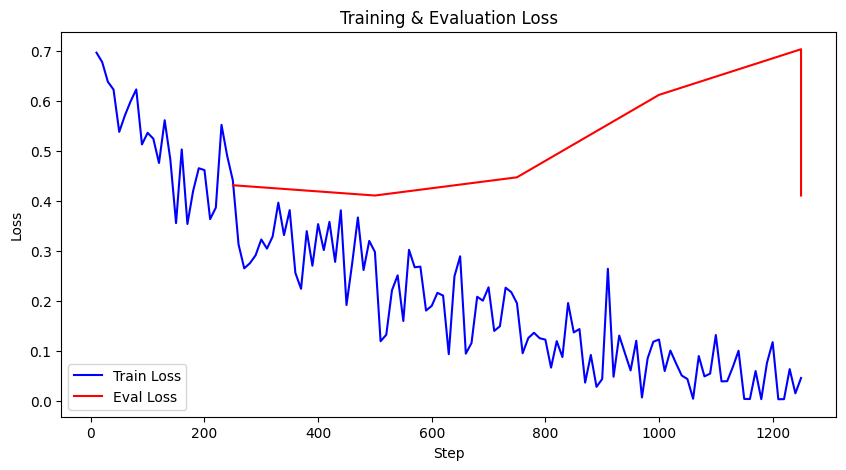

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

train_logs = trainer.state.log_history

df = pd.DataFrame(train_logs)

train_loss = df[df["loss"].notna()][["step", "loss"]]
eval_loss = df[df["eval_loss"].notna()][["step", "eval_loss"]]

plt.figure(figsize=(10, 5))
plt.plot(train_loss["step"], train_loss["loss"], label="Train Loss", color="blue")
plt.plot(eval_loss["step"], eval_loss["eval_loss"], label="Eval Loss", color="red")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training & Evaluation Loss")
plt.legend()
plt.show()
